Imports

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import pandas_datareader.data as web
import pywt
from pygam import LinearGAM, s
import QuantLib as ql
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.linalg import toeplitz
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
from scipy.stats import linregress
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import yfinance as yf

#MANUALLY PATCH MODULE CONFLICT....
import os
import re
import sys
import importlib.util

spec = importlib.util.find_spec("trading_calendars")
if spec is None:
    raise ImportError("Could not find trading_calendars installation")
package_dir = os.path.dirname(spec.origin)
helpers_path = os.path.join(package_dir, "calendar_helpers.py")

with open(helpers_path, "r", encoding="utf-8") as f:
    src = f.read()
patched_src = re.sub(
    r"NP_NAT\s*=.*",
    "NP_NAT = np.int64(pd.NaT.value)",
    src
)

helpers_spec = importlib.util.spec_from_file_location(
    "trading_calendars.calendar_helpers",
    helpers_path
)
helpers_mod = importlib.util.module_from_spec(helpers_spec)
# Make sure numpy & pandas are available inside
helpers_mod.__dict__.update({"np": np, "pd": pd})
exec(patched_src, helpers_mod.__dict__)

sys.modules["trading_calendars.calendar_helpers"] = helpers_mod

import trading_calendars as tc

# Test
print(tc.get_calendar("XNYS").name)   # should print "XNYS" without error


C:\Users\victo\AppData\Roaming\Python\Python38\site-packages\trading_calendars\trading_calendar.py:155: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  self.schedule = DataFrame(


XNYS


# Chapter 1: Data and Basics

## Import Data

In [2]:
#load in main data
options_data = pd.read_csv("sg8kjn2nomlttzia.csv")
options_data["date"] = pd.to_datetime(options_data["date"])
options_data["exdate"] = pd.to_datetime(options_data["exdate"])
#remove SPX
options_data = options_data[~options_data["symbol"].str.contains("SPXW", na=False)]
print(options_data)
underlying_data = pd.read_csv("eclqezarx3ry3dbg.csv")
underlying_data["date"] = pd.to_datetime(underlying_data["date"])

merged_data = pd.merge(options_data, underlying_data, on="date", how="inner")
merged_data["mid_price"] = (merged_data["best_bid"] + merged_data["best_offer"]) / 2
print(merged_data)

              date              symbol     exdate cp_flag  strike_price  \
0       2022-08-31  SPX 220916P1000000 2022-09-16       P       1000000   
1       2022-08-31  SPX 220916P1100000 2022-09-16       P       1100000   
2       2022-08-31  SPX 220916P1200000 2022-09-16       P       1200000   
3       2022-08-31  SPX 220916P1300000 2022-09-16       P       1300000   
4       2022-08-31  SPX 220916P1400000 2022-09-16       P       1400000   
...            ...                 ...        ...     ...           ...   
2372708 2023-08-31  SPX 281215P8000000 2028-12-15       P       8000000   
2372709 2023-08-31  SPX 281215P8400000 2028-12-15       P       8400000   
2372710 2023-08-31  SPX 281215P8800000 2028-12-15       P       8800000   
2372711 2023-08-31  SPX 281215P9200000 2028-12-15       P       9200000   
2372712 2023-08-31  SPX 281215P9600000 2028-12-15       P       9600000   

         best_bid  best_offer  volume   optionid  index_flag  \
0             0.0        0.05      

## Filter Data and Compute Maturity

In [3]:
# Filter Data and compute cleaned maturity
filtered_data = merged_data[merged_data["exdate"] == "2023-09-15"].copy()

nyse = tc.get_calendar("XNYS")

# Ensure datetime with timezone
filtered_data["date"] = pd.to_datetime(filtered_data["date"]).dt.tz_localize("UTC")
filtered_data["exdate"] = pd.to_datetime(filtered_data["exdate"]).dt.tz_localize("UTC")
min_date = filtered_data["date"].min()
max_date = filtered_data["exdate"].max()

# Generate all NYSE sessions in range
sessions = nyse.sessions_in_range(min_date, max_date)

def weighted_maturity(start, end):

    # All days in the range (excluding end)
    all_days = pd.date_range(start=start, end=end - pd.Timedelta(days=1), freq="D", tz="UTC")

    # Trading days in the range
    trading_days = [day for day in sessions if start <= day < end]

    n_trading_days = len(trading_days)
    n_total_days = len(all_days)
    n_non_trading_days = n_total_days - n_trading_days

    # Weighted maturity calculation
    maturity = (n_trading_days + 0.25 * n_non_trading_days) / ((3 * 252 + 365)/4)
    return maturity

filtered_data["maturity"] = filtered_data.apply(
    lambda row: weighted_maturity(row["date"], row["exdate"]),
    axis=1
)
print(filtered_data)
# exdate to be used later
exdate = filtered_data["exdate"].iloc[0]

                            date              symbol  \
2591   2022-08-31 00:00:00+00:00  SPX 230915P1000000   
2592   2022-08-31 00:00:00+00:00  SPX 230915P1200000   
2593   2022-08-31 00:00:00+00:00  SPX 230915P1400000   
2594   2022-08-31 00:00:00+00:00  SPX 230915P1600000   
2595   2022-08-31 00:00:00+00:00  SPX 230915P1700000   
...                          ...                 ...   
772189 2023-08-31 00:00:00+00:00  SPX 230915P6800000   
772190 2023-08-31 00:00:00+00:00  SPX 230915P7000000   
772191 2023-08-31 00:00:00+00:00  SPX 230915P7200000   
772192 2023-08-31 00:00:00+00:00  SPX 230915P7300000   
772193 2023-08-31 00:00:00+00:00   SPX 230915P800000   

                          exdate cp_flag  strike_price  best_bid  best_offer  \
2591   2023-09-15 00:00:00+00:00       P       1000000       3.2        3.60   
2592   2023-09-15 00:00:00+00:00       P       1200000       5.3        5.70   
2593   2023-09-15 00:00:00+00:00       P       1400000       8.2        8.70   
2594   

## Compute interest rates

In [4]:
#Compute interest rates via box spread

# load call and put data
df = pd.read_csv("io263x9neh8bbccn.csv")
df["mid"] = (df["best_bid"] + df["best_offer"]) / 2

underlying_data = pd.read_csv("eclqezarx3ry3dbg.csv")
underlying_data["date"] = pd.to_datetime(underlying_data["date"])

# Precompute a mapping from to mid prices
def prepare_option_dict(df_day):
    return {(row["strike_price"], row["cp_flag"]): row["mid"] for _, row in df_day.iterrows()}

results = []

exdate = pd.to_datetime("2023-09-15").tz_localize("UTC")

for trade_date in sorted(df["date"].unique()):
    #print(trade_date)
    df_day = df[(df["date"] == trade_date) & (df["exdate"] == "2023-09-15")]
    underlying = underlying_data[underlying_data["date"] == trade_date]["close"].values[0]
    if df_day.empty:
        continue

    maturity = weighted_maturity(pd.to_datetime(trade_date).tz_localize("UTC"), exdate)
    option_dict = prepare_option_dict(df_day)

    # Filter strikes with both calls and puts
    cp_counts = df_day.groupby("strike_price")["cp_flag"].nunique()
    eligible_strikes = cp_counts[cp_counts == 2].index.to_list()

    if len(eligible_strikes) < 2:
        results.append({"date": trade_date, "K1": np.nan, "K2": np.nan, "r": np.nan})
        continue

    min_strike = eligible_strikes[0]
    max_strike = eligible_strikes[-1]

    # K1 fixed as the minimum strike
    for K2 in eligible_strikes[1:]:  # K2 > min_strike
        try:
            C1 = option_dict[(min_strike, "C")]
            C2 = option_dict[(K2, "C")]
            P1 = option_dict[(min_strike, "P")]
            P2 = option_dict[(K2, "P")]
            cost = (C1 - C2) + (P2 - P1)
            r_val = -np.log(cost / ((K2 - min_strike) / 1000)) / maturity
            #compute divs using put-call parity
            q1 = -np.log((C1 - P1 + (min_strike/1000)*np.exp(-r_val*maturity))/underlying)/maturity
            q2 = -np.log((C2 - P2 + (K2/1000)*np.exp(-r_val*maturity))/underlying)/maturity
            results.append({"date": trade_date, "K1": min_strike, "K2": K2, "r": r_val, "q":(q1+q2)/2})
        except KeyError:
            continue

    # K2 fixed as the maximum strike
    for K1 in eligible_strikes[:-1]:  # K1 < max_strike
        try:
            C1 = option_dict[(K1, "C")]
            C2 = option_dict[(max_strike, "C")]
            P1 = option_dict[(K1, "P")]
            P2 = option_dict[(max_strike, "P")]
            cost = (C1 - C2) + (P2 - P1)
            r_val = -np.log(cost / ((max_strike - K1) / 1000)) / maturity
            #compute divs using put-call parity
            q1 = -np.log((C1 - P1 + (K1/1000)*np.exp(-r_val*maturity))/underlying)/maturity
            q2 = -np.log((C2 - P2 + (max_strike/1000)*np.exp(-r_val*maturity))/underlying)/maturity
            results.append({"date": trade_date, "K1": min_strike, "K2": K2, "r": r_val, "q":(q1+q2)/2})
        except KeyError:
            continue

# Finalize results
r_df = pd.DataFrame(results)
r_df["date"] = pd.to_datetime(r_df["date"]).dt.tz_localize("UTC")

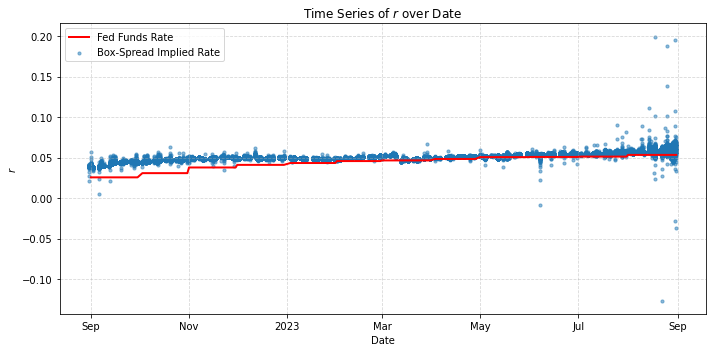

In [34]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

# Convert df
r_df["date"] = pd.to_datetime(r_df["date"], utc=True)
r_df1 = r_df.set_index("date")
r_df1.index = r_df1.index.tz_localize(None)

# Feds fund rate
start, end = r_df1.index.min(), r_df1.index.max()
ffr = web.DataReader("FEDFUNDS", "fred", start, end)
ffr_daily = ffr.reindex(r_df1.index, method="ffill") / 100 

r = ffr_daily.iloc[:, 0].to_numpy()

# Plot
ax.scatter(r_df["date"], r_df["r"], alpha=0.5, s=10, label="Box-Spread Implied Rate")
ax.plot(r_df1.index, r, label="Fed Funds Rate", linewidth=2, color="red")

# Set locator and formatter
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator, show_offset=False)  # Disable offset

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_title("Time Series of $r$ over Date")
ax.set_xlabel("Date")
ax.set_ylabel("$r$")
ax.grid(True, which="major", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.legend()
plt.show()


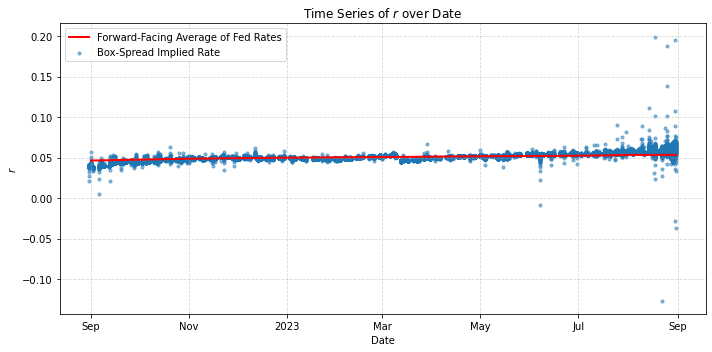

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

# Convert df
r_df["date"] = pd.to_datetime(r_df["date"], utc=True)
r_df1 = r_df.set_index("date")
r_df1.index = r_df1.index.tz_localize(None)

# Fed Funds Rate
start, end = r_df1.index.min(), r_df1.index.max()
ffr = web.DataReader("FEDFUNDS", "fred", start, end)
ffr_daily = ffr.reindex(r_df1.index, method="ffill") / 100

# Compute forward-facing average
r_values = ffr_daily["FEDFUNDS"].to_numpy()
forward_avg = np.array([r_values[i:].mean() for i in range(len(r_values))])

# Plot
ax.scatter(r_df["date"], r_df["r"], alpha=0.5, s=10, label="Box-Spread Implied Rate")
ax.plot(r_df1.index, forward_avg, label="Forward-Facing Average of Fed Rates", linewidth=2, color="red")

# Format ticks with offset disabled to avoid duplicated year
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator, show_offset=False)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_title("Time Series of $r$ over Date")
ax.set_xlabel("Date")
ax.set_ylabel("$r$")
ax.grid(True, which="major", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.legend()
plt.show()


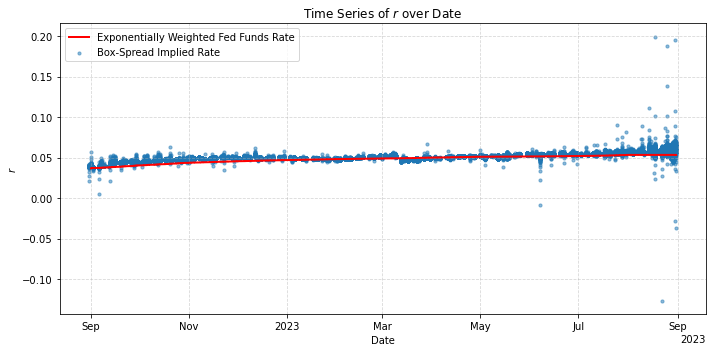

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
#convert df
r_df["date"] = pd.to_datetime(r_df["date"], utc=True)
r_df1 = r_df.set_index("date")
r_df1.index = r_df1.index.tz_localize(None)

#Feds fund rate
start, end = r_df1.index.min(), r_df1.index.max()
ffr = web.DataReader("FEDFUNDS", "fred", start, end)
ffr_daily = ffr.reindex(r_df1.index, method="ffill")/100 

decay = 0.99995  # λ, decay factor 

r = ffr_daily.iloc[:, 0].to_numpy()
n = len(r)

y = np.zeros(n)
w = np.zeros(n)

# Initialize from the end
y[-1] = r[-1]
w[-1] = 1

# Backward recursion
for t in range(n - 2, -1, -1):
    y[t] = r[t] + decay * y[t + 1]
    w[t] = 1 + decay * w[t + 1]

# Normalized exponentially weighted forward average
ffr_forward_exp_avg = y / w

# Convert to DataFrame
ffr_exp_weighted = pd.DataFrame(ffr_forward_exp_avg, index=ffr_daily.index, columns=["ffr_forward_exp_avg"])
#plot
ax.scatter(r_df["date"], r_df["r"], alpha=0.5, s=10, label="Box-Spread Implied Rate")
ax.plot(r_df1.index, ffr_forward_exp_avg, label="Exponentially Weighted Fed Funds Rate", linewidth=2, color="red")

#nice ticks
# Format ticks with offset disabled to avoid duplicated year
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator, show_offset=False)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_title("Time Series of $r$ over Date")
ax.set_xlabel("Date")
ax.set_ylabel("$r$")
ax.grid(True, which="major", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.legend()
plt.show()

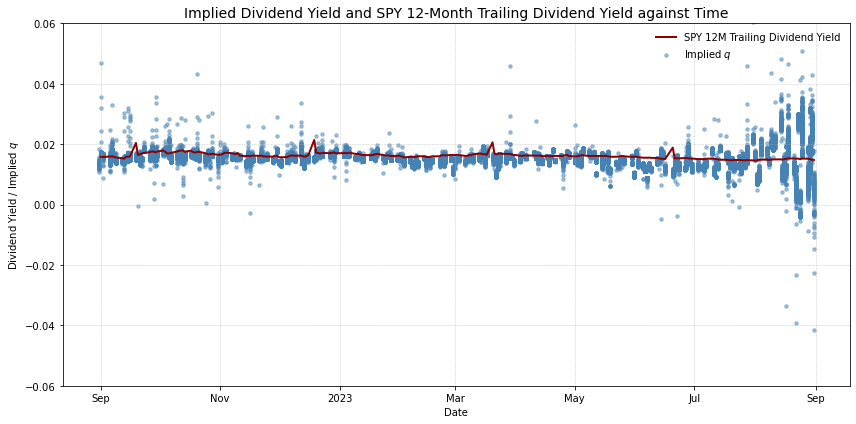

In [36]:
# Convert date column to datetime
r_df["date"] = pd.to_datetime(r_df["date"], utc=True)

# Get SPY dividend data
spy = yf.Ticker("SPY")
dividends = spy.dividends.reset_index()
dividends.columns = ["date", "div"]
dividends["date"] = pd.to_datetime(dividends["date"], utc=True)

# Get daily SPY price data over range of r_df
spy_hist = spy.history(start=r_df["date"].min(), end=r_df["date"].max(), interval="1d")
spy_hist = spy_hist.reset_index()[["Date", "Close"]]
spy_hist.columns = ["date", "price"]
spy_hist["date"] = pd.to_datetime(spy_hist["date"], utc=True)

# Compute rolling 12-month dividend sum
dividends = dividends.sort_values("date")
rolling_divs = []
for current_date in spy_hist["date"]:
    one_year_ago = current_date - pd.Timedelta(days=365)
    trailing_divs = dividends[(dividends["date"] > one_year_ago) & (dividends["date"] <= current_date)]
    rolling_sum = trailing_divs["div"].sum()
    rolling_divs.append(rolling_sum)
spy_hist["rolling_div"] = rolling_divs

# Compute trailing 12-month dividend yield
spy_hist["div_yield"] = spy_hist["rolling_div"] / spy_hist["price"]

# Merge with implied q data
merged = pd.merge_asof(
    r_df.sort_values("date"),
    spy_hist[["date", "div_yield"]].sort_values("date"),
    on="date",
    direction="backward"
)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Implied q
ax.scatter(
    merged["date"], merged["q"], 
    alpha=0.5, s=12, label="Implied $q$", color="steelblue"
)

# SPY dividend yield
ax.plot(
    merged["date"], merged["div_yield"], 
    color="darkred", linewidth=2, label="SPY 12M Trailing Dividend Yield"
)

# Styling
ax.set_ylim(-0.06, 0.06)
ax.set_ylabel("Dividend Yield / Implied $q$")
ax.set_title("Implied Dividend Yield and SPY 12-Month Trailing Dividend Yield against Time", fontsize=14)
ax.legend(frameon=False, fontsize=10, loc="upper right")

# Format dates
# Format ticks with offset disabled to avoid duplicated year
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator, show_offset=False)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel("Date")

plt.tight_layout()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()


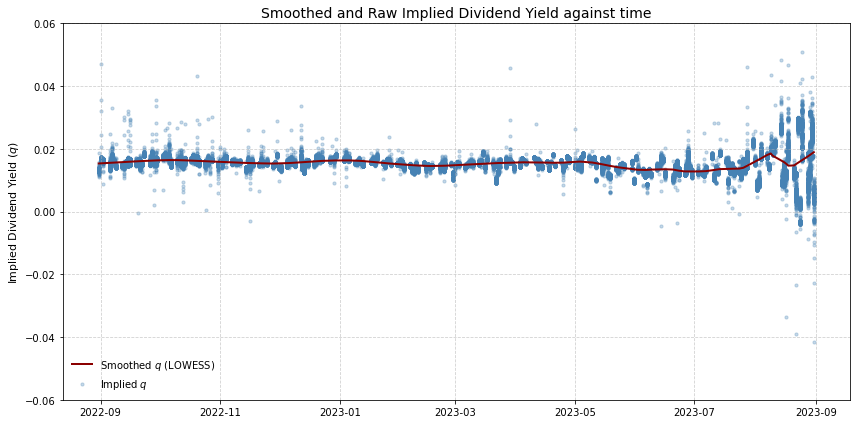

In [9]:
# Ensure dates are sorted
r_df_sorted = r_df.sort_values("date")
x_seconds = r_df_sorted["date"].astype(np.int64) // 10**9  # Convert datetime to POSIX seconds
y_q = r_df_sorted["q"].values

# Apply LOWESS smoothing
smoothed = lowess(y_q, x_seconds, frac=0.1)

# Extract smoothed values
smoothed_seconds = smoothed[:, 0]
smoothed_q = smoothed[:, 1]
smoothed_dates = pd.to_datetime(smoothed_seconds, unit="s")

# Interpolate smoothed q on daily date grid
start_date = smoothed_dates.min().normalize()
end_date = smoothed_dates.max().normalize()
daily_dates = pd.date_range(start=start_date, end=end_date, freq="D")
daily_seconds = daily_dates.astype(np.int64) // 10**9
daily_q = np.interp(daily_seconds, smoothed_seconds, smoothed_q)

# Optional: Store as DataFrame
daily_q_df = pd.DataFrame({"date": daily_dates, "estimated_q": daily_q})

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Raw implied q
ax.scatter(
    r_df_sorted["date"], r_df_sorted["q"], 
    s=10, alpha=0.3, color="steelblue", label="Implied $q$"
)

# Smoothed q
ax.plot(
    smoothed_dates, smoothed_q, 
    color="darkred", linewidth=2, label="Smoothed $q$ (LOWESS)"
)

# Style
ax.set_ylim(-0.06, 0.06)
ax.set_ylabel("Implied Dividend Yield ($q$)", fontsize=11)
ax.set_title("Smoothed and Raw Implied Dividend Yield against time", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
r_df = pd.DataFrame(results)

# Ensure "date" is a datetime object localized to UTC
r_df["date"] = pd.to_datetime(r_df["date"]).dt.tz_localize("UTC")
daily_q_df["date"] = pd.to_datetime(daily_q_df["date"]).dt.tz_localize("UTC")


# Group by date and compute median r for each day
median_r_per_day = r_df.groupby("date")["r"].median().reset_index()

median_r_per_day = median_r_per_day.rename(columns={"r": "median_r"})

merged = pd.merge(median_r_per_day, daily_q_df, on="date")
#effective r
r_only_df = merged[["date", "median_r","estimated_q"]]

filtered_data = filtered_data.merge(r_only_df, on="date", how="left")
filtered_data

,date,symbol,exdate,cp_flag,strike_price,best_bid,best_offer,volume,optionid,index_flag,issuer,exercise_style,secid,close,mid_price,maturity,median_r,estimated_q
0,2022-08-31 00:00:00+00:00,SPX 230915P1000000,2023-09-15 00:00:00+00:00,P,1000000,3.2,3.60,0,146903055,1,CBOE S&P 500 INDEX,E,108105,3955.00,3.400,1.040143,0.039082,0.015347
1,2022-08-31 00:00:00+00:00,SPX 230915P1200000,2023-09-15 00:00:00+00:00,P,1200000,5.3,5.70,0,146903056,1,CBOE S&P 500 INDEX,E,108105,3955.00,5.500,1.040143,0.039082,0.015347
2,2022-08-31 00:00:00+00:00,SPX 230915P1400000,2023-09-15 00:00:00+00:00,P,1400000,8.2,8.70,111,146903057,1,CBOE S&P 500 INDEX,E,108105,3955.00,8.450,1.040143,0.039082,0.015347
3,2022-08-31 00:00:00+00:00,SPX 230915P1600000,2023-09-15 00:00:00+00:00,P,1600000,12.2,12.60,0,146903058,1,CBOE S&P 500 INDEX,E,108105,3955.00,12.400,1.040143,0.039082,0.015347
4,2022-08-31 00:00:00+00:00,SPX 230915P1700000,2023-09-15 00:00:00+00:00,P,1700000,14.6,15.10,0,146903059,1,CBOE S&P 500 INDEX,E,108105,3955.00,14.850,1.040143,0.039082,0.015347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51793,2023-08-31 00:00:00+00:00,SPX 230915P6800000,2023-09-15 00:00:00+00:00,P,6800000,2268.3,2281.80,0,146903147,1,CBOE S&P 500 INDEX,E,108105,4507.66,2275.050,0.040143,0.062356,0.018943
51794,2023-08-31 00:00:00+00:00,SPX 230915P7000000,2023-09-15 00:00:00+00:00,P,7000000,2467.8,2481.40,0,146903148,1,CBOE S&P 500 INDEX,E,108105,4507.66,2474.600,0.040143,0.062356,0.018943
51795,2023-08-31 00:00:00+00:00,SPX 230915P7200000,2023-09-15 00:00:00+00:00,P,7200000,2667.3,2680.90,1,146903149,1,CBOE S&P 500 INDEX,E,108105,4507.66,2674.100,0.040143,0.062356,0.018943
51796,2023-08-31 00:00:00+00:00,SPX 230915P7300000,2023-09-15 00:00:00+00:00,P,7300000,2767.1,2780.60,0,155236840,1,CBOE S&P 500 INDEX,E,108105,4507.66,2773.850,0.040143,0.062356,0.018943


## Fundamentals and functions

In [11]:
#Black-Scholes model for Put option pricing
def BSModel(underlying, maturity, strike, r, dividends, volatility):
    d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))
    d2 = d1 - (volatility * np.sqrt(maturity))
    price = strike * np.exp( - r *maturity) * norm.cdf(-d2) - underlying * np.exp( - dividends * maturity) * norm.cdf( - d1)
    return price

In [12]:
#Implied volatility calculation via Brent"s method, with the ability to catch and plot error points

error_maturity = []
error_strike = []
error_volume=[]

def implied_volatility(mid_price, underlying, maturity, strike, r, dividends,volume):
    global error_maturity
    global error_strike
    global error_volume
    # Define objective function as the difference between Black-Scholes price and market price
    objective = lambda vol: BSModel(underlying, maturity, strike, r, dividends, vol) - mid_price
    # Use Brent"s method to find volatility
    try:
        return brentq(objective, 0.01,20)
    except Exception as e:
        print(maturity,underlying/strike,volume)
        error_maturity.append(maturity)
        error_strike.append(underlying/strike)
        error_volume.append(volume)
        vols = np.linspace(0, 2, 500)

        # Compute the price differences
        diffs = [BSModel(underlying, maturity, strike, r, dividends, vol) - mid_price for vol in vols]
        
        #is there anything negativo
        for vol, diff in zip(vols, diffs):
            if diff < 0:
                print(f"Vol: {vol:.4f}, Diff: {diff:.4f}")
        return np.nan

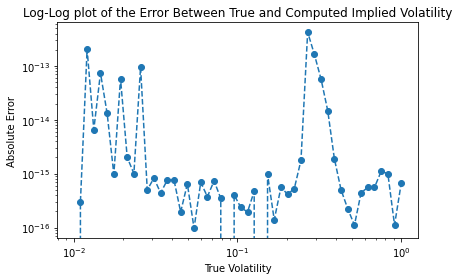

In [13]:
#Verification of Accuracy

#use true data: 
filtered_data_corrected = filtered_data[filtered_data["date"] == "2023-08-16"]
underlying = list(filtered_data_corrected["close"].astype(float))[0]
maturity = list(filtered_data_corrected["maturity"].astype(float))[0]
r = list(filtered_data_corrected["median_r"].astype(float))[0]

true_vols = np.logspace(-2, 0, 50)  # from 0.01 to 1.0
computed_vols = []
residuals = []

# Compute implied vol and residuals
for tv in true_vols:
    mid_price = BSModel(underlying, maturity, underlying - 10, r, 0, tv)
    iv = implied_volatility(mid_price, underlying, maturity, underlying - 10, r, 0, 0)
    residual = abs(tv - iv)
    computed_vols.append(iv)
    residuals.append(residual)

# Plot residuals vs true volatility (log-log)
plt.figure()
plt.plot(true_vols, residuals, marker="o", linestyle="--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True Volatility")
plt.ylabel("Absolute Error")
plt.title("Log-Log plot of the Error Between True and Computed Implied Volatility")
plt.tight_layout()
plt.show()


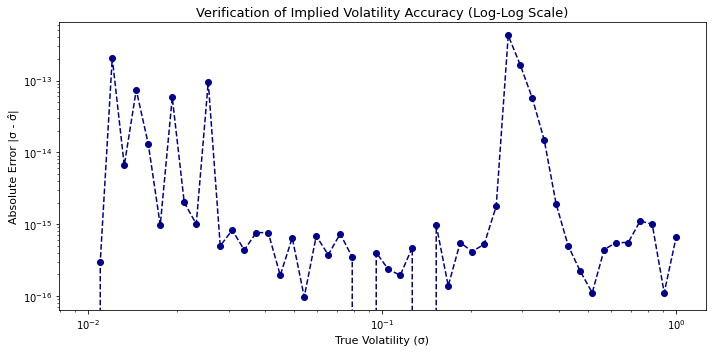

In [14]:
# Verification of Accuracy between True and Implied Volatility

# Extract real market data for a specific date
selected_date = "2023-08-16"
data_slice = filtered_data[filtered_data["date"] == selected_date]
underlying_price = float(data_slice["close"].iloc[0])
time_to_maturity = float(data_slice["maturity"].iloc[0])
risk_free_rate = float(data_slice["median_r"].iloc[0])

# Define range of true volatilities
true_vols = np.logspace(-2, 0, 50)  # From 0.01 to 1.0
implied_vols = []
abs_errors = []

# Strike slightly below spot to avoid zero payoff
strike = underlying_price - 10

# Compute implied volatility and absolute error
for sigma_true in true_vols:
    mid_price = BSModel(underlying_price, time_to_maturity, strike, risk_free_rate, 0, sigma_true)
    sigma_est = implied_volatility(mid_price, underlying_price, time_to_maturity, strike, risk_free_rate, 0, 0)
    
    error = abs(sigma_true - sigma_est)
    implied_vols.append(sigma_est)
    abs_errors.append(error)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(true_vols, abs_errors, marker="o", linestyle="--", color="darkblue")
ax.set_xscale("log")
ax.set_yscale("log")

# Labels and title
ax.set_xlabel("True Volatility (σ)", fontsize=11)
ax.set_ylabel("Absolute Error |σ - σ̂|", fontsize=11)
ax.set_title("Verification of Implied Volatility Accuracy (Log-Log Scale)", fontsize=13)

# Styling
plt.tight_layout()
plt.show()


##  Compute Volatility

In [15]:
#Compute volatility
results = []
for date, group in filtered_data.groupby("date"):
    #print(date)
    underlying_price = group["close"].iloc[0]  # Get underlying price for the date
    strikes = group["strike_price"].values
    maturities = group["maturity"].values
    mid_prices = group["mid_price"].values
    bid_prices = group["best_bid"].values
    ask_prices = group["best_offer"].values
    r = group["median_r"].values
    q = group["estimated_q"].values
    volume = group["volume"].values

    # Compute implied volatilities for all strikes
    implied_vols = [
        implied_volatility(mid_prices[i], underlying_price, maturities[i], strikes[i]/1000, r[i], q[i], volume[i])
        for i in range(len(strikes))
    ]
    
    # Store results as a DataFrame
    result = pd.DataFrame({
        "date": date,
        "strike": strikes,
        "implied_volatility": implied_vols,
        "bid_prices" : bid_prices,
        "ask_prices" : ask_prices,
        "underlying" : underlying_price,
        "maturities" : maturities,
        "r":r,
        "q":q
        
    })
    results.append(result)

# Combine all results into a single DataFrame
iv_df = pd.concat(results, ignore_index=True)
#print(iv_df)

1.04014272970562 0.6818965517241379 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


1.04014272970562 0.6591666666666667 0
1.04014272970562 0.6379032258064516 0
1.04014272970562 0.61796875 0
1.04014272970562 0.5992424242424242 0
1.04014272970562 0.5816176470588236 0
1.04014272970562 0.565 0
1.04014272970562 0.5493055555555556 0
1.0267618198037467 0.5428041666666666 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


1.016057091882248 0.6560258064516129 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


1.016057091882248 0.635525 0
1.016057091882248 0.6162666666666667 0
1.016057091882248 0.5981411764705883 0
1.016057091882248 0.5810514285714286 0
1.016057091882248 0.5649111111111111 0
1.0107047279214987 0.6422515624999999 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


1.0107047279214987 0.6227893939393939 0
1.0107047279214987 0.6044720588235294 0
1.0107047279214987 0.5872014285714285 0
1.0107047279214987 0.5708902777777778 0
1.0071364852809992 0.6554483333333333 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


1.0071364852809992 0.6343048387096775 0
1.0071364852809992 0.6144828125 0
1.0071364852809992 0.5618128571428571 0
1.0071364852809992 0.5462069444444444 0
0.983942908117752 0.6767732142857142 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.983942908117752 0.6534362068965517 0
0.983942908117752 0.631655 0
0.983942908117752 0.6112790322580645 0
0.983942908117752 0.5921765625 0
0.983942908117752 0.5742318181818181 0
0.983942908117752 0.5573426470588235 0
0.983942908117752 0.5414185714285714 0
0.983942908117752 0.5263791666666666 0
0.9803746654772525 0.6263316666666666 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9803746654772525 0.6061274193548387 0
0.9803746654772525 0.5871859374999999 0
0.9803746654772525 0.5693924242424242 0
0.9803746654772525 0.5526455882352941 0
0.9803746654772525 0.5368557142857142 0
0.9803746654772525 0.5219430555555555 0
0.9714540588760036 0.6301793103448275 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9714540588760036 0.6091733333333333 0
0.9714540588760036 0.5895225806451613 0
0.9714540588760036 0.5710999999999999 0
0.9714540588760036 0.5537939393939394 0
0.9714540588760036 0.5375058823529412 0
0.9714540588760036 0.5221485714285714 0
0.9714540588760036 0.5076444444444445 0
0.9643175735950045 0.5811 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9643175735950045 0.563490909090909 0
0.9643175735950045 0.5469176470588235 0
0.9643175735950045 0.5312914285714285 0
0.9643175735950045 0.5165333333333333 0
0.9571810883140054 0.5122314285714286 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9571810883140054 0.49800277777777774 0
0.9375557537912578 0.587041935483871 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9375557537912578 0.568696875 0
0.9375557537912578 0.5514636363636364 0
0.9375557537912578 0.5352441176470588 0
0.9375557537912578 0.5199514285714285 0
0.9375557537912578 0.5055083333333333 0
0.9322033898305084 0.6228258620689655 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9322033898305084 0.602065 0
0.9322033898305084 0.5826435483870968 0
0.9322033898305084 0.5644359375 0
0.9322033898305084 0.5473318181818182 0
0.9322033898305084 0.5312338235294117 0
0.9322033898305084 0.5160557142857143 0
0.9322033898305084 0.5017208333333333 0
0.9250669045495094 0.5961716666666667 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9250669045495094 0.5769403225806452 0
0.9250669045495094 0.5589109375 0
0.9250669045495094 0.5419742424242424 0
0.9250669045495094 0.5260338235294117 0
0.9250669045495094 0.5110042857142857 0
0.9250669045495094 0.49680972222222225 0
0.9214986619090099 0.6327431034482759 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9214986619090099 0.6116516666666666 0
0.9214986619090099 0.5919209677419355 0
0.9214986619090099 0.5734234375 0
0.9214986619090099 0.5560469696969697 0
0.9214986619090099 0.5396926470588235 0
0.9214986619090099 0.5242728571428571 0
0.9214986619090099 0.5097097222222222 0
0.9179304192685103 0.5779145161290323 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9179304192685103 0.5598546875 0
0.9179304192685103 0.542889393939394 0
0.9179304192685103 0.5118671428571429 0
0.9179304192685103 0.49764861111111114 0
0.9018733273862622 0.5236828571428571 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.9018733273862622 0.5091361111111111 0
0.8929527207850134 0.593334375 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8929527207850134 0.5753545454545455 0
0.8929527207850134 0.5584323529411765 0
0.8929527207850134 0.5424771428571429 0
0.8929527207850134 0.5274083333333334 0
0.8893844781445138 0.5847136363636364 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8893844781445138 0.5675161764705883 0
0.8893844781445138 0.5513014285714286 0
0.8893844781445138 0.5359875000000001 0
0.8858162355040142 0.59853125 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8858162355040142 0.5803939393939394 0
0.8858162355040142 0.5633235294117647 0
0.8858162355040142 0.5472285714285714 0
0.8858162355040142 0.5320277777777778 0
0.8733273862622658 0.64533 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8733273862622658 0.6245129032258064 0
0.8733273862622658 0.604996875 0
0.8733273862622658 0.5866636363636364 0
0.8733273862622658 0.5694088235294118 0
0.8733273862622658 0.55314 0
0.8733273862622658 0.537775 0
0.8697591436217663 0.6648448275862069 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8697591436217663 0.6426833333333333 0
0.8697591436217663 0.6219516129032258 0
0.8697591436217663 0.602515625 0
0.8697591436217663 0.5842575757575758 0
0.8697591436217663 0.5670735294117647 0
0.8697591436217663 0.5508714285714286 0
0.8697591436217663 0.5355694444444444 0
0.8661909009812667 0.6482224137931034 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8661909009812667 0.626615 0
0.8661909009812667 0.6064016129032258 0
0.8661909009812667 0.5874515625 0
0.8661909009812667 0.56965 0
0.8661909009812667 0.5528955882352942 0
0.8661909009812667 0.5370985714285714 0
0.8661909009812667 0.5221791666666666 0
0.8340767172167708 0.6822844827586206 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8340767172167708 0.6595416666666667 0
0.8340767172167708 0.6382661290322581 0
0.8340767172167708 0.6183203125 0
0.8340767172167708 0.5995833333333334 0
0.8340767172167708 0.5819485294117647 0
0.8340767172167708 0.5653214285714285 0
0.8340767172167708 0.5496180555555555 0
0.8269402319357716 0.68255 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8269402319357716 0.6597983333333334 0
0.8269402319357716 0.6385145161290322 0
0.8269402319357716 0.6185609375 0
0.8269402319357716 0.5998166666666667 0
0.8269402319357716 0.582175 10
0.8269402319357716 0.5655414285714285 0
0.8269402319357716 0.5498319444444444 10
0.8198037466547725 0.6395709677419356 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8198037466547725 0.6195843750000001 0
0.8198037466547725 0.600809090909091 0
0.8198037466547725 0.5831382352941177 0
0.8198037466547725 0.5664771428571429 0
0.8198037466547725 0.5507416666666667 0
0.8144513826940232 0.5642771428571428 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8108831400535237 0.5887617647058824 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8108831400535237 0.57194 0
0.8108831400535237 0.5560527777777777 0
0.8073148974130241 0.6101909090909091 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.8073148974130241 0.5593416666666667 0
0.7975022301516503 0.619365625 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7975022301516503 0.5662771428571428 0
0.7975022301516503 0.5505472222222222 0
0.7939339875111507 0.6183796875 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7939339875111507 0.5820044117647059 0
0.7939339875111507 0.5653757142857143 0
0.7939339875111507 0.5496708333333333 0
0.7867975022301517 0.7028568965517241 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7867975022301517 0.6794283333333334 0
0.7867975022301517 0.6575112903225807 0
0.7867975022301517 0.6369640625 0
0.7867975022301517 0.6176621212121213 0
0.7867975022301517 0.5994955882352941 0
0.7867975022301517 0.5823671428571429 0
0.7867975022301517 0.5661902777777778 0
0.7832292595896521 0.7020172413793103 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7832292595896521 0.6786166666666666 0
0.7832292595896521 0.6567258064516128 0
0.7832292595896521 0.636203125 0
0.7832292595896521 0.6169242424242424 0
0.7832292595896521 0.5987794117647058 0
0.7832292595896521 0.5816714285714285 10
0.7832292595896521 0.5655138888888889 50
0.7778768956289027 0.6894551724137932 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7778768956289027 0.6664733333333334 0
0.7778768956289027 0.6449741935483871 0
0.7778768956289027 0.62481875 0
0.7778768956289027 0.6058848484848485 0
0.7778768956289027 0.5880647058823529 0
0.7778768956289027 0.5712628571428572 0
0.7778768956289027 0.5553944444444444 0
0.7707404103479036 0.5785176470588236 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7707404103479036 0.5619885714285714 0
0.7707404103479036 0.5463777777777777 0
0.7636039250669046 0.6345774193548387 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7636039250669046 0.614746875 0
0.7636039250669046 0.5961181818181819 0
0.7636039250669046 0.578585294117647 0
0.7636039250669046 0.5620542857142857 0
0.7636039250669046 0.5464416666666667 0
0.7546833184656556 0.7308454545454546 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7546833184656556 0.7177946428571429 0
0.7546833184656556 0.6930431034482759 0
0.7546833184656556 0.6699416666666667 0
0.7546833184656556 0.6483306451612904 0
0.7546833184656556 0.6280703125 0
0.7546833184656556 0.6090378787878789 0
0.7546833184656556 0.591125 0
0.7546833184656556 0.5742357142857143 0
0.7546833184656556 0.5582847222222223 0
0.7511150758251561 0.753833962264151 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7511150758251561 0.7398740740740741 0
0.7511150758251561 0.7264218181818182 0
0.7511150758251561 0.71345 0
0.7511150758251561 0.688848275862069 0
0.7511150758251561 0.6658866666666667 0
0.7511150758251561 0.6444064516129032 0
0.7511150758251561 0.62426875 0
0.7511150758251561 0.6053515151515152 0
0.7511150758251561 0.5875470588235294 0
0.7511150758251561 0.57076 0
0.7511150758251561 0.5549055555555555 0
0.7475468331846565 0.6283467741935483 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7475468331846565 0.6087109375 0
0.7475468331846565 0.5902651515151515 0
0.7475468331846565 0.5729044117647059 0
0.7475468331846565 0.5565357142857142 0
0.7475468331846565 0.5410763888888889 0
0.743978590544157 0.6642 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.743978590544157 0.6420600000000001 0
0.743978590544157 0.6213483870967742 0
0.743978590544157 0.60193125 0
0.743978590544157 0.5836909090909091 0
0.743978590544157 0.5665235294117648 0
0.743978590544157 0.5503371428571429 0
0.743978590544157 0.53505 0
0.7386262265834077 0.681725 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7386262265834077 0.6582172413793104 0
0.7386262265834077 0.6362766666666666 0
0.7386262265834077 0.6157516129032258 0
0.7386262265834077 0.596509375 0
0.7386262265834077 0.5784333333333334 0
0.7386262265834077 0.5614205882352941 0
0.7386262265834077 0.54538 0
0.7386262265834077 0.5302305555555555 0
0.7350579839429081 0.5790333333333333 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.7350579839429081 0.5459457142857143 0
0.7011596788581623 0.5311305555555556 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6851025869759143 0.6950160714285715 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6851025869759143 0.67105 0
0.6851025869759143 0.6486816666666667 0
0.6851025869759143 0.6277564516129033 0
0.6851025869759143 0.6081390625 0
0.6851025869759143 0.5897106060606061 0
0.6851025869759143 0.5723661764705883 0
0.6851025869759143 0.5560128571428572 0
0.6851025869759143 0.5405680555555555 0
0.6815343443354148 0.6532083333333333 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6815343443354148 0.6123828125 0
0.6815343443354148 0.5938257575757576 0
0.6815343443354148 0.5763602941176471 0
0.6815343443354148 0.5598928571428572 0
0.6815343443354148 0.5443402777777778 0
0.6743978590544157 0.686753448275862 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6743978590544157 0.6638616666666667 0
0.6743978590544157 0.6424467741935485 0
0.6743978590544157 0.6223703125 0
0.6743978590544157 0.603510606060606 0
0.6743978590544157 0.5857602941176471 0
0.6743978590544157 0.5690242857142858 0
0.6743978590544157 0.5532180555555556 0
0.6708296164139161 0.7545452830188679 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6708296164139161 0.7405722222222223 0
0.6708296164139161 0.7271072727272727 0
0.6708296164139161 0.7141232142857143 0
0.6708296164139161 0.689498275862069 0
0.6708296164139161 0.6665150000000001 0
0.6708296164139161 0.6450145161290323 0
0.6708296164139161 0.6248578125 0
0.6708296164139161 0.6059227272727273 0
0.6708296164139161 0.5881014705882354 0
0.6708296164139161 0.5712985714285714 0
0.6708296164139161 0.5554291666666666 0
0.6645851917930419 0.688098275862069 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6645851917930419 0.6651616666666667 0
0.6645851917930419 0.6437048387096774 0
0.6645851917930419 0.6235890625 0
0.6645851917930419 0.6046924242424242 0
0.6645851917930419 0.5869073529411765 0
0.6645851917930419 0.5701385714285714 0
0.6645851917930419 0.5543013888888889 0
0.6574487065120428 0.7220092592592593 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6574487065120428 0.7088818181818182 0
0.6574487065120428 0.6962232142857143 0
0.6574487065120428 0.6722155172413793 0
0.6574487065120428 0.6498083333333333 0
0.6574487065120428 0.6288467741935484 0
0.6574487065120428 0.6091953125 0
0.6574487065120428 0.5907348484848485 0
0.6574487065120428 0.573360294117647 0
0.6574487065120428 0.5569785714285714 0
0.6574487065120428 0.5415069444444445 0
0.6449598572702944 0.7303545454545454 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6449598572702944 0.7173125 0
0.6449598572702944 0.6925775862068965 0
0.6449598572702944 0.6694916666666666 0
0.6449598572702944 0.6478951612903225 0
0.6449598572702944 0.6276484375 0
0.6449598572702944 0.6086287878787878 0
0.6449598572702944 0.5907279411764705 0
0.6449598572702944 0.57385 0
0.6449598572702944 0.5579097222222222 0
0.6342551293487957 0.7268857142857142 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6342551293487957 0.7018206896551724 0
0.6342551293487957 0.6784266666666666 0
0.6342551293487957 0.656541935483871 0
0.6342551293487957 0.636025 0
0.6342551293487957 0.6167515151515152 0
0.6342551293487957 0.5986117647058824 0
0.6342551293487957 0.5815085714285714 0
0.6342551293487957 0.5653555555555555 0
0.6217662801070473 0.6643887096774194 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6217662801070473 0.6436265625 0
0.6217662801070473 0.6057661764705883 0
0.6217662801070473 0.5884585714285714 0
0.6217662801070473 0.5721125 0
0.6146297948260482 0.7804679245283018 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6146297948260482 0.7660148148148147 0
0.6146297948260482 0.7520872727272726 0
0.6146297948260482 0.7386571428571428 0
0.6146297948260482 0.7131862068965517 0
0.6146297948260482 0.6894133333333332 0
0.6146297948260482 0.667174193548387 0
0.6146297948260482 0.6463249999999999 0
0.6146297948260482 0.6267393939393938 0
0.6146297948260482 0.6083058823529411 0
0.6146297948260482 0.5909257142857143 0
0.6146297948260482 0.5745111111111111 0
0.6057091882247992 0.7856603773584906 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6057091882247992 0.7711111111111111 0
0.6057091882247992 0.757090909090909 0
0.6057091882247992 0.7435714285714285 0
0.6057091882247992 0.7179310344827586 0
0.6057091882247992 0.694 0
0.6057091882247992 0.6716129032258065 0
0.6057091882247992 0.650625 0
0.6057091882247992 0.6309090909090909 0
0.6057091882247992 0.6123529411764705 0
0.6057091882247992 0.5948571428571429 0
0.6057091882247992 0.5783333333333334 0
0.6021409455842998 0.7487018181818181 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.6021409455842998 0.7353321428571428 0
0.6021409455842998 0.7099758620689655 0
0.6021409455842998 0.68631 0
0.6021409455842998 0.6641709677419354 0
0.6021409455842998 0.6434156249999999 0
0.6021409455842998 0.6239181818181818 0
0.6021409455842998 0.6055676470588235 0
0.6021409455842998 0.5882657142857143 0
0.6021409455842998 0.5719249999999999 0
0.5950044603033007 0.7574925925925926 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5950044603033007 0.74372 0
0.5950044603033007 0.7304392857142857 0
0.5950044603033007 0.705251724137931 0
0.5950044603033007 0.6817433333333334 0
0.5950044603033007 0.6597516129032258 0
0.5950044603033007 0.639134375 0
0.5950044603033007 0.6197666666666667 0
0.5950044603033007 0.6015382352941177 0
0.5950044603033007 0.5843514285714285 0
0.5950044603033007 0.5681194444444444 0
0.5860838537020517 0.7520236363636363 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5860838537020517 0.7385946428571428 0
0.5860838537020517 0.7131258620689656 0
0.5860838537020517 0.689355 0
0.5860838537020517 0.6671177419354839 0
0.5860838537020517 0.6462703125 0
0.5860838537020517 0.6266863636363637 0
0.5860838537020517 0.6082544117647058 0
0.5860838537020517 0.5908757142857143 0
0.5860838537020517 0.5744625 0
0.5789473684210527 0.7304303571428571 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5789473684210527 0.7052431034482758 0
0.5789473684210527 0.681735 0
0.5789473684210527 0.6597435483870967 0
0.5789473684210527 0.6391265625 0
0.5789473684210527 0.6197590909090909 8
0.5789473684210527 0.6015308823529412 0
0.5789473684210527 0.5843442857142856 0
0.5789473684210527 0.5681125 0
0.5691347011596789 0.7542150943396226 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5691347011596789 0.7402481481481482 0
0.5691347011596789 0.7267890909090909 0
0.5691347011596789 0.7138107142857143 0
0.5691347011596789 0.689196551724138 0
0.5691347011596789 0.6662233333333334 0
0.5691347011596789 0.6447322580645162 0
0.5691347011596789 0.624584375 0
0.5691347011596789 0.6056575757575757 5
0.5691347011596789 0.5878441176470588 0
0.5691347011596789 0.5710485714285715 0
0.5691347011596789 0.5551861111111112 0
0.5619982158786797 0.7867294117647059 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5619982158786797 0.7790912621359224 0
0.5619982158786797 0.7716000000000001 0
0.5619982158786797 0.7570415094339623 0
0.5619982158786797 0.7430222222222223 0
0.5619982158786797 0.7295127272727273 0
0.5619982158786797 0.7164857142857143 0
0.5619982158786797 0.6917793103448276 0
0.5619982158786797 0.66872 0
0.5619982158786797 0.6471483870967742 0
0.5619982158786797 0.6269250000000001 0
0.5619982158786797 0.6079272727272728 0
0.5619982158786797 0.5900470588235295 0
0.5619982158786797 0.5731885714285715 0
0.5619982158786797 0.5572666666666667 0
0.5495093666369313 0.8102346938775511 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5495093666369313 0.8061218274111676 0
0.5495093666369313 0.802050505050505 0
0.5495093666369313 0.79403 0
0.5495093666369313 0.7861683168316832 0
0.5495093666369313 0.7784607843137256 0
0.5495093666369313 0.7709029126213592 0
0.5495093666369313 0.7634903846153847 0
0.5495093666369313 0.7490849056603773 0
0.5495093666369313 0.735212962962963 0
0.5495093666369313 0.7218454545454546 0
0.5495093666369313 0.7089553571428572 0
0.5495093666369313 0.6845086206896552 0
0.5495093666369313 0.6616916666666667 0
0.5495093666369313 0.6403467741935484 0
0.5495093666369313 0.6203359375 0
0.5495093666369313 0.6015378787878788 0
0.5495093666369313 0.5838455882352941 0
0.5495093666369313 0.5671642857142857 1
0.5495093666369313 0.5514097222222223 0
0.5459411239964318 0.7056053571428571 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5459411239964318 0.658565 0
0.5459411239964318 0.6373209677419355 0
0.5459411239964318 0.6174046875 0
0.5459411239964318 0.5810867647058824 0
0.5459411239964318 0.5644842857142857 0
0.5334522747546833 0.7638528301886792 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5334522747546833 0.7497074074074074 0
0.5334522747546833 0.7360763636363636 0
0.5334522747546833 0.7229321428571429 0
0.5334522747546833 0.698003448275862 0
0.5334522747546833 0.6747366666666667 0
0.5334522747546833 0.6529709677419355 0
0.5334522747546833 0.632565625 0
0.5334522747546833 0.6133969696969697 0
0.5334522747546833 0.5953558823529412 0
0.5334522747546833 0.5783457142857142 0
0.5334522747546833 0.5622805555555556 0
0.5298840321141838 0.6429629032258064 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5227475468331847 0.6755724137931035 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5227475468331847 0.6530533333333334 0
0.5227475468331847 0.6319870967741936 0
0.5227475468331847 0.6122375 0
0.5227475468331847 0.5936848484848485 6
0.5227475468331847 0.5762235294117647 0
0.5227475468331847 0.55976 0
0.5227475468331847 0.5442111111111111 0
0.5191793041926851 0.7021072727272728 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5191793041926851 0.6895696428571428 0
0.5191793041926851 0.6657913793103448 0
0.5191793041926851 0.6435983333333334 0
0.5191793041926851 0.6228370967741935 0
0.5191793041926851 0.6033734375 0
0.5191793041926851 0.585089393939394 4
0.5191793041926851 0.5678808823529412 0
0.5191793041926851 0.5516557142857144 0
0.5191793041926851 0.5363319444444444 0
0.5031222123104371 0.7765254901960784 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.5031222123104371 0.7689864077669903 0
0.5031222123104371 0.7615923076923077 0
0.5031222123104371 0.747222641509434 0
0.5031222123104371 0.7333851851851853 0
0.5031222123104371 0.7200509090909091 0
0.5031222123104371 0.7071928571428572 0
0.5031222123104371 0.6828068965517242 0
0.5031222123104371 0.6600466666666667 0
0.5031222123104371 0.6387548387096774 0
0.5031222123104371 0.61879375 0
0.5031222123104371 0.6000424242424243 0
0.5031222123104371 0.5823941176470588 1
0.5031222123104371 0.5657542857142858 2
0.5031222123104371 0.550038888888889 1
0.49420160570918825 0.6813051724137932 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.49420160570918825 0.658595 0
0.49420160570918825 0.63735 0
0.49420160570918825 0.6174328125 0
0.49420160570918825 0.5987227272727274 0
0.49420160570918825 0.5811132352941176 0
0.49420160570918825 0.5645100000000001 0
0.49420160570918825 0.5488291666666667 0
0.49063336306868865 0.7848764705882353 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.49063336306868865 0.7772563106796117 0
0.49063336306868865 0.7697826923076923 0
0.49063336306868865 0.7552584905660377 0
0.49063336306868865 0.7412722222222222 0
0.49063336306868865 0.7277945454545455 0
0.49063336306868865 0.7147982142857142 0
0.49063336306868865 0.6901499999999999 0
0.49063336306868865 0.667145 0
0.49063336306868865 0.6456241935483871 0
0.49063336306868865 0.6254484375 0
0.49063336306868865 0.6064954545454545 0
0.49063336306868865 0.5886573529411765 0
0.49063336306868865 0.5718385714285714 0
0.49063336306868865 0.5559541666666666 0
0.4870651204281891 0.8376531914893617 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.4870651204281891 0.833221164021164 0
0.4870651204281891 0.8288357894736842 0
0.4870651204281891 0.824496335078534 0
0.4870651204281891 0.8202020833333333 0
0.4870651204281891 0.8159523316062176 0
0.4870651204281891 0.8117463917525772 0
0.4870651204281891 0.8075835897435897 0
0.4870651204281891 0.8034632653061224 0
0.4870651204281891 0.799384771573604 0
0.4870651204281891 0.7953474747474747 0
0.4870651204281891 0.7873939999999999 500
0.4870651204281891 0.7795980198019802 0
0.4870651204281891 0.7719549019607843 0
0.4870651204281891 0.7644601941747572 0
0.4870651204281891 0.7571096153846153 0
0.4870651204281891 0.7428245283018867 0
0.4870651204281891 0.7290685185185185 0
0.4870651204281891 0.7158127272727273 0
0.4870651204281891 0.7030303571428571 0
0.4870651204281891 0.6787879310344828 0
0.4870651204281891 0.6561616666666666 0
0.4870651204281891 0.6349951612903225 0
0.4870651204281891 0.6151515624999999 0
0.4870651204281891 0.596510606060606 0
0.4870651204281891 0.5789661764705882 0
0.

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.48349687778768957 0.8099938461538461 0
0.48349687778768957 0.8058612244897959 0
0.48349687778768957 0.8017705583756345 0
0.48349687778768957 0.797721212121212 0
0.48349687778768957 0.789744 1
0.48349687778768957 0.7819247524752475 0
0.48349687778768957 0.7742588235294118 0
0.48349687778768957 0.7667417475728155 0
0.48349687778768957 0.7593692307692307 0
0.48349687778768957 0.7450415094339622 0
0.48349687778768957 0.7312444444444444 0
0.48349687778768957 0.7179490909090909 0
0.48349687778768957 0.7051285714285714 0
0.48349687778768957 0.6808137931034483 1
0.48349687778768957 0.6581199999999999 0
0.48349687778768957 0.6368903225806452 0
0.48349687778768957 0.6169875 0
0.48349687778768957 0.5982909090909091 0
0.48349687778768957 0.5806941176470588 0
0.48349687778768957 0.5641028571428571 0
0.48349687778768957 0.5484333333333333 0
0.46030330062444247 0.7979242718446603 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.46030330062444247 0.7902519230769232 0
0.46030330062444247 0.7753415094339623 0
0.46030330062444247 0.7609833333333335 0
0.46030330062444247 0.7471472727272728 0
0.46030330062444247 0.7338053571428572 0
0.46030330062444247 0.7085017241379311 0
0.46030330062444247 0.6848850000000001 0
0.46030330062444247 0.662791935483871 0
0.46030330062444247 0.6420796875000001 0
0.46030330062444247 0.6226227272727274 0
0.46030330062444247 0.6043102941176471 0
0.46030330062444247 0.5870442857142858 0
0.46030330062444247 0.5707375 0
0.45495093666369313 0.7931750000000001 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.45495093666369313 0.7782094339622642 0
0.45495093666369313 0.7637981481481482 0
0.45495093666369313 0.7499109090909092 0
0.45495093666369313 0.7365196428571429 0
0.45495093666369313 0.7111224137931035 0
0.45495093666369313 0.6874183333333334 0
0.45495093666369313 0.6652435483870968 0
0.45495093666369313 0.6444546875 0
0.45495093666369313 0.6249257575757576 0
0.45495093666369313 0.6065455882352941 0
0.45495093666369313 0.5892157142857143 0
0.45495093666369313 0.5728486111111112 0
0.44424620874219445 0.7330392857142858 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.44424620874219445 0.7077620689655173 0
0.44424620874219445 0.6841700000000001 0
0.44424620874219445 0.6621 0
0.44424620874219445 0.6414093750000001 0
0.44424620874219445 0.6219727272727273 0
0.44424620874219445 0.603679411764706 0
0.44424620874219445 0.5864314285714286 0
0.44424620874219445 0.5701416666666668 0
0.4344335414808207 0.6848233333333332 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.4344335414808207 0.6627322580645161 0
0.4344335414808207 0.642021875 0
0.4344335414808207 0.6225666666666666 4
0.4344335414808207 0.6042558823529411 0
0.4344335414808207 0.570686111111111 0
0.4272970561998216 0.6910366666666667 10


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.4272970561998216 0.6687451612903226 2
0.4272970561998216 0.647846875 14
0.4272970561998216 0.6282151515151515 108
0.4272970561998216 0.6097382352941176 32
0.4272970561998216 0.5923171428571429 2
0.4272970561998216 0.575863888888889 0
0.423728813559322 0.827528 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.423728813559322 0.8193346534653466 0
0.423728813559322 0.8113019607843138 0
0.423728813559322 0.8034252427184466 0
0.423728813559322 0.7957000000000001 0
0.423728813559322 0.7806867924528302 0
0.423728813559322 0.7662296296296297 0
0.423728813559322 0.7522981818181819 0
0.423728813559322 0.7388642857142858 0
0.423728813559322 0.7133862068965517 0
0.423728813559322 0.6896066666666667 0
0.423728813559322 0.6673612903225807 0
0.423728813559322 0.6465062500000001 0
0.423728813559322 0.6269151515151515 2
0.423728813559322 0.6084764705882354 0
0.423728813559322 0.5910914285714286 0
0.423728813559322 0.5746722222222223 0
0.41480820695807313 0.830974 4


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.41480820695807313 0.8227465346534654 0
0.41480820695807313 0.8146803921568627 0
0.41480820695807313 0.8067708737864078 0
0.41480820695807313 0.7990134615384615 0
0.41480820695807313 0.7839377358490566 0
0.41480820695807313 0.7694203703703704 0
0.41480820695807313 0.755430909090909 0
0.41480820695807313 0.7419410714285715 0
0.41480820695807313 0.7163568965517241 0
0.41480820695807313 0.6924783333333333 0
0.41480820695807313 0.6701403225806452 0
0.41480820695807313 0.6491984375 0
0.41480820695807313 0.6295257575757576 4
0.41480820695807313 0.6110102941176471 0
0.41480820695807313 0.5935528571428571 0
0.41480820695807313 0.5770652777777777 0
0.4041034790365745 0.8267040000000001 1


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.4041034790365745 0.8185188118811882 0
0.4041034790365745 0.8104941176470589 0
0.4041034790365745 0.8026252427184467 0
0.4041034790365745 0.7949076923076924 0
0.4041034790365745 0.7799094339622642 0
0.4041034790365745 0.7654666666666667 0
0.4041034790365745 0.7515490909090909 0
0.4041034790365745 0.7381285714285715 0
0.4041034790365745 0.7126758620689656 0
0.4041034790365745 0.6889200000000001 0
0.4041034790365745 0.6666967741935484 0
0.4041034790365745 0.6458625000000001 0
0.4041034790365745 0.6262909090909091 0
0.4041034790365745 0.6078705882352942 0
0.4041034790365745 0.5905028571428572 0
0.4041034790365745 0.5741 0
0.3951828724353256 0.8267269035532995 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.3951828724353256 0.8225515151515151 0
0.3951828724353256 0.814326 0
0.3951828724353256 0.8062633663366336 0
0.3951828724353256 0.7983588235294118 0
0.3951828724353256 0.7906077669902913 0
0.3951828724353256 0.7830057692307693 0
0.3951828724353256 0.7682320754716981 0
0.3951828724353256 0.7540055555555556 0
0.3951828724353256 0.7402963636363636 0
0.3951828724353256 0.7270767857142857 0
0.3951828724353256 0.7020051724137931 0
0.3951828724353256 0.678605 0
0.3951828724353256 0.6567145161290323 0
0.3951828724353256 0.6361921875000001 0
0.3951828724353256 0.6169136363636364 41
0.3951828724353256 0.5987691176470589 0
0.3951828724353256 0.5816614285714286 0
0.3951828724353256 0.5655041666666667 0
0.39161462979482603 0.8031663366336633 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.39161462979482603 0.795292156862745 0
0.39161462979482603 0.7875708737864078 0
0.39161462979482603 0.7799980769230769 0
0.39161462979482603 0.7652811320754717 0
0.39161462979482603 0.7511092592592592 0
0.39161462979482603 0.7374527272727273 0
0.39161462979482603 0.7242839285714285 0
0.39161462979482603 0.6993086206896552 0
0.39161462979482603 0.6759983333333333 0
0.39161462979482603 0.6541919354838709 0
0.39161462979482603 0.6337484375 0
0.39161462979482603 0.6145439393939394 2
0.39161462979482603 0.5964691176470588 0
0.39161462979482603 0.5794271428571428 0
0.39161462979482603 0.5633319444444445 0
0.3791257805530776 0.8462680203045685 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.3791257805530776 0.8419939393939394 0
0.3791257805530776 0.8335739999999999 3
0.3791257805530776 0.8253207920792079 0
0.3791257805530776 0.8172294117647059 0
0.3791257805530776 0.809295145631068 0
0.3791257805530776 0.8015134615384615 0
0.3791257805530776 0.7863905660377358 0
0.3791257805530776 0.7718277777777778 0
0.3791257805530776 0.7577945454545454 0
0.3791257805530776 0.7442624999999999 0
0.3791257805530776 0.7185982758620689 0
0.3791257805530776 0.694645 0
0.3791257805530776 0.6722370967741935 0
0.3791257805530776 0.6512296875 0
0.3791257805530776 0.6314954545454545 0
0.3791257805530776 0.6129220588235293 0
0.3791257805530776 0.59541 2
0.3791257805530776 0.5788708333333333 0
0.37555753791257807 0.840730612244898 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.37555753791257807 0.8364629441624365 0
0.37555753791257807 0.8322383838383838 0
0.37555753791257807 0.823916 0
0.37555753791257807 0.8157584158415842 0
0.37555753791257807 0.8077607843137254 0
0.37555753791257807 0.7999184466019418 0
0.37555753791257807 0.7922269230769231 0
0.37555753791257807 0.7772792452830188 0
0.37555753791257807 0.7628851851851852 0
0.37555753791257807 0.7490145454545455 0
0.37555753791257807 0.7356392857142857 0
0.37555753791257807 0.7102724137931035 0
0.37555753791257807 0.6865966666666666 0
0.37555753791257807 0.6644483870967742 0
0.37555753791257807 0.643684375 0
0.37555753791257807 0.6241787878787879 0
0.37555753791257807 0.605820588235294 2
0.37555753791257807 0.5885114285714286 0
0.37555753791257807 0.5721638888888889 0
0.3719892952720785 0.705301724137931 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.3719892952720785 0.6817916666666667 0
0.3719892952720785 0.6597983870967742 0
0.3719892952720785 0.6391796875 0
0.3719892952720785 0.619810606060606 0
0.3719892952720785 0.6015808823529412 2
0.3719892952720785 0.5843928571428572 0
0.3719892952720785 0.5681597222222222 0
0.3684210526315789 0.8042019801980198 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.3684210526315789 0.7963176470588235 0
0.3684210526315789 0.7885864077669903 0
0.3684210526315789 0.7810038461538461 0
0.3684210526315789 0.7662679245283018 0
0.3684210526315789 0.7520777777777777 0
0.3684210526315789 0.7384036363636364 0
0.3684210526315789 0.7252178571428571 0
0.3684210526315789 0.7002103448275862 0
0.3684210526315789 0.67687 0
0.3684210526315789 0.6550354838709677 0
0.3684210526315789 0.634565625 12
0.3684210526315789 0.6153363636363636 0
0.3684210526315789 0.5972382352941176 0
0.3684210526315789 0.5801742857142856 0
0.3684210526315789 0.5640583333333333 0
0.3452274754683318 0.711048275862069 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.3452274754683318 0.6873466666666667 0
0.3452274754683318 0.6651741935483871 0
0.3452274754683318 0.6443875 2
0.3452274754683318 0.624860606060606 0
0.3452274754683318 0.6064823529411765 0
0.3452274754683318 0.5891542857142857 0
0.3452274754683318 0.5727888888888889 0
0.33630686886708294 0.7980388349514562 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.33630686886708294 0.7903653846153845 0
0.33630686886708294 0.7754528301886792 0
0.33630686886708294 0.7610925925925925 0
0.33630686886708294 0.7472545454545454 0
0.33630686886708294 0.7339107142857142 0
0.33630686886708294 0.708603448275862 0
0.33630686886708294 0.6849833333333333 0
0.33630686886708294 0.6628870967741934 0
0.33630686886708294 0.642171875 0
0.33630686886708294 0.6227121212121212 0
0.33630686886708294 0.6043970588235293 0
0.33630686886708294 0.5871285714285713 0
0.33630686886708294 0.5708194444444444 0
0.32917038358608386 0.8396100000000001 1465


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.32917038358608386 0.8312970297029704 0
0.32917038358608386 0.8231470588235295 1
0.32917038358608386 0.8151553398058253 0
0.32917038358608386 0.8073173076923077 0
0.32917038358608386 0.7920849056603774 0
0.32917038358608386 0.7774166666666668 0
0.32917038358608386 0.7632818181818182 0
0.32917038358608386 0.7496517857142857 0
0.32917038358608386 0.7238017241379311 0
0.32917038358608386 0.699675 0
0.32917038358608386 0.6771048387096774 0
0.32917038358608386 0.6559453125 0
0.32917038358608386 0.6360681818181818 0
0.32917038358608386 0.617360294117647 0
0.32917038358608386 0.5997214285714286 0
0.32917038358608386 0.5830625 0
0.3256021409455843 0.8779015706806281 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.3256021409455843 0.8733291666666666 0
0.3256021409455843 0.8688041450777201 0
0.3256021409455843 0.8643257731958762 0
0.3256021409455843 0.8598933333333333 0
0.3256021409455843 0.8555061224489795 0
0.3256021409455843 0.8511634517766496 0
0.3256021409455843 0.8468646464646464 0
0.3256021409455843 0.8383959999999999 2507
0.3256021409455843 0.8300950495049504 0
0.3256021409455843 0.8219568627450979 0
0.3256021409455843 0.8139766990291262 0
0.3256021409455843 0.8061499999999999 0
0.3256021409455843 0.7909396226415093 0
0.3256021409455843 0.7762925925925925 0
0.3256021409455843 0.7621781818181818 0
0.3256021409455843 0.7485678571428571 0
0.3256021409455843 0.7227551724137931 0
0.3256021409455843 0.6986633333333333 0
0.3256021409455843 0.6761258064516128 0
0.3256021409455843 0.6549968749999999 0
0.3256021409455843 0.6351484848484847 0
0.3256021409455843 0.6164676470588235 0
0.3256021409455843 0.5988542857142857 0
0.3256021409455843 0.5822194444444444 0
0.320249776984835 0.8141029126213593 

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.320249776984835 0.8062750000000001 0
0.320249776984835 0.7910622641509434 0
0.320249776984835 0.776412962962963 0
0.320249776984835 0.7622963636363637 0
0.320249776984835 0.7486839285714286 0
0.320249776984835 0.7228672413793104 0
0.320249776984835 0.6987716666666667 0
0.320249776984835 0.6762306451612904 0
0.320249776984835 0.6550984375 0
0.320249776984835 0.6352469696969697 2
0.320249776984835 0.6165632352941177 0
0.320249776984835 0.5989471428571429 0
0.320249776984835 0.5823097222222222 0
0.31668153434433544 0.8547587628865979 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.31668153434433544 0.8503753846153846 0
0.31668153434433544 0.8460367346938775 0
0.31668153434433544 0.8417421319796954 0
0.31668153434433544 0.8374909090909091 0
0.31668153434433544 0.829116 16
0.31668153434433544 0.8209069306930693 0
0.31668153434433544 0.8128588235294117 0
0.31668153434433544 0.8049669902912622 0
0.31668153434433544 0.7972269230769231 0
0.31668153434433544 0.7821849056603773 0
0.31668153434433544 0.7676999999999999 0
0.31668153434433544 0.7537418181818182 0
0.31668153434433544 0.7402821428571429 0
0.31668153434433544 0.714755172413793 0
0.31668153434433544 0.6909299999999999 0
0.31668153434433544 0.668641935483871 0
0.31668153434433544 0.6477468749999999 0
0.31668153434433544 0.6281181818181818 2
0.31668153434433544 0.6096441176470588 0
0.31668153434433544 0.5922257142857142 0
0.31668153434433544 0.575775 0
0.30597680642283676 0.8245980392156862 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.30597680642283676 0.778787037037037 0
0.30597680642283676 0.7250775862068966 0
0.296164139161463 0.8846201058201058 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.296164139161463 0.8799642105263158 0
0.296164139161463 0.8753570680628272 0
0.296164139161463 0.8707979166666666 0
0.296164139161463 0.8662860103626943 0
0.296164139161463 0.861820618556701 0
0.296164139161463 0.8574010256410256 0
0.296164139161463 0.8530265306122449 0
0.296164139161463 0.8486964467005076 0
0.296164139161463 0.8444101010101009 0
0.296164139161463 0.835966 605
0.296164139161463 0.8276891089108911 0
0.296164139161463 0.8195745098039215 0
0.296164139161463 0.8116174757281553 0
0.296164139161463 0.8038134615384616 0
0.296164139161463 0.7886471698113208 0
0.296164139161463 0.7740425925925926 0
0.296164139161463 0.7599690909090909 0
0.296164139161463 0.7463982142857143 0
0.296164139161463 0.7206603448275862 0
0.296164139161463 0.6966383333333334 0
0.296164139161463 0.674166129032258 0
0.296164139161463 0.6530984375 0
0.296164139161463 0.6333075757575758 14
0.296164139161463 0.6146808823529412 0
0.296164139161463 0.5971185714285714 0
0.296164139161463 0.5805319444444444 0
0

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.28902765388046386 0.856474 950
0.28902765388046386 0.8479940594059405 0
0.28902765388046386 0.8396803921568627 0
0.28902765388046386 0.8315281553398058 0
0.28902765388046386 0.8235326923076923 0
0.28902765388046386 0.8079943396226414 0
0.28902765388046386 0.7930314814814815 1
0.28902765388046386 0.7786127272727272 0
0.28902765388046386 0.7647089285714286 0
0.28902765388046386 0.7383396551724137 0
0.28902765388046386 0.7137283333333333 0
0.28902765388046386 0.6907048387096774 0
0.28902765388046386 0.6691203125 1
0.28902765388046386 0.6488439393939394 116
0.28902765388046386 0.629760294117647 0
0.28902765388046386 0.6117671428571428 0
0.28902765388046386 0.594773611111111 0
0.280107047279215 0.8832680412371134 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.280107047279215 0.8787384615384616 0
0.280107047279215 0.8742551020408164 0
0.280107047279215 0.8698172588832488 0
0.280107047279215 0.8654242424242425 0
0.280107047279215 0.85677 0
0.280107047279215 0.8482871287128714 0
0.280107047279215 0.8399705882352941 0
0.280107047279215 0.8318155339805826 0
0.280107047279215 0.8238173076923078 0
0.280107047279215 0.8082735849056605 0
0.280107047279215 0.7933055555555556 0
0.280107047279215 0.7788818181818182 0
0.280107047279215 0.7649732142857143 0
0.280107047279215 0.738594827586207 0
0.280107047279215 0.713975 0
0.280107047279215 0.6909435483870968 0
0.280107047279215 0.6693515625 0
0.280107047279215 0.6490681818181818 59
0.280107047279215 0.6299779411764707 0
0.280107047279215 0.6119785714285715 0
0.280107047279215 0.5949791666666667 0
0.27653880463871544 0.8984252631578948 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.27653880463871544 0.8937214659685865 0
0.27653880463871544 0.8890666666666668 0
0.27653880463871544 0.884460103626943 0
0.27653880463871544 0.8799010309278351 0
0.27653880463871544 0.8753887179487181 0
0.27653880463871544 0.8709224489795919 0
0.27653880463871544 0.8665015228426397 0
0.27653880463871544 0.8621252525252526 0
0.27653880463871544 0.853504 988
0.27653880463871544 0.8450534653465347 0
0.27653880463871544 0.8367686274509805 0
0.27653880463871544 0.8286446601941748 0
0.27653880463871544 0.8206769230769232 0
0.27653880463871544 0.8051924528301888 0
0.27653880463871544 0.7902814814814816 0
0.27653880463871544 0.7759127272727273 0
0.27653880463871544 0.762057142857143 0
0.27653880463871544 0.7357793103448277 0
0.27653880463871544 0.7112533333333334 0
0.27653880463871544 0.6883096774193549 0
0.27653880463871544 0.6668000000000001 0
0.27653880463871544 0.6465939393939395 0
0.27653880463871544 0.6275764705882354 0
0.27653880463871544 0.6096457142857143 0
0.27653880463871544 0.5927

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.2729705619982159 0.8337728155339806 0
0.2729705619982159 0.8257557692307693 0
0.2729705619982159 0.8101754716981132 0
0.2729705619982159 0.7951722222222223 0
0.2729705619982159 0.7807145454545455 0
0.2729705619982159 0.7667732142857143 0
0.2729705619982159 0.7403327586206897 0
0.2729705619982159 0.715655 0
0.2729705619982159 0.6925693548387097 0
0.2729705619982159 0.6709265625 0
0.2729705619982159 0.6505954545454546 0
0.2729705619982159 0.6314602941176471 0
0.2729705619982159 0.6134185714285715 0
0.2729705619982159 0.5963791666666667 0
0.2694023193577163 0.8818174358974358 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.2694023193577163 0.8773183673469387 0
0.2694023193577163 0.8728649746192892 0
0.2694023193577163 0.8684565656565656 0
0.2694023193577163 0.859772 2306
0.2694023193577163 0.851259405940594 0
0.2694023193577163 0.842913725490196 0
0.2694023193577163 0.8347300970873786 0
0.2694023193577163 0.8267038461538461 0
0.2694023193577163 0.8111056603773584 0
0.2694023193577163 0.7960851851851851 0
0.2694023193577163 0.781610909090909 0
0.2694023193577163 0.7676535714285714 0
0.2694023193577163 0.7411827586206896 0
0.2694023193577163 0.7164766666666667 0
0.2694023193577163 0.6933645161290322 0
0.2694023193577163 0.671696875 0
0.2694023193577163 0.6513424242424242 0
0.2694023193577163 0.632185294117647 0
0.2694023193577163 0.6141228571428571 0
0.2694023193577163 0.5970638888888888 0
0.24977698483496877 0.8731861386138614 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.24977698483496877 0.8646254901960785 0
0.24977698483496877 0.8562310679611651 0
0.24977698483496877 0.8479980769230769 0
0.24977698483496877 0.8319981132075472 0
0.24977698483496877 0.8165907407407408 0
0.24977698483496877 0.8017436363636364 0
0.24977698483496877 0.7874267857142857 0
0.24977698483496877 0.7736122807017544 0
0.24977698483496877 0.7602741379310345 0
0.24977698483496877 0.7349316666666666 0
0.24977698483496877 0.7112241935483872 152
0.24977698483496877 0.6889984375 9
0.24977698483496877 0.668119696969697 17
0.24977698483496877 0.6484691176470588 16
0.24977698483496877 0.6299414285714285 14
0.24977698483496877 0.6124430555555556 182
0.24977698483496877 0.6040534246575343 37
0.2408563782337199 0.8956551020408163 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.2408563782337199 0.8911086294416244 0
0.2408563782337199 0.8866080808080808 0
0.2408563782337199 0.8821527638190955 0
0.2408563782337199 0.877742 4458
0.2408563782337199 0.8690514851485148 0
0.2408563782337199 0.8605313725490196 0
0.2408563782337199 0.8521766990291262 0
0.2408563782337199 0.8439826923076923 0
0.2408563782337199 0.8280584905660378 0
0.2408563782337199 0.8127240740740741 0
0.2408563782337199 0.7979472727272727 1
0.2408563782337199 0.7836982142857143 0
0.2408563782337199 0.7699491228070175 0
0.2408563782337199 0.7566741379310344 0
0.2408563782337199 0.7314516666666667 0
0.2408563782337199 0.7078564516129032 3
0.2408563782337199 0.6857359375000001 1
0.2408563782337199 0.6649560606060606 28
0.2408563782337199 0.6453985294117647 1
0.2408563782337199 0.6269585714285715 0
0.2408563782337199 0.6095430555555555 5
0.2408563782337199 0.6011931506849315 4
0.23728813559322035 0.873138 1021


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.23728813559322035 0.8237150943396225 0
0.23728813559322035 0.8084611111111111 0
0.23728813559322035 0.7937618181818181 0
0.23728813559322035 0.7795874999999999 0
0.23728813559322035 0.7659105263157894 2
0.23728813559322035 0.7527051724137931 0
0.23728813559322035 0.7276149999999999 0
0.23728813559322035 0.7041435483870967 11
0.23728813559322035 0.6821390624999999 0
0.23728813559322035 0.6614681818181818 0
0.23728813559322035 0.6420132352941176 1
0.23728813559322035 0.62367 1
0.23728813559322035 0.6063458333333333 10
0.23728813559322035 0.5980397260273972 1
0.23015165031222123 0.878450505050505 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.23015165031222123 0.8740361809045226 0
0.23015165031222123 0.8696659999999999 1017
0.23015165031222123 0.8610554455445545 0
0.23015165031222123 0.8526137254901961 0
0.23015165031222123 0.844335922330097 0
0.23015165031222123 0.8362173076923077 0
0.23015165031222123 0.8204396226415094 0
0.23015165031222123 0.8052462962962963 0
0.23015165031222123 0.7906054545454545 0
0.23015165031222123 0.7764875 0
0.23015165031222123 0.7628649122807017 0
0.23015165031222123 0.7497120689655172 0
0.23015165031222123 0.7247216666666667 0
0.23015165031222123 0.7013435483870968 0
0.23015165031222123 0.6794265625 0
0.23015165031222123 0.6588378787878788 0
0.23015165031222123 0.639460294117647 0
0.23015165031222123 0.62119 0
0.23015165031222123 0.6039347222222222 0
0.23015165031222123 0.5956616438356165 1
0.2247992863514719 0.8879630769230769 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.2247992863514719 0.8834326530612244 6
0.2247992863514719 0.8789482233502538 0
0.2247992863514719 0.8745090909090909 0
0.2247992863514719 0.8701145728643216 0
0.2247992863514719 0.865764 11
0.2247992863514719 0.8571920792079207 0
0.2247992863514719 0.8487882352941176 0
0.2247992863514719 0.8405475728155339 0
0.2247992863514719 0.8324653846153846 0
0.2247992863514719 0.8167584905660377 0
0.2247992863514719 0.8016333333333333 0
0.2247992863514719 0.7870581818181818 0
0.2247992863514719 0.7730035714285713 0
0.2247992863514719 0.7594421052631578 0
0.2247992863514719 0.7463482758620689 0
0.2247992863514719 0.72147 0
0.2247992863514719 0.6981967741935483 0
0.2247992863514719 0.6763781249999999 0
0.2247992863514719 0.6558818181818181 6
0.2247992863514719 0.6365911764705882 0
0.2247992863514719 0.6184028571428571 0
0.2247992863514719 0.601225 0
0.2247992863514719 0.5929890410958903 0
0.21052631578947367 0.8812633663366337 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.21052631578947367 0.8726235294117647 0
0.21052631578947367 0.8641514563106796 0
0.21052631578947367 0.8558423076923077 0
0.21052631578947367 0.8396943396226415 0
0.21052631578947367 0.8241444444444445 0
0.21052631578947367 0.80916 0
0.21052631578947367 0.7947107142857143 0
0.21052631578947367 0.7807684210526316 0
0.21052631578947367 0.7673068965517241 0
0.21052631578947367 0.74173 0
0.21052631578947367 0.7178032258064516 0
0.21052631578947367 0.695371875 0
0.21052631578947367 0.6743 0
0.21052631578947367 0.6544676470588235 0
0.21052631578947367 0.6357685714285715 1
0.21052631578947367 0.6181083333333334 5
0.21052631578947367 0.6096410958904109 0
0.20517395182872436 0.8101072727272728 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.20517395182872436 0.7682051724137932 0
0.20517395182872436 0.6961859375 0
0.20517395182872436 0.6552338235294118 0
0.20517395182872436 0.6365128571428572 0
0.20517395182872436 0.6188319444444444 1
0.20517395182872436 0.610354794520548 2
0.20071364852809992 0.8805584158415841 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.20071364852809992 0.8719254901960783 0
0.20071364852809992 0.8634601941747573 0
0.20071364852809992 0.8551576923076922 0
0.20071364852809992 0.839022641509434 0
0.20071364852809992 0.8234851851851851 0
0.20071364852809992 0.8085127272727273 0
0.20071364852809992 0.794075 0
0.20071364852809992 0.7801438596491228 0
0.20071364852809992 0.7666931034482758 0
0.20071364852809992 0.7411366666666667 0
0.20071364852809992 0.7172290322580644 1
0.20071364852809992 0.6948156249999999 0
0.20071364852809992 0.6737606060606061 6
0.20071364852809992 0.6539441176470587 0
0.20071364852809992 0.6352599999999999 0
0.20071364852809992 0.6176138888888888 2
0.20071364852809992 0.6091534246575342 1
0.19714540588760035 0.8867517587939698 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.19714540588760035 0.882318 311
0.19714540588760035 0.8735821782178218 0
0.19714540588760035 0.8650176470588236 0
0.19714540588760035 0.8566194174757282 0
0.19714540588760035 0.8483826923076924 0
0.19714540588760035 0.8323754716981132 0
0.19714540588760035 0.8169611111111111 0
0.19714540588760035 0.8021072727272728 0
0.19714540588760035 0.7877839285714286 0
0.19714540588760035 0.7739631578947369 0
0.19714540588760035 0.7606189655172414 0
0.19714540588760035 0.7352650000000001 0
0.19714540588760035 0.7115467741935484 0
0.19714540588760035 0.6893109375 0
0.19714540588760035 0.6684227272727273 1
0.19714540588760035 0.6487632352941177 0
0.19714540588760035 0.6302271428571429 0
0.19714540588760035 0.6127208333333334 0
0.19714540588760035 0.604327397260274 0
0.18465655664585193 0.9106174358974359 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.18465655664585193 0.9059714285714286 0
0.18465655664585193 0.9013725888324874 0
0.18465655664585193 0.8968202020202021 0
0.18465655664585193 0.892313567839196 0
0.18465655664585193 0.8878520000000001 1576
0.18465655664585193 0.879061386138614 0
0.18465655664585193 0.870443137254902 0
0.18465655664585193 0.8619922330097087 0
0.18465655664585193 0.8537038461538462 0
0.18465655664585193 0.8375962264150943 0
0.18465655664585193 0.8220851851851853 0
0.18465655664585193 0.8071381818181819 0
0.18465655664585193 0.792725 0
0.18465655664585193 0.7788175438596492 0
0.18465655664585193 0.7653896551724139 0
0.18465655664585193 0.7398766666666667 0
0.18465655664585193 0.7160096774193548 0
0.18465655664585193 0.693634375 0
0.18465655664585193 0.6726151515151515 1
0.18465655664585193 0.6528323529411765 0
0.18465655664585193 0.6341800000000001 0
0.18465655664585193 0.6165638888888889 0
0.18465655664585193 0.6081178082191782 0
0.18108831400535236 0.9080527918781726 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.18108831400535236 0.9034666666666666 0
0.18108831400535236 0.8989266331658291 0
0.18108831400535236 0.894432 5350
0.18108831400535236 0.8855762376237624 0
0.18108831400535236 0.8768941176470588 0
0.18108831400535236 0.8683805825242719 0
0.18108831400535236 0.8600307692307692 0
0.18108831400535236 0.8281777777777778 0
0.18108831400535236 0.7986 0
0.18108831400535236 0.7845894736842105 0
0.18108831400535236 0.7710620689655172 0
0.18108831400535236 0.74536 0
0.18108831400535236 0.7213161290322581 0
0.18108831400535236 0.6987749999999999 0
0.18108831400535236 0.6776 2
0.18108831400535236 0.6576705882352941 0
0.18108831400535236 0.63888 0
0.18108831400535236 0.6211333333333333 2
0.18108831400535236 0.6126246575342466 2
0.17752007136485282 0.8843215686274509 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.17752007136485282 0.8757359223300971 0
0.17752007136485282 0.8673153846153846 0
0.17752007136485282 0.8509509433962265 0
0.17752007136485282 0.8351925925925926 0
0.17752007136485282 0.8200072727272727 0
0.17752007136485282 0.8053642857142858 0
0.17752007136485282 0.7912350877192983 0
0.17752007136485282 0.7775931034482758 0
0.17752007136485282 0.7516733333333333 0
0.17752007136485282 0.7274258064516129 0
0.17752007136485282 0.70469375 0
0.17752007136485282 0.6833393939393939 1
0.17752007136485282 0.6632411764705882 0
0.17752007136485282 0.6442914285714285 1
0.17752007136485282 0.6263944444444445 0
0.17752007136485282 0.617813698630137 1
0.16503122212310437 0.9019762376237623 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.16503122212310437 0.8975330049261083 0
0.16503122212310437 0.8931333333333332 0
0.16503122212310437 0.88446213592233 0
0.16503122212310437 0.8759576923076923 0
0.16503122212310437 0.8594301886792453 0
0.16503122212310437 0.8435148148148147 0
0.16503122212310437 0.8281781818181817 0
0.16503122212310437 0.8133892857142856 0
0.16503122212310437 0.799119298245614 0
0.16503122212310437 0.7853413793103448 0
0.16503122212310437 0.7591633333333333 0
0.16503122212310437 0.734674193548387 1
0.16503122212310437 0.711715625 0
0.16503122212310437 0.6901484848484848 1
0.16503122212310437 0.66985 0
0.16503122212310437 0.6507114285714285 0
0.16503122212310437 0.6326361111111111 1
0.16503122212310437 0.6239698630136986 0
0.16146297948260482 0.886547572815534 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.16146297948260482 0.878023076923077 0
0.16146297948260482 0.8614566037735849 0
0.16146297948260482 0.8455037037037038 0
0.16146297948260482 0.8301309090909091 0
0.16146297948260482 0.8153071428571429 0
0.16146297948260482 0.8010035087719298 0
0.16146297948260482 0.7871931034482759 0
0.16146297948260482 0.7738508474576271 0
0.16146297948260482 0.7609533333333334 0
0.16146297948260482 0.7364064516129033 0
0.16146297948260482 0.71339375 0
0.16146297948260482 0.6917757575757576 1
0.16146297948260482 0.6714294117647059 0
0.16146297948260482 0.6522457142857143 0
0.16146297948260482 0.6341277777777778 0
0.16146297948260482 0.625441095890411 0
0.1543264942016057 0.9072680000000001 464


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.1543264942016057 0.9027542288557214 0
0.1543264942016057 0.8982851485148515 0
0.1543264942016057 0.8938600985221675 0
0.1543264942016057 0.889478431372549 0
0.1543264942016057 0.885139512195122 0
0.1543264942016057 0.880842718446602 0
0.1543264942016057 0.872373076923077 0
0.1543264942016057 0.8559132075471698 0
0.1543264942016057 0.840062962962963 7
0.1543264942016057 0.8247890909090909 0
0.1543264942016057 0.8100607142857144 0
0.1543264942016057 0.7958491228070176 0
0.1543264942016057 0.7821275862068966 0
0.1543264942016057 0.768871186440678 0
0.1543264942016057 0.7560566666666667 1
0.1543264942016057 0.7316677419354839 0
0.1543264942016057 0.708803125 0
0.1543264942016057 0.6873242424242424 0
0.1543264942016057 0.6671088235294118 0
0.1543264942016057 0.6480485714285714 0
0.1543264942016057 0.6300472222222222 0
0.1543264942016057 0.6214164383561644 0
0.14897413024085637 0.9182741935483871 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.14897413024085637 0.9164265593561369 0
0.14897413024085637 0.8675504761904762 0
0.14540588760035683 0.9227191919191919 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.14540588760035683 0.920858870967742 0
0.14540588760035683 0.9190060362173038 0
0.14540588760035683 0.9180824120603015 0
0.14540588760035683 0.9171606425702812 0
0.14540588760035683 0.9153226452905812 0
0.14540588760035683 0.913492 2277
0.14540588760035683 0.9089472636815921 0
0.14540588760035683 0.9044475247524753 0
0.14540588760035683 0.899992118226601 0
0.14540588760035683 0.8955803921568628 0
0.14540588760035683 0.8912117073170732 0
0.14540588760035683 0.8868854368932039 0
0.14540588760035683 0.8826009661835749 0
0.14540588760035683 0.8783576923076923 0
0.14540588760035683 0.874155023923445 0
0.14540588760035683 0.869992380952381 0
0.14540588760035683 0.8617849056603774 0
0.14540588760035683 0.8537308411214953 0
0.14540588760035683 0.845825925925926 0
0.14540588760035683 0.8380660550458716 0
0.14540588760035683 0.8304472727272727 0
0.14540588760035683 0.8156178571428572 0
0.14540588760035683 0.8013087719298245 0
0.14540588760035683 0.7874931034482758 0
0.14540588760035683 0.774145

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.13826940231935772 0.8940709359605911 0
0.13826940231935772 0.8896882352941177 0
0.13826940231935772 0.8853482926829268 0
0.13826940231935772 0.8810504854368931 0
0.13826940231935772 0.8767942028985507 0
0.13826940231935772 0.8725788461538462 0
0.13826940231935772 0.8684038277511962 0
0.13826940231935772 0.8642685714285714 0
0.13826940231935772 0.8561150943396226 0
0.13826940231935772 0.8481140186915888 0
0.13826940231935772 0.8402611111111111 0
0.13826940231935772 0.8325522935779817 0
0.13826940231935772 0.8249836363636364 0
0.13826940231935772 0.8102517857142857 0
0.13826940231935772 0.7960368421052632 0
0.13826940231935772 0.7823120689655172 0
0.13826940231935772 0.7690525423728813 0
0.13826940231935772 0.756235 0
0.13826940231935772 0.7318403225806451 11
0.13826940231935772 0.7089703125 0
0.13826940231935772 0.6874863636363636 0
0.13826940231935772 0.6672661764705882 0
0.13826940231935772 0.6482014285714286 0
0.13826940231935772 0.6301958333333333 1
0.13826940231935772 0.621563013

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.12221231043710973 0.9373603322949118 2
0.12221231043710973 0.9363879668049793 0
0.12221231043710973 0.935417616580311 0
0.12221231043710973 0.9344492753623189 0
0.12221231043710973 0.9334829369183041 0
0.12221231043710973 0.9325185950413224 0
0.12221231043710973 0.9315562435500516 0
0.12221231043710973 0.9305958762886598 0
0.12221231043710973 0.9296374871266736 0
0.12221231043710973 0.9286810699588478 0
0.12221231043710973 0.9267741273100617 0
0.12221231043710973 0.9258235897435898 0
0.12221231043710973 0.9248750000000001 0
0.12221231043710973 0.9229836400817997 0
0.12221231043710973 0.9211 0
0.12221231043710973 0.9192240325865582 0
0.12221231043710973 0.9173556910569106 0
0.12221231043710973 0.9164243654822336 0
0.12221231043710973 0.9154949290060853 0
0.12221231043710973 0.9136417004048584 0
0.12221231043710973 0.9117959595959597 0
0.12221231043710973 0.9099576612903226 0
0.12221231043710973 0.9081267605633804 0
0.12221231043710973 0.9072140703517588 0
0.12221231043710973 0.9063032

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.11864406779661017 0.9369177939646203 0
0.11864406779661017 0.935943866943867 0
0.11864406779661017 0.9349719626168225 0
0.11864406779661017 0.9340020746887967 0
0.11864406779661017 0.9330341968911918 0
0.11864406779661017 0.9320683229813665 0
0.11864406779661017 0.9311044467425027 0
0.11864406779661017 0.9301425619834711 0
0.11864406779661017 0.9291826625386997 0
0.11864406779661017 0.9282247422680413 0
0.11864406779661017 0.9272687950566427 0
0.11864406779661017 0.9263148148148149 0
0.11864406779661017 0.9244127310061603 0
0.11864406779661017 0.9234646153846154 0
0.11864406779661017 0.9225184426229509 0
0.11864406779661017 0.9206319018404908 0
0.11864406779661017 0.9187530612244899 0
0.11864406779661017 0.9168818737270876 0
0.11864406779661017 0.9150182926829269 0
0.11864406779661017 0.9140893401015229 0
0.11864406779661017 0.9131622718052739 0
0.11864406779661017 0.9113137651821863 0
0.11864406779661017 0.9094727272727273 0
0.11864406779661017 0.9076391129032259 0
0.118644067796610

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.10972346119536129 0.9128161616161615 1
0.10972346119536129 0.9073172690763052 0
0.10972346119536129 0.9036879999999999 2663
0.10972346119536129 0.9018842315369261 0
0.10972346119536129 0.9000876494023904 0
0.10972346119536129 0.8991920398009949 0
0.10972346119536129 0.8982982107355864 0
0.10972346119536129 0.896515873015873 0
0.10972346119536129 0.8947405940594059 0
0.10972346119536129 0.8903330049261083 0
0.10972346119536129 0.8859686274509803 0
0.10972346119536129 0.8816468292682926 0
0.10972346119536129 0.8773669902912621 0
0.10972346119536129 0.8731285024154588 0
0.10972346119536129 0.8689307692307692 0
0.10972346119536129 0.8647732057416267 0
0.10972346119536129 0.860655238095238 0
0.10972346119536129 0.8565763033175354 0
0.10972346119536129 0.8525358490566037 0
0.10972346119536129 0.8445682242990653 0
0.10972346119536129 0.836748148148148 0
0.10972346119536129 0.8290715596330275 0
0.10972346119536129 0.8215345454545454 0
0.10972346119536129 0.8068642857142856 0
0.10972346119536

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.10615521855486174 0.9344506749740394 0
0.10615521855486174 0.9334813278008299 0
0.10615521855486174 0.9325139896373057 0
0.10615521855486174 0.9315486542443064 0
0.10615521855486174 0.9305853154084799 0
0.10615521855486174 0.9296239669421488 0
0.10615521855486174 0.9286646026831785 0
0.10615521855486174 0.9277072164948453 0
0.10615521855486174 0.9267518022657055 0
0.10615521855486174 0.9257983539094651 0
0.10615521855486174 0.9238973305954825 0
0.10615521855486174 0.9229497435897436 0
0.10615521855486174 0.9220040983606558 0
0.10615521855486174 0.920118609406953 0
0.10615521855486174 0.9182408163265307 0
0.10615521855486174 0.9163706720977597 0
0.10615521855486174 0.9145081300813008 0
0.10615521855486174 0.9135796954314721 0
0.10615521855486174 0.9126531440162272 0
0.10615521855486174 0.9108056680161943 0
0.10615521855486174 0.9089656565656565 0
0.10615521855486174 0.9071330645161291 0
0.10615521855486174 0.905307847082495 0
0.10615521855486174 0.9043979899497487 0
0.1061552185548617

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.09901873327386262 0.8866726190476191 0
0.09901873327386262 0.8762411764705882 0
0.09901873327386262 0.8593903846153846 0
0.08652988403211419 0.945231096911608 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.08652988403211419 0.943222104144527 0
0.08652988403211419 0.9422208067940552 0
0.08652988403211419 0.941221633085896 0
0.08652988403211419 0.9402245762711864 0
0.08652988403211419 0.9392296296296295 0
0.08652988403211419 0.9382367864693445 0
0.08652988403211419 0.9372460401267159 0
0.08652988403211419 0.9362573839662447 0
0.08652988403211419 0.9352708113804004 0
0.08652988403211419 0.9342863157894736 0
0.08652988403211419 0.93330389064143 0
0.08652988403211419 0.9323235294117647 0
0.08652988403211419 0.9313452256033578 0
0.08652988403211419 0.9303689727463311 0
0.08652988403211419 0.9293947643979057 0
0.08652988403211419 0.9284225941422594 0
0.08652988403211419 0.9274524555903866 0
0.08652988403211419 0.9264843423799581 0
0.08652988403211419 0.9255182481751825 0
0.08652988403211419 0.9245541666666666 0
0.08652988403211419 0.9235920915712799 0
0.08652988403211419 0.9226320166320165 0
0.08652988403211419 0.9216739356178608 0
0.08652988403211419 0.9207178423236514 0
0.08652988403211419 

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.08296164139161463 0.9370914893617021 0
0.08296164139161463 0.9351019108280255 0
0.08296164139161463 0.9341102863202545 0
0.08296164139161463 0.9331207627118644 0
0.08296164139161463 0.9321333333333334 0
0.08296164139161463 0.9301647307286167 0
0.08296164139161463 0.9291835443037975 0
0.08296164139161463 0.928204425711275 0
0.08296164139161463 0.9272273684210526 0
0.08296164139161463 0.9252794117647059 0
0.08296164139161463 0.924308499475341 0
0.08296164139161463 0.9233396226415094 0
0.08296164139161463 0.92237277486911 0
0.08296164139161463 0.9204451410658308 0
0.08296164139161463 0.9194843423799582 0
0.08296164139161463 0.9185255474452555 0
0.08296164139161463 0.9166139438085328 0
0.08296164139161463 0.9156611226611227 0
0.08296164139161463 0.9147102803738317 0
0.08296164139161463 0.9137614107883817 0
0.08296164139161463 0.9128145077720207 1
0.08296164139161463 0.9118695652173913 0
0.08296164139161463 0.9109265770423992 0
0.08296164139161463 0.909046439628483 0
0.08296164139161463 0

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.07939339875111508 0.9298638297872339 2
0.07939339875111508 0.928875664187035 0
0.07939339875111508 0.9278895966029723 0
0.07939339875111508 0.9269056203605514 0
0.07939339875111508 0.9259237288135592 0
0.07939339875111508 0.9249439153439153 160
0.07939339875111508 0.9239661733615221 0
0.07939339875111508 0.9229904963041182 0
0.07939339875111508 0.9220168776371307 0
0.07939339875111508 0.9210453108535299 0
0.07939339875111508 0.9200757894736842 0
0.07939339875111508 0.9191083070452155 0
0.07939339875111508 0.918142857142857 0
0.07939339875111508 0.9171794333683105 0
0.07939339875111508 0.9162180293501048 0
0.07939339875111508 0.9152586387434555 0
0.07939339875111508 0.9143012552301255 0
0.07939339875111508 0.9133458725182863 0
0.07939339875111508 0.9123924843423799 0
0.07939339875111508 0.9114410844629822 0
0.07939339875111508 0.9104916666666666 0
0.07939339875111508 0.9095442247658688 0
0.07939339875111508 0.9085987525987526 0
0.07939339875111508 0.9076552440290757 0
0.07939339875111

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.0704727921498662 0.9351264612114772 0
0.0704727921498662 0.9341337579617836 0
0.0704727921498662 0.9331431601272535 0
0.0704727921498662 0.9321546610169492 0
0.0704727921498662 0.9311682539682541 0
0.0704727921498662 0.9301839323467231 0
0.0704727921498662 0.9292016895459346 0
0.0704727921498662 0.9282215189873418 0
0.0704727921498662 0.9272434141201266 0
0.0704727921498662 0.9262673684210527 21
0.0704727921498662 0.9252933753943219 0
0.0704727921498662 0.9243214285714286 0
0.0704727921498662 0.923351521511018 0
0.0704727921498662 0.9223836477987423 0
0.0704727921498662 0.9214178010471205 0
0.0704727921498662 0.9204539748953976 0
0.0704727921498662 0.9194921630094045 0
0.0704727921498662 0.9185323590814197 0
0.0704727921498662 0.9175745568300314 0
0.0704727921498662 0.91661875 5
0.0704727921498662 0.9156649323621229 0
0.0704727921498662 0.9147130977130978 0
0.0704727921498662 0.9137632398753895 0
0.0704727921498662 0.9128153526970956 0
0.0704727921498662 0.9118694300518135 1
0.070472

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.06690454950936664 0.9435591397849463 25
0.06690454950936664 0.942545649838883 0
0.06690454950936664 0.9415343347639485 0
0.06690454950936664 0.9405251875669882 0
0.06690454950936664 0.9395182012847966 0
0.06690454950936664 0.9385133689839572 0
0.06690454950936664 0.9375106837606838 0
0.06690454950936664 0.9365101387406617 0
0.06690454950936664 0.9355117270788913 0
0.06690454950936664 0.9345154419595314 0
0.06690454950936664 0.9335212765957447 1
0.06690454950936664 0.9325292242295431 0
0.06690454950936664 0.9315392781316348 0
0.06690454950936664 0.9305514316012726 0
0.06690454950936664 0.9295656779661018 0
0.06690454950936664 0.9285820105820106 1
0.06690454950936664 0.927600422832981 1
0.06690454950936664 0.9266209081309399 0
0.06690454950936664 0.9256434599156118 0
0.06690454950936664 0.924668071654373 0
0.06690454950936664 0.9236947368421053 0
0.06690454950936664 0.9227234490010515 0
0.06690454950936664 0.9217542016806723 0
0.06690454950936664 0.9207869884575026 0
0.0669045495093666

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.05976806422836753 0.9565704918032788 0
0.05976806422836753 0.9555262008733625 0
0.05976806422836753 0.9544841875681571 0
0.05976806422836753 0.9534444444444445 23
0.05976806422836753 0.9524069640914038 49
0.05976806422836753 0.9513717391304348 60
0.05976806422836753 0.9503387622149838 86
0.05976806422836753 0.9493080260303689 0
0.05976806422836753 0.9482795232936079 0
0.05976806422836753 0.9472532467532468 0
0.05976806422836753 0.9462291891891893 0
0.05976806422836753 0.9452073434125271 0
0.05976806422836753 0.9441877022653723 0
0.05976806422836753 0.9431702586206897 0
0.05976806422836753 0.9421550053821314 0
0.05976806422836753 0.941141935483871 0
0.05976806422836753 0.9401310418904405 0
0.05976806422836753 0.9391223175965666 0
0.05976806422836753 0.9381157556270098 0
0.05976806422836753 0.9371113490364027 0
0.05976806422836753 0.936109090909091 0
0.05976806422836753 0.9351089743589744 0
0.05976806422836753 0.934110992529349 0
0.05976806422836753 0.9331151385927506 0
0.0597680642283

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.056199821587867974 0.7867339285714285 0
0.056199821587867974 0.7596051724137931 0
0.056199821587867974 0.7467305084745762 0
0.056199821587867974 0.734285 0
0.056199821587867974 0.7105983870967743 2
0.056199821587867974 0.6883921875 0
0.056199821587867974 0.6675318181818182 0
0.05084745762711865 0.9554547413793104 0


<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.05084745762711865 0.9544262648008612 0
0.05084745762711865 0.9472884615384616 0
0.05084745762711865 0.9462774813233725 0
0.05084745762711865 0.945268656716418 0
0.05084745762711865 0.944261980830671 0
0.05084745762711865 0.9422550478214666 0
0.05084745762711865 0.9412547770700638 0
0.05084745762711865 0.9402566277836693 0
0.05084745762711865 0.9392605932203391 0
0.05084745762711865 0.9382666666666668 0
0.05084745762711865 0.9372748414376322 0
0.05084745762711865 0.936285110876452 0
0.05084745762711865 0.9352974683544305 0
0.05084745762711865 0.9343119072708115 0
0.05084745762711865 0.9333284210526317 0
0.05084745762711865 0.9323470031545742 0
0.05084745762711865 0.9313676470588236 0
0.05084745762711865 0.9303903462749213 0
0.05084745762711865 0.9294150943396228 0
0.05084745762711865 0.928441884816754 0
0.05084745762711865 0.9274707112970713 0
0.05084745762711865 0.9265015673981192 0
0.05084745762711865 0.9255344467640919 0
0.05084745762711865 0.9245693430656935 0
0.05084745762711865 

<ipython-input-11-1d516b027e81>:3: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))


0.04014272970561998 0.9673090128755365 0
0.04014272970561998 0.9662722400857449 0
0.04014272970561998 0.965237687366167 0
0.04014272970561998 0.9642053475935829 1
0.04014272970561998 0.9631752136752136 0
0.04014272970561998 0.9621472785485592 0
0.04014272970561998 0.9611215351812367 0
0.04014272970561998 0.96009797657082 0
0.04014272970561998 0.9590765957446808 1
0.04014272970561998 0.9580573857598299 0
0.04014272970561998 0.95704033970276 0
0.04014272970561998 0.9560254506892895 0
0.04014272970561998 0.9550127118644067 0
0.04014272970561998 0.9540021164021164 0
0.04014272970561998 0.9529936575052854 0
0.04014272970561998 0.9519873284054909 0
0.04014272970561998 0.9509831223628692 0
0.04014272970561998 0.9499810326659641 0
0.04014272970561998 0.948981052631579 0
0.04014272970561998 0.9479831756046266 0
0.04014272970561998 0.9469873949579831 0
0.04014272970561998 0.94599370409234 0
0.04014272970561998 0.9450020964360587 0
0.04014272970561998 0.9440125654450261 0
0.04014272970561998 0.94

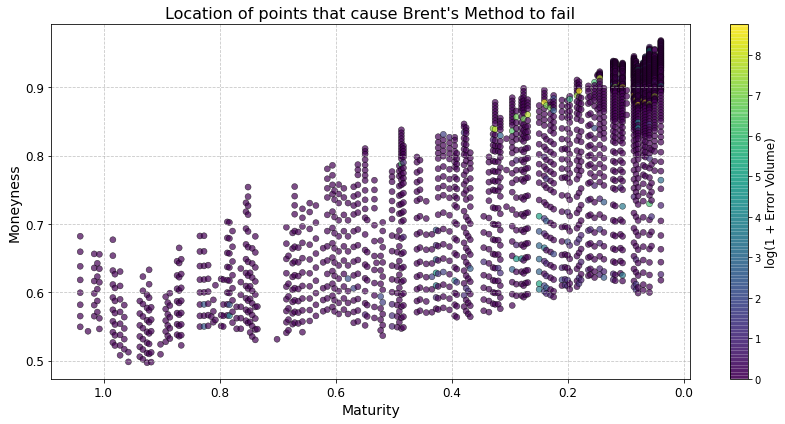

In [16]:
# Convert to log scale (use log1p to handle zeros safely)
log_error_volume = np.log1p(error_volume)

# Choose colormap
cmap = plt.cm.viridis

# Set the figure size
plt.figure(figsize=(12, 6))

# Scatter plot with color by log(error_volume)
scatter = plt.scatter(
    error_maturity,
    error_strike,
    c=log_error_volume,
    cmap=cmap,
    alpha=0.7,
    edgecolors='k',
    linewidths=0.5
)

# Add title and axis labels
plt.title("Location of points that cause Brent's Method to fail", fontsize=16)
plt.xlabel("Maturity", fontsize=14)
plt.ylabel("Moneyness", fontsize=14)

# Reverse the x-axis
plt.gca().invert_xaxis()

# Improve tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("log(1 + Error Volume)", fontsize=12)

# Final layout
plt.tight_layout()
plt.show()


August 31st, 2023
200.0
4655.0
4660.0
4665.0
4670.0
4675.0
4680.0
4690.0
4695.0
4700.0
4705.0
4710.0
4715.0
4720.0
4725.0
4730.0
4735.0
4740.0
4745.0
4750.0
4755.0
4760.0
4765.0
4770.0
4775.0
4780.0
4785.0
4790.0
4795.0
4800.0
4805.0
4810.0
4815.0
4820.0
4825.0
4830.0
4835.0
4840.0
4845.0
4850.0
4855.0
4860.0
4870.0
4875.0
4880.0
4890.0
4900.0
4910.0
4920.0
4925.0
4930.0
4940.0
4950.0
4960.0
4970.0
4975.0
4980.0
4990.0
5000.0
5010.0
5020.0
5025.0
5030.0
5040.0
5050.0
5075.0
5100.0
5125.0
5150.0
5175.0
5200.0
5225.0
5250.0
5275.0
5300.0
5350.0
5400.0
5450.0
5500.0
5600.0
5700.0
5800.0
5900.0
6000.0
6200.0
6400.0
6600.0
6800.0
7000.0
7200.0
7300.0


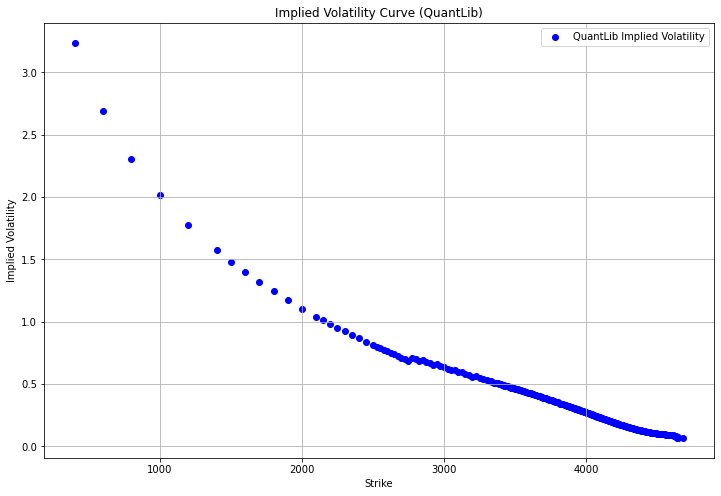

In [17]:
filtered_data_corrected = iv_df[iv_df["date"] == "2023-08-31"]
# Sort and prepare data
strikes = np.array(filtered_data_corrected["strike"].astype(float) / 1000)
order = np.argsort(strikes)
strikes2 = strikes[order]
bid = np.array(filtered_data_corrected["bid_prices"].astype(float))[order]
ask = np.array(filtered_data_corrected["ask_prices"].astype(float))[order]
mid_prices = (bid + ask) / 2

# Extract constants
underlying = float(filtered_data_corrected["underlying"].iloc[0])
maturity = float(filtered_data_corrected["maturities"].iloc[0])  # in years
r = float(filtered_data_corrected["r"].iloc[0])
dividends = float(filtered_data_corrected["q"].iloc[0])

expiry_date = ql.Date(15, 9, 2023)
# Set evaluation date
eval_date = ql.Date(31, 8, 2023)
ql.Settings.instance().evaluationDate = eval_date
print(eval_date)

# Construct curves and handles
calendar = ql.TARGET()
day_count = ql.Actual360()

spot_handle = ql.QuoteHandle(ql.SimpleQuote(underlying))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(eval_date, r, day_count))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(eval_date, dividends, day_count))
vol_handle = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(eval_date, calendar, 0.20, day_count))  # dummy vol
bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_ts, flat_ts, vol_handle)


# Calculate implied volatilities
implied_vols2 = []
for i in range(len(strikes2)):
    strike = strikes2[i]
    price = mid_prices[i]
    option = ql.EuropeanOption(ql.PlainVanillaPayoff(ql.Option.Put, strike),
                                    ql.EuropeanExercise(expiry_date))
    try:
        
        iv = option.impliedVolatility(price, bsm_process, 1e-4, 500, 1e-8, 4.0)
          
    except RuntimeError:
        print(strike)
        iv = np.nan
    implied_vols2.append(iv)

# Plot the IV curve
plt.figure(figsize=(12, 8))
plt.scatter(strikes2, implied_vols2, color="blue", label="QuantLib Implied Volatility")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")

plt.title("Implied Volatility Curve (QuantLib)")
plt.legend()
plt.grid(True)
plt.show()



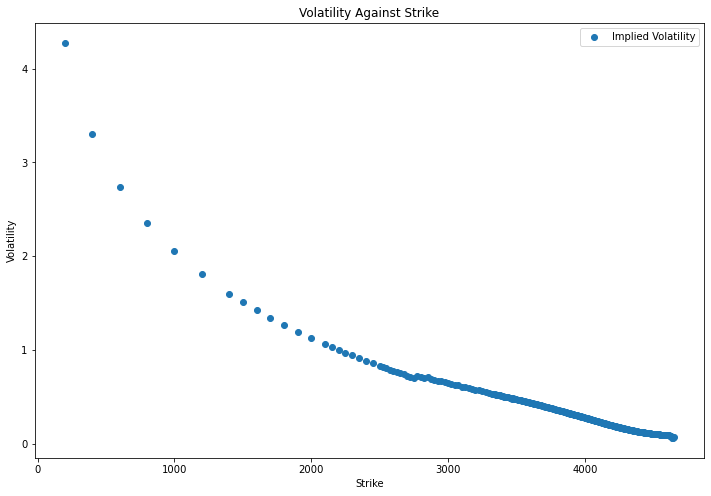

In [18]:
#Filter for a single day"s worth of data

#Implied volatility calculation via Brent"s method, modifie to avoid NANs so descent can occur
def implied_volatility(mid_price, underlying, maturity, strike, r, dividends):
    # Define objective function as the difference between Black-Scholes price and market price
    objective = lambda vol: BSModel(underlying, maturity, strike, r, dividends, vol) - mid_price
    # Use Brent"s method to find volatility
    try:
        return brentq(objective, 0.001, 20)
    except Exception as e:
        return -1

#already taken into account 
filtered_data_corrected = iv_df[iv_df["date"] == "2023-08-31"]
strikes = np.array(filtered_data_corrected["strike"].astype(float)/1000)
order = np.argsort(strikes)
strikes = np.array(filtered_data_corrected["strike"].astype(float)/1000)[order]
bid = np.array(filtered_data_corrected["bid_prices"].astype(float))[order]
ask = np.array(filtered_data_corrected["ask_prices"].astype(float))[order]

underlying = list(filtered_data_corrected["underlying"].astype(float))[0]
maturity = list(filtered_data_corrected["maturities"].astype(float))[0]
r=list(filtered_data_corrected["r"].astype(float))[0]
dividends=list(filtered_data_corrected["q"].astype(float))[0]

implied_vols1 = np.array([implied_volatility((bid+ask)[i]/2, underlying, maturity, strikes[i], r, dividends) for i in range(len(strikes))])
implied_vols = implied_vols1[implied_vols1 != -1].flatten()

#remove vals that lead to implied vols that are not physical
strikes = strikes[implied_vols1 != -1].flatten()
bid = bid[implied_vols1 != -1].flatten()
ask = ask[implied_vols1 != -1].flatten()
spread = (ask - bid)/2

#View the volatilities
plt.figure(figsize=(12, 8))
plt.scatter(strikes, implied_vols, label = "Implied Volatility")
plt.xlabel("Strike")
plt.ylabel("Volatility")
plt.title("Volatility Against Strike")
plt.legend()
plt.show()


2369654    2.097144
2369655    1.847372
2369656    1.636926
2369657    1.542900
2369658    1.455011
             ...   
2370018         NaN
2370019         NaN
2370020         NaN
2370021         NaN
2370022    2.404480
Name: impl_volatility, Length: 369, dtype: float64


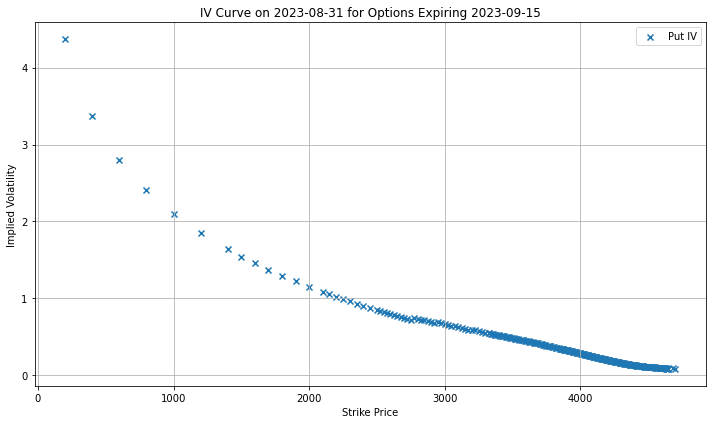

In [19]:
# Load the CSV
df = pd.read_csv("h2cysi0h1exq2scy.csv")

# Convert dates to datetime format
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Filter for the target date and expiration date
trade_date = pd.Timestamp("2023-08-31")
expiration_date = pd.Timestamp("2023-09-15")
filtered = df[(df["date"] == trade_date) & (df["exdate"] == expiration_date)]
filtered = filtered[~filtered["symbol"].str.contains("SPXW", na=False)]
print(filtered["impl_volatility"])
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered["strike_price"]/1000, filtered["impl_volatility"], label="Put IV", marker="x")

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("IV Curve on 2023-08-31 for Options Expiring 2023-09-15")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-22-54ebb1a7b4cc>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered["strike_k"] = filtered["strike_price"] / 1000


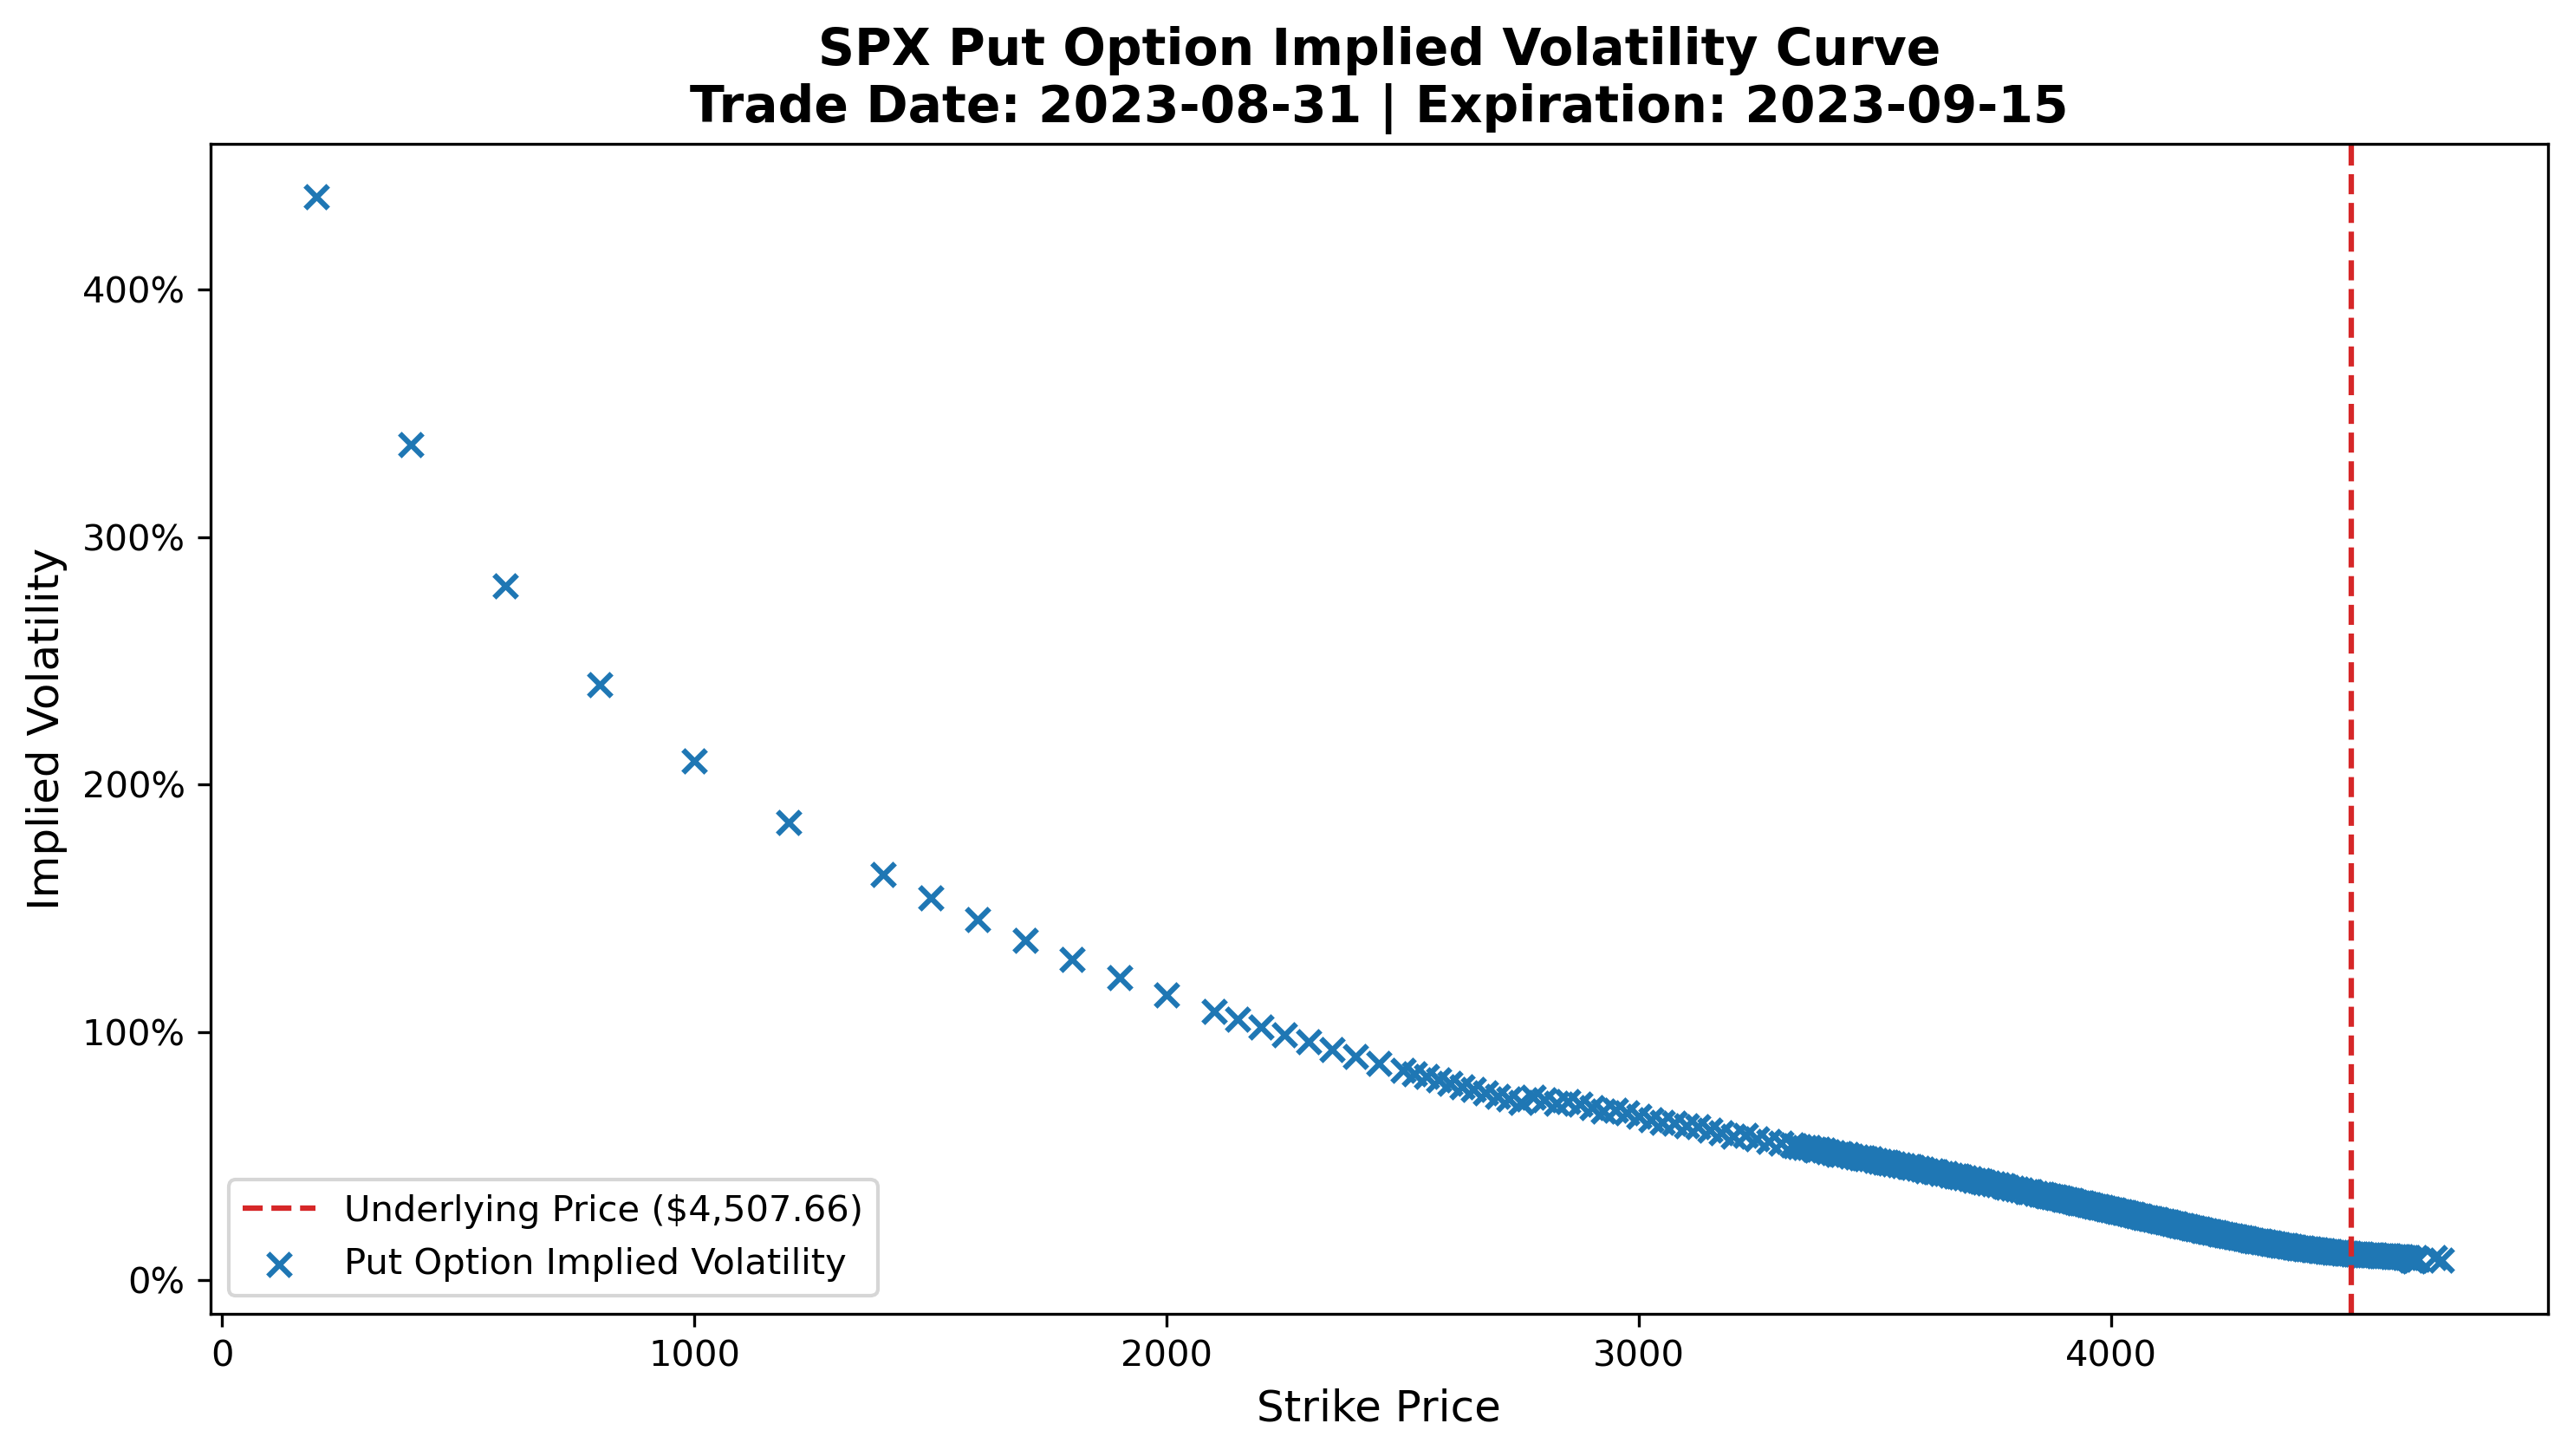

In [22]:
import matplotlib.ticker as mtick
# Load market data from CSV
df = pd.read_csv("h2cysi0h1exq2scy.csv")

# Convert date columns to datetime objects
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Define key analysis parameters
trade_date = pd.Timestamp("2023-08-31")
expiration_date = pd.Timestamp("2023-09-15")

# Filter dataset for target expiration and trading date
filtered = df[
    (df["date"] == trade_date) 
    & (df["exdate"] == expiration_date)
    & (~df["symbol"].str.contains("SPXW", na=False))
]

# Convert strike prices to thousands for readability
filtered["strike_k"] = filtered["strike_price"] / 1000

# Create professional figure setup
plt.figure(figsize=(10, 6), dpi=300)
ax = plt.gca()

# Plot implied volatility curve
ax.scatter(
    filtered["strike_k"],
    filtered["impl_volatility"],
    marker="x",
    s=40,
    color="#1f77b4",
    label="Put Option Implied Volatility"
)

# Add underlying price reference line
ax.axvline(
    x=underlying_price,
    color="#d62728",
    linestyle="--",
    linewidth=1.5,
    label=f"Underlying Price (${underlying_price:,.2f})"
)

# Formatting for academic publication
ax.set_xlabel("Strike Price", fontsize=12)
ax.set_ylabel("Implied Volatility", fontsize=12)
ax.set_title(
    f"SPX Put Option Implied Volatility Curve\n"
    f"Trade Date: {trade_date.date()} | Expiration: {expiration_date.date()}",
    fontsize=14,
    fontweight="bold"
)
ax.legend(loc="best", frameon=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format as percentages


plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout for footnote
plt.savefig("iv_curve_spx_analysis.pdf", bbox_inches="tight")  # Vector format for publications
plt.show()

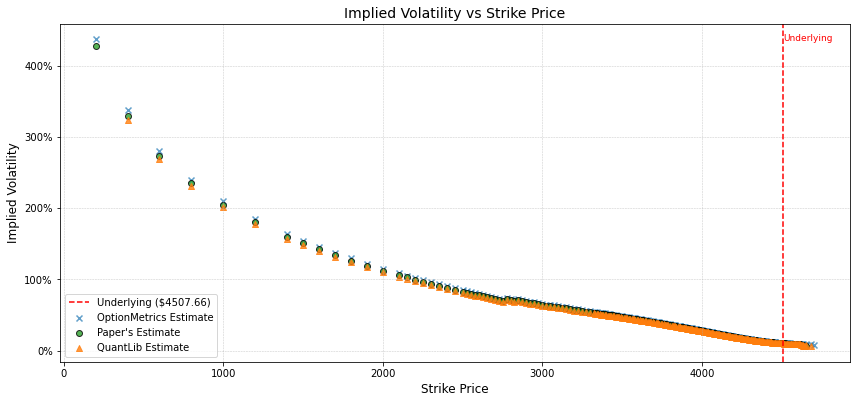

In [23]:


# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# OptionMetrics Estimate
ax.scatter(
    filtered["strike_price"] / 1000, filtered["impl_volatility"],
    label="OptionMetrics Estimate", 
    marker="x", color="tab:blue", alpha=0.7
)

# Paper's Estimate
ax.scatter(
    strikes, implied_vols, 
    label="Paper's Estimate", 
    marker="o", color="tab:green", edgecolor="black", alpha=0.8
)

# QuantLib Estimate
ax.scatter(
    strikes2, implied_vols2, 
    label="QuantLib Estimate", 
    marker="^", color="tab:orange", alpha=0.8
)

# Underlying Price Marker
ax.axvline(x=underlying_price, color="red", linestyle="--", linewidth=1.5, label=f"Underlying (${underlying_price:.2f})")
ax.text(underlying_price + 0.5, ax.get_ylim()[1]*0.95, "Underlying", color="red", fontsize=9)

# Labels & styling
ax.set_xlabel("Strike Price", fontsize=12)
ax.set_ylabel("Implied Volatility", fontsize=12)
ax.set_title("Implied Volatility vs Strike Price",
    fontsize=14
)
ax.legend(loc="best", frameon=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Format as percentages
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for caption or footnote
plt.savefig("iv_surface_comparison.pdf", bbox_inches="tight")  # Save as vector graphic
plt.show()


## Defining Local Volatility Models

In [24]:
#General Local volatility pricer

#Create a function that returns a function that takes in strike and returns volatility
def vol_func_creator_general(mid_prices, underlying, maturity, strikes, r, divs, func, p0):
    #Calculate implied volatilities
    implied_vols = [implied_volatility(mid_prices[i], underlying, maturity, strikes[i], r, divs) for i in range(len(strikes))]
    
    coeffs, _ = curve_fit(func, strikes, implied_vols, p0=p0)
    #Find the indices of the max and min values of the implied volatilities
    return lambda strike: func(strike, *coeffs)

def BSModel_with_vol_general(mid_prices, underlying, maturity, strike, r, dividends, func, p0):
    vol_func = vol_func_creator_general(mid_prices, underlying, maturity, strike, r, dividends, func, p0)
    volatility = vol_func(strike)
    # Ensure sensible volatility bounds
    volatility = np.array([max(0.001,i) for i in volatility])
    return BSModel(underlying, maturity, strike, r, dividends, volatility)

In [25]:
#General local volatility model simulator
def BSModel_General_Ideal(underlying, maturity, strike, r, dividends,func):
    return BSModel(underlying, maturity, strike, r, dividends, func(strike))

In [26]:
#All the Local volatility components

#local vol functions

def Bachelier_vol_func(strike, a = 2):
    return a / strike

def Cev_vol_func(strike, a = 2,b = 1):
        return a*strike**(b)

def Diff_vol_func(strike, a = 2,b = 1):
        return a - b* np.exp(r*maturity)/strike

#Array:
Local_dict = {"Bachelier":[Bachelier_vol_func, [1]],"Cev":[Cev_vol_func, [1,1]],"Diff":[Diff_vol_func, [1,1]]}


## Fitting of Local Volatility Models on Simulated Data

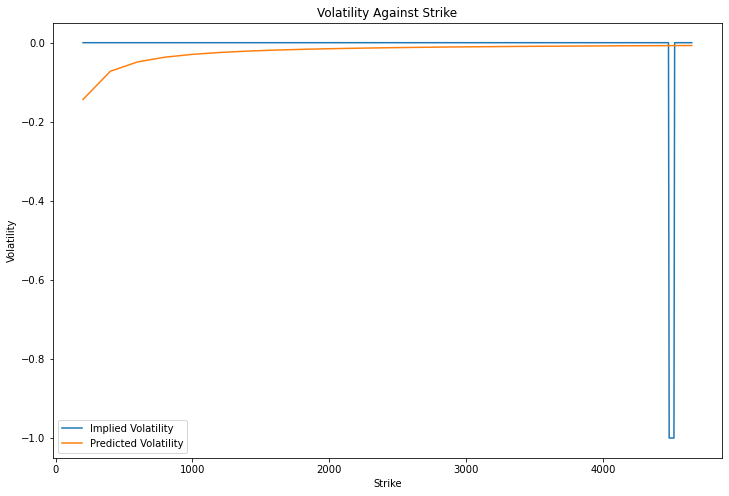

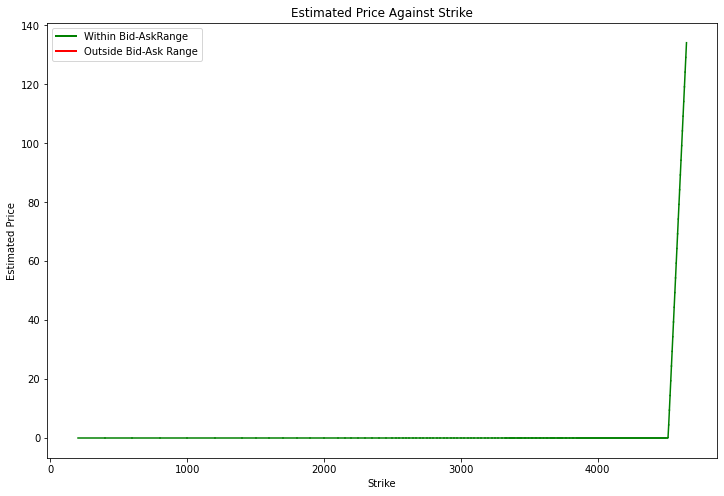

The percentage of fitted prices that lie within the original bid-askspread is 100.0%


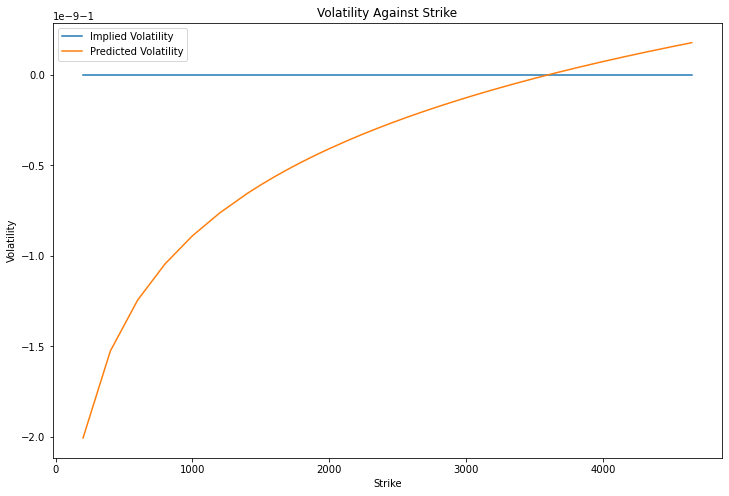

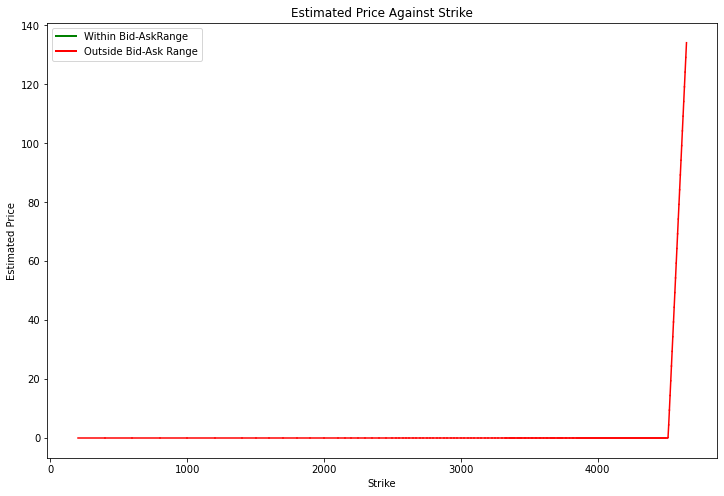

The percentage of fitted prices that lie within the original bid-askspread is 0.0%


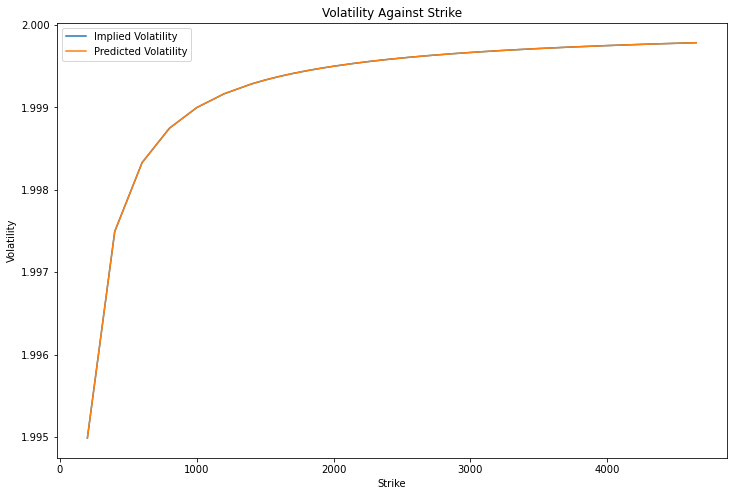

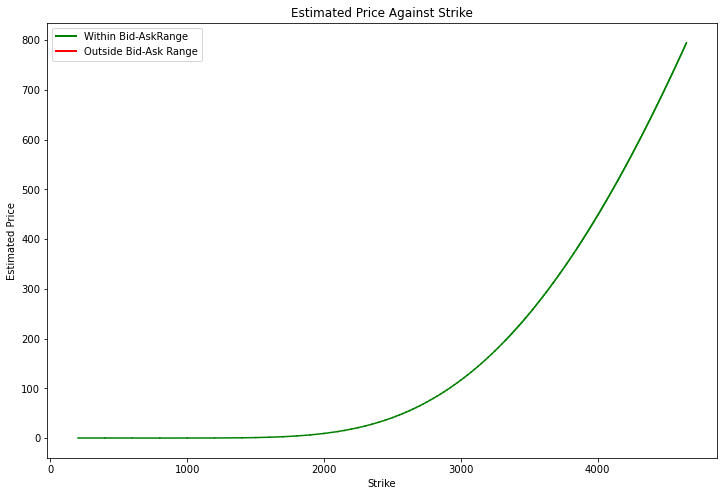

The percentage of fitted prices that lie within the original bid-askspread is 100.0%


In [27]:
#Local vol models
def local_vol_test_simulated(name):
    #simulate and create data
    computed_price = BSModel_General_Ideal(underlying, maturity, strikes, r, dividends, Local_dict[name][0])
    tempbid, tempask = computed_price - spread , computed_price + spread
    
    #Compute implied volatilities
    implied_vols = [implied_volatility(computed_price[i], underlying, maturity, strikes[i], r, dividends) for i in range(len(strikes))]
    
    #Create volatility function
    vol_func = vol_func_creator_general(computed_price, underlying, maturity, strikes, r, dividends, Local_dict[name][0], Local_dict[name][1])

    #Predicted volatilies
    predicted_vols = vol_func(strikes)
    
    #Plot vols : 
    plt.figure(figsize=(12, 8))
    #sorted due to mononicity of implicit volatility under these models
    plt.plot(strikes, (implied_vols), label = "Implied Volatility")
    plt.plot(strikes, (predicted_vols), label = "Predicted Volatility")
    plt.xlabel("Strike")
    plt.ylabel("Volatility")
    plt.title("Volatility Against Strike")
    plt.legend()
    plt.show()
    
    #fit prices using the modified Black-Scholes Model
    estimated_price = BSModel_with_vol_general(computed_price, underlying, maturity, strikes, r, dividends, Local_dict[name][0], Local_dict[name][1])
    
    #Price is monotonic in terms of strike
    tempbid = np.sort(tempbid)
    tempask = np.sort(tempask)
    
    #plot vals
    plt.figure(figsize=(12, 8))
    for i in range(len(strikes) - 1):
        color = "green" if tempbid[i] < estimated_price[i] < tempask[i] else "red"
        plt.plot(strikes[i:i+2], estimated_price[i:i+2], color=color)
    
    # Labeling the plot
    plt.xlabel("Strike")
    plt.ylabel("Estimated Price")
    plt.title("Estimated Price Against Strike")
    legend_elements = [Line2D([0], [0], color="green", lw=2, label="Within Bid-AskRange"), Line2D([0], [0], color="red", lw=2, label="Outside Bid-Ask Range")]
    plt.legend(handles=legend_elements, loc="upper left")
    plt.show()
    
    #Compute the percent of the fitted prices that fall between the original bidand ask of the modified Black-Scholes Model
    accuracy = sum([tempbid[i] < estimated_price[i] < tempask[i] for i in range(len(estimated_price))])/len(estimated_price) *100
    print(f"The percentage of fitted prices that lie within the original bid-askspread is {accuracy}%")
    return accuracy
    
for i in Local_dict:
    local_vol_test_simulated(i)
    
    

In [28]:
#Summary

#Appears to work quite well

## Implied Volatility fitting for a single Day and Expiry

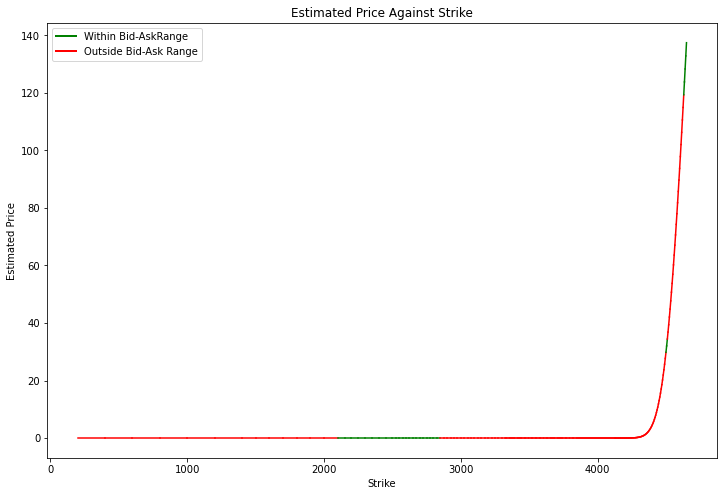

The percentage of fitted prices that lie within the original bid-askspread is 10.431654676258994%


In [29]:
#Black Scholes 

accuracies = []

def model(strikes, volatility):
    return BSModel(underlying, maturity, strikes, r, dividends, volatility)

initial_guess = [0.2]

params, covariance = curve_fit(model, strikes, (bid+ask)/2, p0=initial_guess)

#fit prices using the modified Black-Scholes Model
estimated_price = BSModel(underlying, maturity, strikes, r, dividends, params[0])

estimated_price = np.sort(estimated_price)
tempbid = bid
tempask = ask

plt.figure(figsize=(12, 8))
for i in range(len(strikes) - 1):
    color = "green" if tempbid[i] < estimated_price[i] < tempask[i] else "red"
    plt.plot(strikes[i:i+2], estimated_price[i:i+2], color=color)
# Labeling the plot
plt.xlabel("Strike")
plt.ylabel("Estimated Price")
plt.title("Estimated Price Against Strike")
legend_elements = [Line2D([0], [0], color="green", lw=2, label="Within Bid-AskRange"), Line2D([0], [0], color="red", lw=2, label="Outside Bid-Ask Range")]
plt.legend(handles=legend_elements, loc="upper left")
plt.show()
#Compute the percent of the fitted prices that fall between the original bidand ask of the modified Black-Scholes Model
accuracy = sum([tempbid[i] < estimated_price[i] < tempask[i] for i in range(len(estimated_price))])/len(estimated_price) *100
accuracies.append(accuracy)
print(f"The percentage of fitted prices that lie within the original bid-askspread is {accuracy}%")


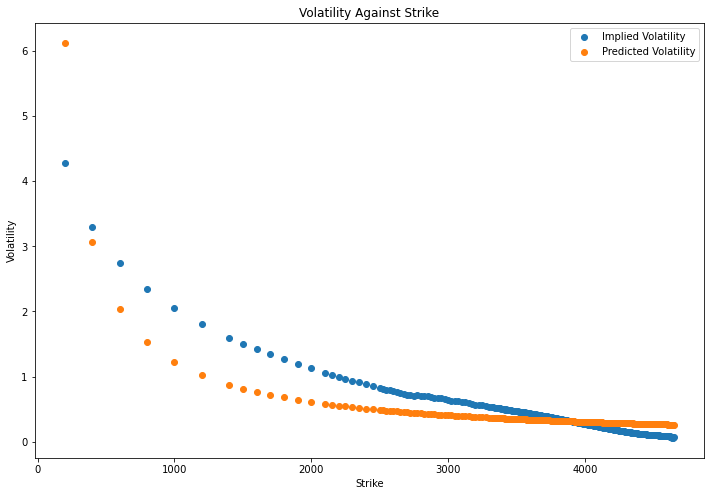

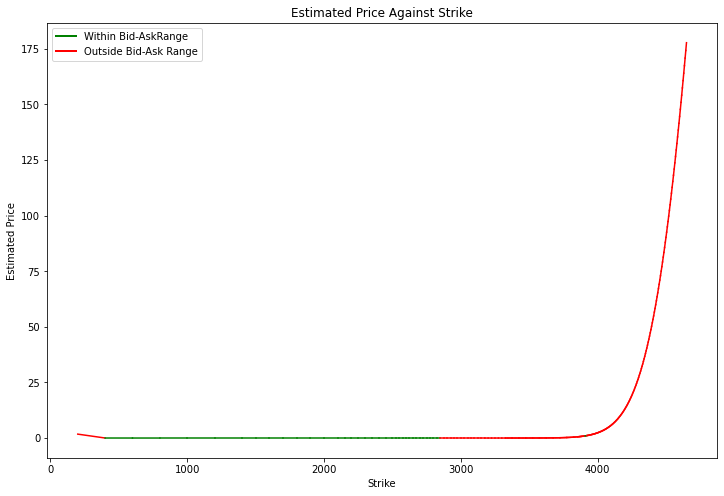

The percentage of fitted prices that lie within the original bid-askspread is 12.949640287769784%


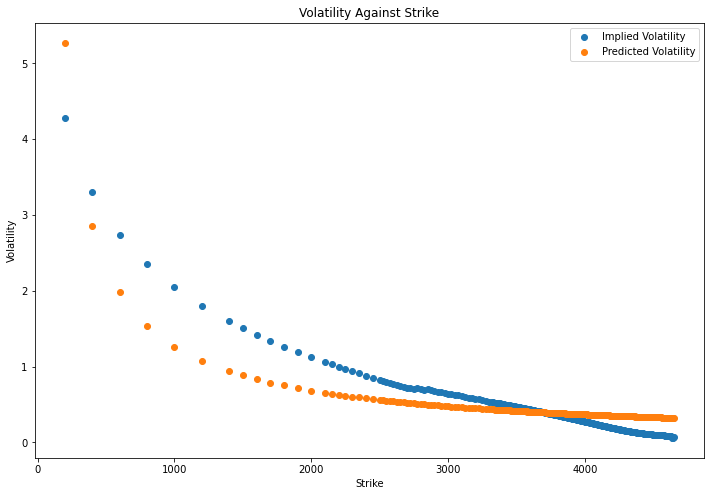

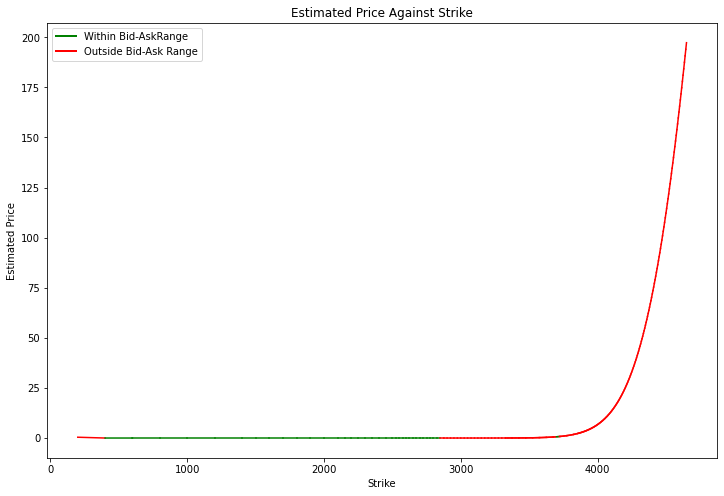

The percentage of fitted prices that lie within the original bid-askspread is 12.949640287769784%


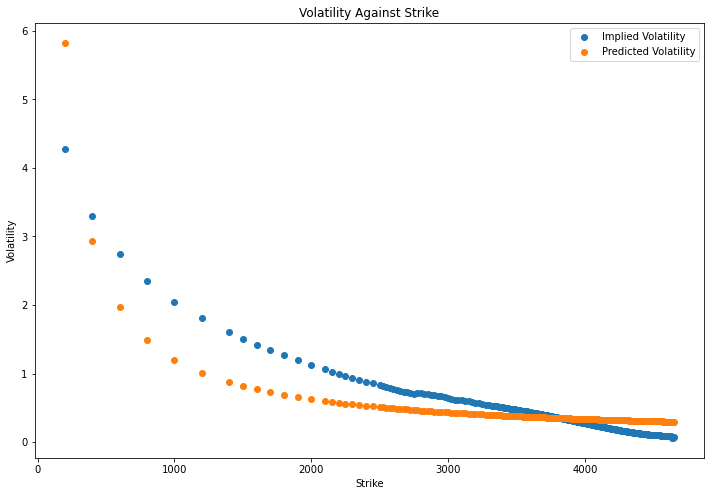

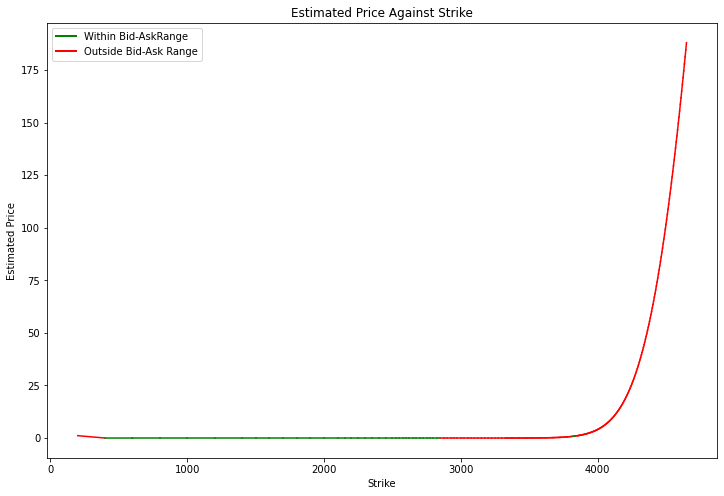

The percentage of fitted prices that lie within the original bid-askspread is 13.309352517985612%


In [30]:
#Local vol models
def local_vol_test(name):
    
    
    mid_price = (bid+ask)/2
    
    #Compute implied volatilities
    implied_vols = [implied_volatility(mid_price[i], underlying, maturity, strikes[i], r, dividends) for i in range(len(strikes))]
    
    #Create volatility function
    vol_func = vol_func_creator_general(mid_price, underlying, maturity, strikes, r, dividends, Local_dict[name][0], Local_dict[name][1])

    #Predicted volatilies
    predicted_vols = vol_func(strikes)
    
    #Plot vols : 
    plt.figure(figsize=(12, 8))
    plt.scatter(strikes, (implied_vols), label = "Implied Volatility")
    plt.scatter(strikes, (predicted_vols), label = "Predicted Volatility")
    plt.xlabel("Strike")
    plt.ylabel("Volatility")
    plt.title("Volatility Against Strike")
    plt.legend()
    plt.show()
    
    #fit prices using the modified Black-Scholes Model
    estimated_price = BSModel_with_vol_general(mid_price, underlying, maturity, strikes, r, dividends, Local_dict[name][0], Local_dict[name][1])
    
    tempbid = (bid)
    tempask = (ask)
    
    #plot vals
    plt.figure(figsize=(12, 8))
    for i in range(len(strikes) - 1):
        color = "green" if tempbid[i] < estimated_price[i] < tempask[i] else "red"
        plt.plot(strikes[i:i+2], estimated_price[i:i+2], color=color)
    
    # Labeling the plot
    plt.xlabel("Strike")
    plt.ylabel("Estimated Price")
    plt.title("Estimated Price Against Strike")
    legend_elements = [Line2D([0], [0], color="green", lw=2, label="Within Bid-AskRange"), Line2D([0], [0], color="red", lw=2, label="Outside Bid-Ask Range")]
    plt.legend(handles=legend_elements, loc="upper left")
    plt.show()
    
    #Compute the percent of the fitted prices that fall between the original bidand ask of the modified Black-Scholes Model
    accuracy = sum([tempbid[i] < estimated_price[i] < tempask[i] for i in range(len(estimated_price))])/len(estimated_price)*100
    accuracies.append(accuracy)
    print(f"The percentage of fitted prices that lie within the original bid-askspread is {accuracy}%")
    return accuracy
    
for i in Local_dict:
    local_vol_test(i)
    
    

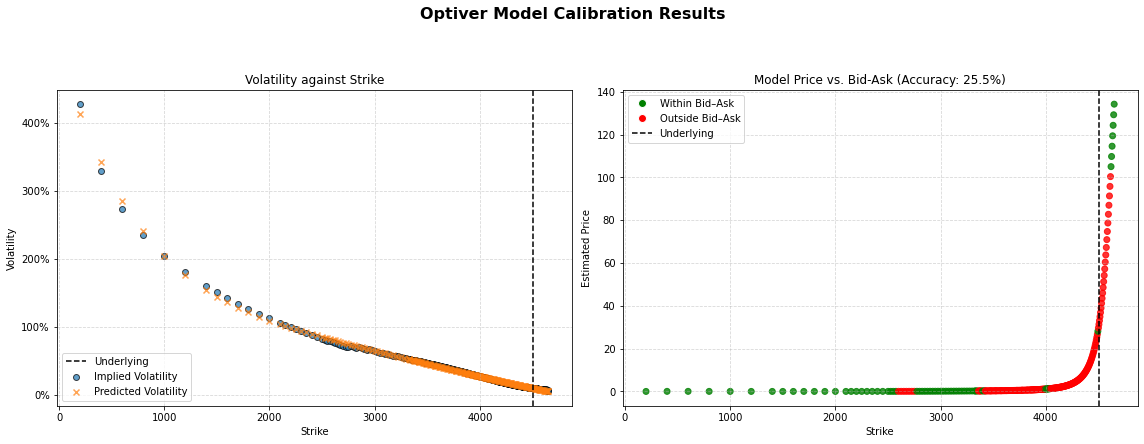

In [31]:
#Victor Model + exp

mid_price = (bid+ask)/2

#Create a function that returns a function that takes in strike and returns volatility
def vol_func_creator(mid_prices, underlying, maturity, strikes, r, divs):
    #Calculate implied volatilities
    implied_vols = [implied_volatility(mid_prices[i], underlying, maturity, strikes[i], r, divs) for i in range(len(strikes))]
    #Find the indices of the max and min values of the implied volatilities
    mindex = implied_vols.index(min(implied_vols))
    maxdex = implied_vols.index(max(implied_vols))
    #Detect U or n shape and fit a piecewise polynomial regression if needed, 
    #otherwise use a polynomial regression
    if 0.175 < mindex/len(implied_vols) < 0.825:
        def piecewiseregression(x):
            # Polynomial fit for left and right segments
            poly1 = np.poly1d(np.polyfit(strikes[:mindex+1], implied_vols[:mindex+1], 5))
            poly2 = np.poly1d(np.polyfit(strikes[mindex-1:], implied_vols[mindex-1:], 5))
            # Select boundaries for the transition between both regressions
            left_bound = strikes[mindex - 1]
            right_bound = strikes[mindex + 1]
            # Ensure smoothness of volatility function
            def smooth_blend(x):
                # Values and derivatives at the boundaries
                p1_val, p1_deriv = poly1(left_bound), poly1.deriv()(left_bound)
                p2_val, p2_deriv = poly2(right_bound), poly2.deriv()(right_bound)
                # Normalise x
                t = (x - left_bound) / (right_bound - left_bound)
                # Hermite cubic interpolation for smooth blending
                h00 = (1 + 2 * t) * (1 - t)**2
                h10 = t * (1 - t)**2
                h01 = t**2 * (3 - 2 * t)
                h11 = t**2 * (t - 1)
                # Calculate smooth transition between poly1 and poly2
                return h00 * p1_val + h10 * (right_bound - left_bound) * p1_deriv + h01 * p2_val + h11 * (right_bound - left_bound) * p2_deriv
            # Apply the function with blending
            return np.where((x >= left_bound) & (x <= right_bound), smooth_blend(x), np.where(x < strikes[mindex], poly1(x), poly2(x)))
        return piecewiseregression
    elif 0.175 < implied_vols.index(max(implied_vols))/len(implied_vols) < 0.825:
        def piecewiseregression(x):
            # Polynomial fit for left and right segments
            poly1 = np.poly1d(np.polyfit(strikes[:maxdex+1], implied_vols[:maxdex+1], 5))
            poly2 = np.poly1d(np.polyfit(strikes[maxdex-1:], implied_vols[maxdex-1:], 5))
            # Select boundaries for the transition between both regressions
            left_bound = strikes[maxdex - 1]
            right_bound = strikes[maxdex + 1]
            # Ensure smoothness of volatility function
            def smooth_blend(x):
                # Values and derivatives at the boundaries
                p1_val, p1_deriv = poly1(left_bound), poly1.deriv()(left_bound)
                p2_val, p2_deriv = poly2(right_bound), poly2.deriv()(right_bound)
                # Normalise x
                t = (x - left_bound) / (right_bound - left_bound)
                # Hermite cubic interpolation for smooth blending
                h00 = (1 + 2 * t) * (1 - t)**2
                h10 = t * (1 - t)**2
                h01 = t**2 * (3 - 2 * t)
                h11 = t**2 * (t - 1)
                # Calculate smooth transition between poly1 and poly2
                return h00 * p1_val + h10 * (right_bound - left_bound) *p1_deriv + h01 * p2_val + h11 * (right_bound - left_bound) * p2_deriv
            # Apply the function with blending
            return np.where((x >= left_bound) & (x <= right_bound), smooth_blend(x), np.where(x < strikes[maxdex], poly1(x), poly2(x)))
        return piecewiseregression
    else:
        #Use a regular polynomial regression if no significant U or n shape is detected
        coeffs = np.polyfit(strikes, implied_vols, 5)
        return np.poly1d(coeffs)

def BSModel_with_vol(mid_prices, underlying, maturity, strike, r, dividends):
    vol_func = vol_func_creator(mid_prices, underlying, maturity, strike, r, dividends)
    volatility = vol_func(strike)
    # Ensure sensible volatility bounds
    volatility = np.array([max(0.001,i) for i in volatility])
    return BSModel(underlying, maturity, strike, r, dividends, volatility)

implied_vols = [implied_volatility(mid_price[i], underlying, maturity, strikes[i], r, dividends) 
                for i in range(len(strikes))]
vol_func = vol_func_creator(mid_price, underlying, maturity, strikes, r, dividends)
predicted_vols = vol_func(strikes)

# Compute estimated prices
estimated_prices = BSModel_with_vol(mid_price, underlying, maturity, strikes, r, dividends)

# Compute accuracy
accuracy = np.mean([(bid[i] < estimated_prices[i] < ask[i]) 
                    for i in range(len(strikes))]) * 100
accuracies.append(accuracy)
# Create combined figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=False)
fig.suptitle("Optiver Model Calibration Results", fontsize=16, fontweight='bold', y=1.02)
for ax in axs:
    ax.axvline(underlying, linestyle='--', color='black', label='Underlying')


axs[0].scatter(strikes, implied_vols, label="Implied Volatility", alpha=0.7, edgecolor='k')
axs[0].scatter(strikes, predicted_vols, label="Predicted Volatility", alpha=0.7, marker='x')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Volatility")
axs[0].set_title("Volatility against Strike")
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)


# color each point by whether it lies inside the bid-ask
colors = ['green' if bid_i < est < ask_i else 'red' 
          for bid_i, est, ask_i in zip(bid, estimated_prices, ask)]
axs[1].scatter(strikes, estimated_prices, c=colors, alpha=0.8)
axs[1].set_xlabel("Strike")
axs[1].set_ylabel("Estimated Price")
axs[1].set_title(f"Model Price vs. Bid-Ask (Accuracy: {accuracy:.1f}%)")
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Within Bid–Ask', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Outside Bid–Ask', markerfacecolor='red', markersize=8),
    Line2D([0], [0], linestyle='--', color='black', label='Underlying')
]
axs[1].legend(handles=legend_elems, loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


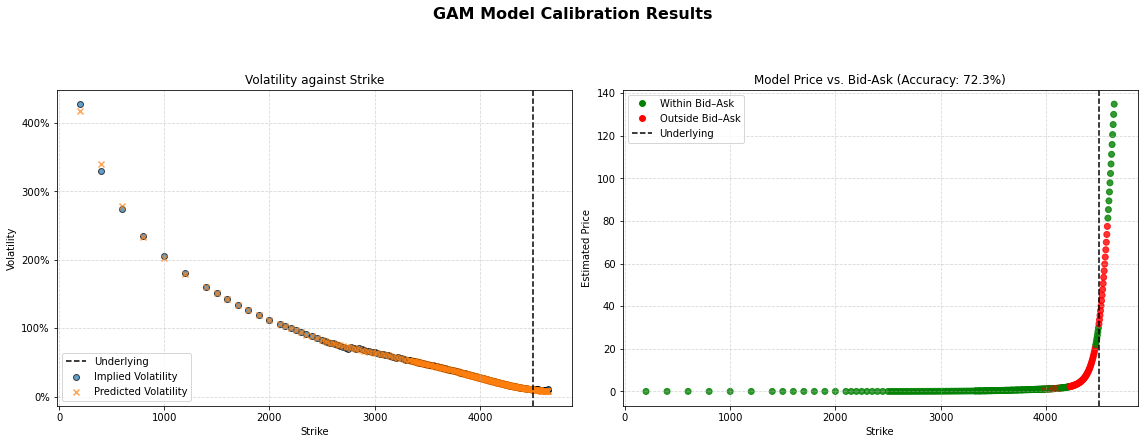

In [32]:
#GAM

def vol_func_creator_splines(mid_prices, underlying, maturity, strikes, r, divs):
    """
    Create a GAM (Generalized Additive Model) to fit strikes against implied volatilities.

    Parameters:
        mid_prices (list or array): Mid-market option prices.
        underlying (float): Underlying asset price.
        maturity (float): Time to maturity (in years).
        strikes (list or array): Option strike prices.
        r (float): Risk-free interest rate.
        divs (float): Dividend yield.

    Returns:
        gam (LinearGAM): Fitted GAM model for strikes vs. implied volatilities.
    """
    # Calculate implied volatilities
    implied_vols = [
        implied_volatility(mid_prices[i], underlying, maturity, strikes[i], r, divs)
        for i in range(len(strikes))
    ]

    # Ensure inputs are numpy arrays for GAM compatibility
    strikes = np.array(strikes).reshape(-1, 1)  # Reshape for single predictor
    implied_vols = np.array(implied_vols)

    # Create and fit the GAM
    gam = LinearGAM(s(0, lam=0.2)).fit(strikes, implied_vols)

    return gam

# Black-Scholes model using spline-based volatility
def BSModel_with_vol_splines(mid_prices, underlying, maturity, strike, r, dividends):
    vol_func = vol_func_creator_splines(mid_prices, underlying, maturity, strike, r, dividends)
    volatility = vol_func.predict(np.array(strikes).reshape(-1, 1))
    # Ensure sensible volatility bounds
    volatility = np.maximum(volatility, 0.001)
    return BSModel(underlying, maturity, strike, r, dividends, volatility)

#Compute implied volatilities
implied_vols = [implied_volatility(mid_price[i], underlying, maturity,strikes[i], r, 0) for i in range(len(strikes))]

#Create volatility function
vol_func = vol_func_creator_splines(mid_price, underlying, maturity, strikes, r, dividends)

#Predicted volatilies
predicted_vols = vol_func.predict(np.array(strikes).reshape(-1, 1))

#fit prices using the modified Black-Scholes Model
estimated_prices = BSModel_with_vol_splines(mid_price, underlying, maturity, strikes,r, dividends)
# Compute accuracy
accuracy = np.mean([(bid[i] < estimated_prices[i] < ask[i]) 
                    for i in range(len(strikes))]) * 100
accuracies.append(accuracy)
# Create combined figure
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=False)
fig.suptitle("GAM Model Calibration Results", fontsize=16, fontweight='bold', y=1.02)
for ax in axs:
    ax.axvline(underlying, linestyle='--', color='black', label='Underlying')


axs[0].scatter(strikes, implied_vols, label="Implied Volatility", alpha=0.7, edgecolor='k')
axs[0].scatter(strikes, predicted_vols, label="Predicted Volatility", alpha=0.7, marker='x')
axs[0].set_xlabel("Strike")
axs[0].set_ylabel("Volatility")
axs[0].set_title("Volatility against Strike")
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)


# color each point by whether it lies inside the bid-ask
colors = ['green' if bid_i < est < ask_i else 'red' 
          for bid_i, est, ask_i in zip(bid, estimated_prices, ask)]
axs[1].scatter(strikes, estimated_prices, c=colors, alpha=0.8)
axs[1].set_xlabel("Strike")
axs[1].set_ylabel("Estimated Price")
axs[1].set_title(f"Model Price vs. Bid-Ask (Accuracy: {accuracy:.1f}%)")
legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Within Bid–Ask', markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Outside Bid–Ask', markerfacecolor='red', markersize=8),
    Line2D([0], [0], linestyle='--', color='black', label='Underlying')
]
axs[1].legend(handles=legend_elems, loc='upper left')
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
#Summary
accuracydf = pd.DataFrame({"Names":["Black Scholes", "Bachelier", "Cev", "Diff", "Victor's Optiver Model", "GAM model"],"Accuracies":accuracies})
accuracydf

## Implied Volatility fitting over multiple days and for a given expiry

In [ ]:
#Defined empty dict
accuracies = {"Black Scholes":0,"Bachelier":0, "Cev":0,"Diff":0, "Victor's Optiver Model":0, "GAM model":0}

count = 0
initial_guess = [0.2]

for dt, group in iv_df.groupby(iv_df["date"]):
    count += 1
    filtered_data_corrected = group
    
    strikes = np.array(filtered_data_corrected["strike"].astype(float)/1000)
    order = np.argsort(strikes)
    strikes = np.array(filtered_data_corrected["strike"].astype(float)/1000)[order]
    bid = np.array(filtered_data_corrected["bid_prices"].astype(float))[order]
    ask = np.array(filtered_data_corrected["ask_prices"].astype(float))[order]

    underlying = list(filtered_data_corrected["underlying"].astype(float))[0]
    maturity = list(filtered_data_corrected["maturities"].astype(float))[0]
    r=list(filtered_data_corrected["r"].astype(float))[0]
    dividends=list(filtered_data_corrected["q"].astype(float))[0]

    implied_vols1 = np.array([implied_volatility((bid+ask)[i]/2, underlying, maturity, strikes[i], r, dividends) for i in range(len(strikes))])
    implied_vols = implied_vols1[implied_vols1 != -1].flatten()
    strikes = strikes[implied_vols1 != -1].flatten()
    bid = bid[implied_vols1 != -1].flatten()
    ask = ask[implied_vols1 != -1].flatten()
    mid_price = (bid+ask)/2
    
    #BS
    params, covariance = curve_fit(model, strikes, (bid+ask)/2, p0=initial_guess)
    #fit prices using the modified Black-Scholes Model
    estimated_price = BSModel(underlying, maturity, strikes, r, dividends, params[0])
    
    #Compute the percent of the fitted prices that fall between the original bidand ask of the modified Black-Scholes Model
    accuracy = sum([bid[i] < estimated_price[i] < ask[i] for i in range(len(estimated_price))])/len(estimated_price) *100
    accuracies["Black Scholes"] += accuracy
    
    #locals
    for name in Local_dict:
        #fit prices using the modified Black-Scholes Model
            try:
                estimated_price = BSModel_with_vol_general(mid_price, underlying, maturity, strikes, r, dividends, Local_dict[name][0], Local_dict[name][1])

                accuracy = sum([bid[i] < estimated_price[i] < ask[i] for i in range(len(estimated_price))])/len(estimated_price)*100
                accuracies[name] += accuracy
            except:
                print(maturity)
    
    #Victor model:
    estimated_price = BSModel_with_vol(mid_price, underlying, maturity, strikes,r, dividends)
    accuracy = sum([bid[i] < estimated_price[i] < ask[i] for i in range(len(estimated_price))])/len(estimated_price)*100
    accuracies["Victor's Optiver Model"] += accuracy
    
    #GAM model
    estimated_price = BSModel_with_vol_splines(mid_price, underlying, maturity, strikes,r, dividends)
    accuracy = sum([bid[i] < estimated_price[i] < ask[i] for i in range(len(estimated_price))])/len(estimated_price)*100
    accuracies["GAM model"] += accuracy

In [ ]:
accuracydf = pd.DataFrame({k: [v / 252] for k, v in accuracies.items()})
accuracydf

# Chapter 2: Fractal Market Hypothesis and its consequences

## Evidence for the FMH

In [ ]:

# Load data
data = pd.read_csv("eclqezarx3ry3dbg.csv", parse_dates=["date"])
data.set_index("date", inplace=True)

# Compute daily log returns
prices = data["close"]
log_returns = np.log(prices / prices.shift(1)).dropna()

fig, ax = plt.subplots(figsize=(12, 7))

# Histogram
counts, bins, _ = ax.hist(
    log_returns, bins=50, density=True, alpha=0.6,
    edgecolor="black", label="Log Return Histogram"
)

# Best-fit Normal distribution
mu, sigma = log_returns.mean(), log_returns.std()
pdf = stats.norm.pdf(bins, mu, sigma)
ax.plot(bins, pdf, 'r-', linewidth=2, label=f"Normal PDF\n($\\mu$ = {mu:.4f}, $\\sigma$ = {sigma:.4f})")

# Labels and formatting
ax.set_title("Histogram of Daily Log Returns with Fitted Normal PDF", fontsize=14)
ax.set_xlabel("Log Return", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.grid(True)
ax.legend(fontsize=11)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))

# QQ plot
stats.probplot(log_returns, dist="norm", plot=ax)
ax.get_lines()[1].set_color("red")  # Change theoretical line to red

# Labels and formatting
ax.set_title("QQ Plot of Daily Log Returns vs. Normal Distribution", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)
ax.grid(True)
fig.tight_layout()
plt.show()

# Normality Test
stat, p_value = stats.normaltest(log_returns)
print("Normality Test (D'Agostino and Pearson):")
print(f"  Test Statistic: {stat:.4f}")
print(f"  p-value       : {p_value:.4e}")

if p_value < 0.05:
    print("  Result        : Reject null hypothesis (data is not normally distributed)")
else:
    print("  Result        : Fail to reject null hypothesis (data may be normally distributed)")


In [ ]:
filtered_data1 = merged_data[merged_data["date"] == "2022-08-31"].copy()
nyse = tc.get_calendar("XNYS")

# Ensure datetime with timezone
filtered_data1["date"] = pd.to_datetime(filtered_data1["date"]).dt.tz_localize("UTC")
filtered_data1["exdate"] = pd.to_datetime(filtered_data1["exdate"]).dt.tz_localize("UTC")
min_date = filtered_data1["date"].min()
max_date = filtered_data1["exdate"].max()

# Generate all NYSE sessions in range
sessions = nyse.sessions_in_range(min_date, max_date)

def weighted_maturity(start, end):

    # All days in the range (excluding end)
    all_days = pd.date_range(start=start, end=end - pd.Timedelta(days=1), freq="D", tz="UTC")

    # Trading days in the range
    trading_days = [day for day in sessions if start <= day < end]

    n_trading_days = len(trading_days)
    n_total_days = len(all_days)
    n_non_trading_days = n_total_days - n_trading_days

    # Weighted maturity calculation
    maturity = (n_trading_days + 0.25 * n_non_trading_days) / ((3 * 252 + 365)/4)
    return maturity

filtered_data1["maturity"] = filtered_data1.apply(
    lambda row: weighted_maturity(row["date"], row["exdate"]),
    axis=1
)
unique_date = filtered_data1["date"].iloc[0]

# Step 2: Get the matching row from r_only_df
r_row = r_only_df[r_only_df["date"] == unique_date].iloc[0]

# Step 3: Add all columns from r_row (except 'date') to filtered_data as constants
for col in r_only_df.columns:
    if col != "date":
        filtered_data1[col] = r_row[col]

print(filtered_data1)

def implied_volatility(mid_price, underlying, maturity, strike, r, dividends,volume):
    global error_maturity
    global error_strike
    global error_volume
    # Define objective function as the difference between Black-Scholes price and market price
    objective = lambda vol: BSModel(underlying, maturity, strike, r, dividends, vol) - mid_price
    # Use Brent"s method to find volatility
    try:
        return brentq(objective, 0.01,20)
    except Exception as e:
        error_maturity.append(maturity)
        error_strike.append(underlying/strike)
        error_volume.append(volume)
        vols = np.linspace(0, 2, 500)

        # Compute the price differences
        diffs = [BSModel(underlying, maturity, strike, r, dividends, vol) - mid_price for vol in vols]
        
        return np.nan

#Compute volatility
results1 = []
for exdate, group in filtered_data1.groupby("exdate"):
    #print(date)
    underlying_price = group["close"].iloc[0]  # Get underlying price for the date
    strikes = group["strike_price"].values
    maturities = group["maturity"].values
    mid_prices = group["mid_price"].values
    bid_prices = group["best_bid"].values
    ask_prices = group["best_offer"].values
    r = group["median_r"].values
    q = group["estimated_q"].values
    volume = group["volume"].values

    # Compute implied volatilities for all strikes
    implied_vols = [
        implied_volatility(mid_prices[i], underlying_price, maturities[i], strikes[i]/1000, r[i], q[i], volume[i])
        for i in range(len(strikes))
    ]
    
    # Store results as a DataFrame
    result1 = pd.DataFrame({
        "exdate": exdate,
        "strike": strikes,
        "implied_volatility": implied_vols,
        "bid_prices" : bid_prices,
        "ask_prices" : ask_prices,
        "underlying" : underlying_price,
        "maturities" : maturities,
        "r":r,
        "q":q
        
    })
    results1.append(result1)

# Combine all results into a single DataFrame
iv_df1 = pd.concat(results1, ignore_index=True)
print(iv_df1)

def implied_volatility(mid_price, underlying, maturity, strike, r, dividends):
    # Define objective function as the difference between Black-Scholes price and market price
    objective = lambda vol: BSModel(underlying, maturity, strike, r, dividends, vol) - mid_price
    # Use Brent"s method to find volatility
    try:
        return brentq(objective, 0.001, 20)
    except Exception as e:
        return -1

In [ ]:
iv_df1["k"] = np.log((iv_df1["strike"]/1000)/(iv_df1["underlying"] * np.exp((iv_df1["r"]-iv_df1["q"]) * iv_df1["maturities"])))

#Approximate the first finite difference

g = iv_df1.sort_values("k")

unique_maturities = iv_df1["maturities"].unique()

differences = []
for maturity in unique_maturities:
    df_date = iv_df1[ iv_df1["maturities"] == maturity ].copy()
    
    #Compute above and below bits
    above = df_date.iloc[list((df_date["k"] + 0.01).abs().argsort())[0]]
    below = df_date.iloc[list((df_date["k"] - 0.01).abs().argsort())[0]]

    difference = (above["implied_volatility"] - below["implied_volatility"]) / (above["k"] - below["k"])
    differences.append(-difference)

mask = ~np.isnan(unique_maturities) & ~np.isnan(np.array(differences))

# Apply mask
x = np.log(unique_maturities[mask])
y = np.log(np.array(differences)[mask])

result = linregress(x, y)
b       = result.slope              
alpha   = result.intercept          
a       = np.exp(alpha)             
p_value = result.pvalue             # p-value for slope
r_value = result.rvalue

print(f"R-squared on log–log: {r_value**2:.3f}")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot raw data on log–log axes:
ax.scatter(
    unique_maturities[mask],
    np.array(differences)[mask],
    c="navy",
    edgecolors="white",
    linewidth=0.7,
    alpha=0.8,
    s=60,
    label="Empirical data"
)

# Prepare the fitted curve:
x_fit = np.logspace(
    np.log10(unique_maturities[mask].min()),
    np.log10(unique_maturities[mask].max()),
    300
)
y_fit = a * x_fit**b

ax.plot(
    x_fit,
    y_fit,
    color="crimson",
    linestyle="-",
    linewidth=2.5,
    label=(
        f"Fit: $y={a:.2f}\\,x^{{{b:.2f}}}$\n"
        f"$R^2$={r_value**2:.3f},  $p$={p_value:.1e}"
    )
)

# Axis labels and title:
ax.set_xlabel("Maturity", fontsize=12)
ax.set_ylabel("ATM Volatility Skew", fontsize=12)
ax.set_title("Estimated Term Structure of the Data's Volatility Skew", fontsize=14, pad=12)

# Minor ticks, grid, and legend:
ax.minorticks_on()
ax.grid(which="minor", linestyle=":", linewidth=0.5, alpha=0.6)
ax.grid(which="major", linestyle="--", linewidth=0.8, alpha=0.8)

legend = ax.legend(
    frameon=True,
    facecolor="white",
    framealpha=0.9,
    edgecolor="gray",
    fontsize=10,
    loc="best"
)
legend.get_frame().set_linewidth(0.8)

plt.tight_layout(pad=1.0)
plt.show()



In [ ]:
from scipy.interpolate import interp1d

spot_price = 100.0
risk_free_rate = 0.05
dividend_rate = 0.02
v0 = 0.04
kappa = 0
theta = 0
sigma = 0.5
rho = -0.75

strike_range = np.arange(80, 120.5, 0.25)
maturities_months = [0.01*(i+0.01) for i in range(100)]

def heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    i = complex(0, 1)
    ln_S0 = np.log(S0)
    a = kappa * theta
    b = kappa
    sigma_sq = sigma_val ** 2
    d = np.sqrt((rho_val * sigma_val * i * u - b) ** 2 + sigma_sq * (i * u + u ** 2))
    g = (b - rho_val * sigma_val * i * u - d) / (b - rho_val * sigma_val * i * u + d)
    exp_dT = np.exp(-d * T)
    denominator = 1 - g * exp_dT
    log_term = np.log((1 - g * exp_dT) / (1 - g + 1e-10))  # regularize denominator
    C = (r - q) * i * u * T + (a / sigma_sq) * ((b - rho_val * sigma_val * i * u - d) * T - 2 * log_term)
    D = ((b - rho_val * sigma_val * i * u - d) / sigma_sq) * ((1 - exp_dT) / denominator)
    return np.exp(C + D * v0 + i * u * (ln_S0 + (r - q) * T))

def integrand(u, *args):
    K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i = args
    i = complex(0, 1)
    if j == 1:
        cf = heston_characteristic(u - i, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        denominator = i * u * phi_minus_i
    else:
        cf = heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        denominator = i * u
    numerator = np.exp(-i * u * np.log(K)) * cf
    return np.real(numerator / denominator) if denominator != 0 else 0.0

def compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j):
    phi_minus_i = heston_characteristic(-complex(0, 1), T, S0, r, q, v0, kappa, theta, sigma_val, rho_val) if j == 1 else None
    args = (K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i)
    integral, _ = quad(integrand, 0, np.inf, args=args, epsabs=1e-6, epsrel=1e-6, limit=1000)
    return 0.5 + (1 / np.pi) * integral

def heston_put_price(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    P1 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 1)
    P2 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 2)
    price = K * np.exp(-r * T) * (1 - P2) - S0 * np.exp(-q * T) * (1 - P1)
    return max(price, 0.0)

def black_scholes_put(S, K, T, r, q, sigma_val):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma_val**2) * T) / (sigma_val * np.sqrt(T))
    d2 = d1 - sigma_val * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def implied_volatility(target_price, S, K, T, r, q):
    def f(sigma): return black_scholes_put(S, K, T, r, q, sigma) - target_price
    try:
        return brentq(f, 0.001, 4.0, xtol=1e-6, maxiter=100)
    except:
        return np.nan

# Compute IV
iv_data = []
for months in maturities_months:
    T_val = months
    for strike in strike_range:
        price = heston_put_price(strike, T_val, spot_price, risk_free_rate, dividend_rate,
                                 v0, kappa, theta, sigma, rho)
        if price <= 0:
            continue
        iv = implied_volatility(price, spot_price, strike, T_val, risk_free_rate, dividend_rate)
        if not np.isnan(iv):
            k_val = np.log(strike / spot_price)
            iv_data.append({
                'strike': strike,
                'iv': iv,
                'maturities': months,
                'T': T_val,
                'k': k_val,
                'price': price,
                'underlying': spot_price
            })

iv_df_heston = pd.DataFrame(iv_data)
iv_df_heston = iv_df_heston.sort_values("k")
unique_maturities = iv_df_heston["maturities"].unique()

# Compute Skew 
differences = []
valid_maturities = []

for T in unique_maturities:
    df_date = iv_df_heston[iv_df_heston["maturities"] == T].copy()
    if len(df_date) < 5:
        continue
    df_date = df_date.sort_values("k")
    k_vals = df_date["k"].values
    iv_vals = df_date["iv"].values

    # Interpolate IV around k=0
    interp_func = interp1d(k_vals, iv_vals, kind='cubic', fill_value='extrapolate')
    dk = 0.05
    iv_plus = interp_func(dk)
    iv_minus = interp_func(-dk)
    slope = (iv_plus - iv_minus) / (2 * dk)

    differences.append(-slope)
    valid_maturities.append(T)


differences = np.array(differences)
valid_maturities = np.array(valid_maturities)

plt.figure(figsize=(12, 6))
plt.scatter(valid_maturities[:-1], np.abs(differences)[:-1], label="Skew |∂IV/∂k|", s=50)
plt.xlabel("Maturity")
plt.ylabel("ATM Volatility Skew")
plt.title("Term Structure of Heston's ATM Volatility Skew")
plt.tight_layout()
plt.show()


In [ ]:
# OU-OU stochastic volatility parameters
sigma_X = 0.3        # volatility of fast factor
sigma_Y = 0.2        # volatility of slow factor
beta = 2.0           # mean reversion speed of slow factor
lam = 5.0            # speed of fast factor attraction to slow factor

# Market parameters
S0 = 100.0         # initial stock price
r = 0.03             # risk-free rate
q = 0.0            # dividend yield

maturities_days = np.logspace(np.log10(14), np.log10(365), num=30)
maturities = maturities_days / 365  # maturities in years
strike_range = np.arange(90, 110, 0.01)  

N_paths = 500     # number of Monte Carlo paths
N_days = 365         # maximum days to simulate
dt = 1/252           # daily step in years
sqrt_dt = np.sqrt(dt)

def simulate_ouou_paths(N_paths, N_days, dt):
    """Simulate paths for the OU-OU stochastic volatility model"""
    
    # Initialize arrays
    X = np.zeros((N_paths, N_days))  # fast factor (log-volatility)
    Y = np.zeros((N_paths, N_days))  # slow factor
    S = np.zeros((N_paths, N_days))  # stock price
    
    # Initial conditions
    S[:, 0] = S0
    X[:, 0] = 0.0  # initial log-volatility
    Y[:, 0] = 0.0  # initial slow factor
    
    # Generate random numbers for efficiency
    dW_x = np.random.randn(N_paths, N_days-1) * sigma_X * sqrt_dt
    dW_y = np.random.randn(N_paths, N_days-1) * sigma_Y * sqrt_dt
    dW_s = np.random.randn(N_paths, N_days-1) * sqrt_dt
    
    for i in range(1, N_days):
        # Update slow factor (OU process)
        Y[:, i] = Y[:, i-1] - beta * Y[:, i-1] * dt + dW_y[:, i-1]
        
        # Update fast factor (pulled to slow factor)
        X[:, i] = X[:, i-1] + lam * (Y[:, i-1] - X[:, i-1]) * dt + dW_x[:, i-1]
        
        # Current volatility (exponential of log-volatility)
        vol = np.exp(X[:, i-1])
        
        # Update stock price
        drift = (r - q - 0.5 * vol**2) * dt
        diffusion = vol * dW_s[:, i-1]
        S[:, i] = S[:, i-1] * np.exp(drift + diffusion)
    
    return S, X, Y

def black_scholes_put(S, K, T, r, q, sigma):
    """Black-Scholes put option price"""
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    put_price = K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)
    return put_price

def implied_volatility_put(market_price, S, K, T, r, q, max_iter=100, tol=1e-6):
    """Calculate implied volatility for put option using Brent's method"""
    
    def objective(sigma):
        if sigma <= 0:
            return float('inf')
        return black_scholes_put(S, K, T, r, q, sigma) - market_price
    
    try:
        # Initial bounds for volatility search
        vol_low, vol_high = 0.001, 3.0
        
        # Check if solution exists in the bounds
        if objective(vol_low) * objective(vol_high) > 0:
            return np.nan
            
        # Use Brent's method to find the root
        iv = brentq(objective, vol_low, vol_high, xtol=tol, maxiter=max_iter)
        return iv
    except:
        return np.nan

def price_options_grid(S_paths, maturities, strikes, r, q):
    
    results = []
    
    for T in maturities:
        # Find the time index closest to maturity
        time_index = int(T * 252)  # convert years to days
        time_index = min(time_index, S_paths.shape[1] - 1)
        
        # Extract stock prices at maturity
        S_T = S_paths[:, time_index]
        
        for K in strikes:
            # Calculate put payoffs
            payoffs = np.maximum(K - S_T, 0)
            
            # Discount back to present value
            put_price = np.exp(-r * T) * np.mean(payoffs)
            std_error = np.exp(-r * T) * np.std(payoffs) / np.sqrt(len(payoffs))
            
            # Calculate implied volatility
            iv = implied_volatility_put(put_price, S0, K, T, r, q)
            
            # Store results
            result_dict = {
                'strike': K,
                'underlying': S0,
                'maturities': T,
                'put_price': put_price,
                'std_error': std_error,
                'implied_volatility': iv
            }
            results.append(result_dict)
    
    return results

# Simulate paths
S_paths, X_paths, Y_paths = simulate_ouou_paths(N_paths, N_days, dt)

# Price options across strikes and maturities
results = price_options_grid(S_paths, maturities, strike_range, r, q)

# Convert results to DataFrame
iv_df_copy12 = pd.DataFrame(results)

iv_df_copy12 = iv_df_copy12.dropna(subset=['implied_volatility'])

iv_df_copy12["k"] = np.log((iv_df_copy12["strike"])/(iv_df_copy12["underlying"] * np.exp(r * iv_df_copy12["maturities"])))

# Sort by log moneyness
g = iv_df_copy12.sort_values("k")
unique_maturities = iv_df_copy12["maturities"].unique()

differences = []
valid_maturities = []

for maturity in unique_maturities:
    df_date = iv_df_copy12[iv_df_copy12["maturities"] == maturity].copy()
    
    if len(df_date) < 2:
        continue
        
    # Compute above and below points (closest to +0.01 and -0.01 log moneyness)
    try:
        above = df_date.iloc[list((df_date["k"] + 0.5).abs().argsort())[0]]
        below = df_date.iloc[list((df_date["k"] - 0.5).abs().argsort())[0]]
        
        if above["k"] != below["k"]:  # Avoid division by zero
            difference = (above["implied_volatility"] - below["implied_volatility"]) / (above["k"] - below["k"])
            differences.append(-difference)
            valid_maturities.append(maturity)
    except:
        continue

differences = np.array(differences)
valid_maturities = np.array(valid_maturities)

# Fit power law: differences = a * maturity^b
result = linregress(np.log(valid_maturities), np.log(np.abs(differences)))
b = result.slope              
alpha = result.intercept          
a = np.exp(alpha)             
p_value = result.pvalue             
r_value = result.rvalue

# Plot 3: Power Law Fit
plt.figure(figsize=(10, 6))

# Scatter plot of the data points
plt.scatter(
    valid_maturities,
    np.abs(differences),
    label="Data",
    marker="o",
    s=50,
    color="black"
)

# Generate smooth curve for fitted power law
x_fit = np.linspace(valid_maturities.min(), valid_maturities.max(), 200)
y_fit = a * x_fit**b

# Plot the fitted power law curve
plt.plot(
    x_fit, y_fit,
    color='crimson',
    linewidth=2,
    label=(
        r"$y = {:.2f}\,x^{{{:.2f}}}$".format(a, b) +
        "\n" + r"$R^2 = {:.3f}$".format(r_value**2) +
        "\n" + r"$p = {:.1e}$".format(p_value)
    )
)

# Axis labels and title
plt.xlabel("Maturity (T)", fontsize=12)
plt.ylabel(r"Volatility Skew$", fontsize=12)
plt.title("Term Structure of Roger's OU OU Model's ATM Volatility Skew", fontsize=14)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)

plt.tight_layout()
plt.show()


    

In [ ]:
import pandas as pd

# Load the data
data = pd.read_csv("eclqezarx3ry3dbg.csv", parse_dates=["date"])

# Extract the 'close' prices and convert time to number of days
prices = data.set_index("date")["close"]
t_days = (prices.index - prices.index[0]).days.to_numpy()
x_values = prices.to_numpy()

# Normalize time and price data for box-counting
t_norm = (t_days - t_days.min()) / (t_days.max() - t_days.min())
x_norm = (x_values - x_values.min()) / (x_values.max() - x_values.min())

# Define box-counting function for 2D trace
def box_count_dimension_2d(t, x, epsilons):
    counts = []
    for eps in epsilons:
        ix = np.floor(t / eps).astype(int)
        iy = np.floor(x / eps).astype(int)
        unique_boxes = set(zip(ix, iy))
        counts.append(len(unique_boxes))

    log_inv_eps = np.log(1 / epsilons)
    log_counts = np.log(counts)
    slope, _, _, _, _ = linregress(log_inv_eps, log_counts)
    return slope, log_inv_eps, log_counts

# Define range of box sizes
epsilons = np.logspace(-1,-0.5, 20)

# Estimate fractal dimension
dimension, log_inv_eps, log_counts = box_count_dimension_2d(t_norm, x_norm, epsilons)

# Plot results
plt.figure(figsize=(7, 5))
plt.scatter(log_inv_eps, log_counts, label="Data")
plt.plot(log_inv_eps, dimension * log_inv_eps + (log_counts - dimension * log_inv_eps).mean(), color='red', label=f"Slope = {dimension:.3f}")
plt.xlabel("log(1/ε)")
plt.ylabel("log(N(ε))")
plt.title("Box-Counting Dimension of Close Price Data")
plt.legend()
plt.grid(True)
plt.show()

dimension


In [ ]:
# Re-import libraries due to kernel reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

data = pd.read_csv("eclqezarx3ry3dbg.csv", parse_dates=["date"])
prices = data.set_index("date")["close"]

# GBM generation
def generate_gbm(N, mu=0.03, sigma=0.1, T=1):
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.cumsum(np.random.normal(scale=np.sqrt(dt), size=N))
    return np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# Box-counting dimension estimation
def box_count_dimension(time_series, epsilons):
    N = len(time_series)
    t_vals = np.linspace(0, 1, N)
    y_min, y_max = np.min(time_series), np.max(time_series)
    y_vals = (time_series - y_min) / (y_max - y_min)

    counts = []
    for eps in epsilons:
        ix = np.floor(t_vals / eps).astype(int)
        iy = np.floor(y_vals / eps).astype(int)
        unique_boxes = set(zip(ix, iy))
        counts.append(len(unique_boxes))

    log_inv_eps = np.log(1 / epsilons)
    log_counts = np.log(counts)

    slope, intercept, r_value, p_value, std_err = linregress(log_inv_eps, log_counts)

    # Plotting
    #plt.figure(figsize=(8, 5))
    #plt.scatter(log_inv_eps, log_counts, label='Data points', color='blue')
    #plt.plot(log_inv_eps, intercept + slope * log_inv_eps, 'r-', label=f'Fit line: slope={slope:.4f}')
    #plt.xlabel('log(1/epsilon)')
    #plt.ylabel('log(Box count)')
    #plt.title('Box Counting Dimension Fit')
    #plt.legend()
    #plt.grid(True)
    #plt.show()

    return slope

# Parameters
np.random.seed(0)
N = 10000
epsilons = np.logspace(-0.5,0.2, 20)

# Generate multiple GBM samples and compute dimensions
num_samples = 100
dimensions = [box_count_dimension(generate_gbm(N), epsilons) for _ in range(num_samples)]
plt.plot(dimensions)
plt.show()
# Plot boxplot of dimensions
plt.figure(figsize=(8, 5))
plt.boxplot(dimensions, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel("Estimated Box-Counting Dimension")
plt.title("Distribution of Box-Counting Dimensions for GBM (100 samples)")
# Observed dimension line
plt.axvline(dimension, color="navy", linestyle="--", linewidth=2,
           label=f"Dimension of Stock Process = {dimension:.2f}")
plt.legend()
plt.show()

# Compute empirical 95% confidence interval
ci_lower = np.percentile(dimensions, 2.5)
ci_upper = np.percentile(dimensions, 97.5)
mean_dim = np.mean(dimensions)

mean_dim, ci_lower, ci_upper


In [ ]:
# Re-import libraries due to kernel reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

data = pd.read_csv("eclqezarx3ry3dbg.csv", parse_dates=["date"])
prices = data.set_index("date")["close"]

# GBM generation
def simulate_exponential_fbm_davies_harte(n, H):
    """
    Simulate fractional Brownian motion of length n with Hurst H
    via the Davies–Harte method.
    """
    if n < 2:
        raise ValueError("n must be at least 2")

    k     = np.arange(n)
    gamma = 0.5 * ((np.abs(k+1)**(2*H))
                   - 2*(np.abs(k)**(2*H))
                   + (np.abs(k-1)**(2*H)))

    r = np.concatenate([gamma, gamma[-2:0:-1]])

    # Eigenvalues of the circulant matrix
    lam = np.fft.fft(r).real

    lam[lam < 0] = 0.0

    M = len(r)
    W = np.zeros(M, dtype=complex)

    # DC component
    W[0] = np.sqrt(lam[0] / M) * np.random.randn()
    # Nyquist frequency if M even
    if M % 2 == 0:
        W[M//2] = np.sqrt(lam[M//2] / M) * np.random.randn()

    half = M // 2
    for i in range(1, half):
        std = np.sqrt(lam[i] / (2*M))
        a, b = np.random.randn(), np.random.randn()
        W[i]   = std * (a + 1j*b)
        W[-i]  = np.conj(W[i])

    fgn = np.fft.ifft(W).real[:n]

    fbm = np.cumsum(fgn)
    exp_fbm = np.exp(fbm)
    return exp_fbm

# Box-counting dimension estimation
def box_count_dimension(time_series, epsilons):
    N = len(time_series)
    t_vals = np.linspace(0, 1, N)
    y_min, y_max = np.min(time_series), np.max(time_series)
    y_vals = (time_series - y_min) / (y_max - y_min)

    counts = []
    for eps in epsilons:
        ix = np.floor(t_vals / eps).astype(int)
        iy = np.floor(y_vals / eps).astype(int)
        unique_boxes = set(zip(ix, iy))
        counts.append(len(unique_boxes))

    log_inv_eps = np.log(1 / epsilons)
    log_counts = np.log(counts)
    slope, _, _, _, _ = linregress(log_inv_eps, log_counts)
    return slope

# Parameters
np.random.seed(0)
N = 10000
epsilons = np.logspace(-0.5, 0.2, 20)

# Generate multiple GBM samples and compute dimensions
num_samples = 100
dimensions = [box_count_dimension(simulate_exponential_fbm_davies_harte(N,0.791), epsilons) for _ in range(num_samples)]

# Plot boxplot of dimensions
plt.figure(figsize=(8, 5))
plt.boxplot(dimensions, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.xlabel("Estimated Box-Counting Dimension")
plt.title("Distribution of Box-Counting Dimensions for GBM (100 samples)")
# Observed dimension line
plt.axvline(dimension, color="navy", linestyle="--", linewidth=2,
           label=f"Dimension of Stock Process = {dimension:.2f}")
plt.legend()
plt.show()

# Compute empirical 95% confidence interval
ci_lower = np.percentile(dimensions, 2.5)
ci_upper = np.percentile(dimensions, 97.5)
mean_dim = np.mean(dimensions)

mean_dim, ci_lower, ci_upper


In [ ]:
# Fractional Brownian Motion (fBm) Generator
def simulate_exponential_fbm_davies_harte(n, H):
    """Simulate geometric fractional Brownian motion using Davies-Harte method"""
    if n < 2:
        raise ValueError("n must be at least 2")
    
    k = np.arange(n)
    gamma = 0.5 * ((np.abs(k+1)**(2*H)) - 2*(np.abs(k)**(2*H)) + (np.abs(k-1)**(2*H)))
    r = np.concatenate([gamma, gamma[-2:0:-1]])
    lam = np.fft.fft(r).real
    lam[lam < 0] = 0.0
    
    M = len(r)
    W = np.zeros(M, dtype=complex)
    W[0] = np.sqrt(lam[0]/M) * np.random.randn()
    
    if M % 2 == 0:
        W[M//2] = np.sqrt(lam[M//2]/M) * np.random.randn()
    
    half = M // 2
    for i in range(1, half):
        std = np.sqrt(lam[i]/(2*M))
        a, b = np.random.randn(), np.random.randn()
        W[i] = std * (a + 1j*b)
        W[-i] = np.conj(W[i])
    
    fgn = np.fft.ifft(W).real[:n]
    fbm = np.cumsum(fgn)
    return np.exp(fbm)

# Standard GBM Generator
def generate_gbm(N, mu=0.03, sigma=0.1, T=1):
    """Generate standard geometric Brownian motion"""
    dt = T / N
    t = np.linspace(0, T, N)
    W = np.cumsum(np.random.normal(scale=np.sqrt(dt), size=N))
    return np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# Box-counting Dimension Estimator
def box_count_dimension(time_series, epsilons):
    """Calculate fractal dimension using box-counting method"""
    N = len(time_series)
    t_vals = np.linspace(0, 1, N)
    y_min, y_max = np.min(time_series), np.max(time_series)
    y_vals = (time_series - y_min) / (y_max - y_min)
    
    counts = []
    for eps in epsilons:
        ix = np.floor(t_vals / eps).astype(int)
        iy = np.floor(y_vals / eps).astype(int)
        unique_boxes = set(zip(ix, iy))
        counts.append(len(unique_boxes))
    
    log_inv_eps = np.log(1 / epsilons)
    log_counts = np.log(counts)
    slope, _, _, _, _ = linregress(log_inv_eps, log_counts)
    return slope

# Parameters
np.random.seed(0)
N = 10000
epsilons = np.logspace(-0.5, 0.2, 20)
num_samples = 100

# Generate dimensions for both models
fractional_dims = [box_count_dimension(simulate_exponential_fbm_davies_harte(N, 0.791), epsilons) 
                   for _ in range(num_samples)]

standard_dims = [box_count_dimension(generate_gbm(N), epsilons) 
                for _ in range(num_samples)]

# Create combined plot
plt.figure(figsize=(12, 6))

# Create boxplots
boxprops = dict(linestyle='-', linewidth=1.5, color='black')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
whiskerprops = dict(linestyle='-', linewidth=1.5, color='black')
capprops = dict(linestyle='-', linewidth=1.5, color='black')

positions = [1, 2]
bplots = plt.boxplot([fractional_dims, standard_dims],
                     positions=positions,
                     vert=False,
                     patch_artist=True,
                     boxprops=boxprops,
                     medianprops=medianprops,
                     whiskerprops=whiskerprops,
                     capprops=capprops)

# Set colors for boxes
colors = ['#1f77b4', '#ff7f0e']
for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)

# Darken median lines to match box colors
import matplotlib.colors as mcolors

darker_colors = []
for color in colors:
    rgb = np.array(mcolors.to_rgb(color))
    darker = rgb * 0.7  # scale down brightness
    darker_colors.append(darker)

for median_line, dcolor in zip(bplots['medians'], darker_colors):
    median_line.set_color(dcolor)
    median_line.set_linewidth(2.5)

# Add labels and title
plt.xlabel('Box-Counting Dimension', fontsize=12)
plt.title('Comparison of Fractal Dimensions for Stochastic Models', fontsize=14)
plt.yticks(positions, 
           ['Fractional GBM (H=0.791)', 'Standard GBM (H=0.5)'], 
           fontsize=12,
           rotation='vertical',
           va='center',
           ha='center')

# Add stock dimension reference line
plt.axvline(x=dimension, color='black', linestyle='--', linewidth=2,
            label=f'Stock Dimension = {dimension:.2f}')

# Add legend and grid
plt.legend(fontsize=11, loc='upper right')
plt.grid(axis='x', alpha=0.4)

# Add data point markers
plt.plot(fractional_dims, [1]*num_samples, 'o', color='darkblue', alpha=0.4, markersize=4)
plt.plot(standard_dims, [2]*num_samples, 'o', color='darkorange', alpha=0.4, markersize=4)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Stock Dimension: {dimension:.4f}")
print("\nFractional GBM Statistics:")
print(f"  Mean: {np.mean(fractional_dims):.4f}")
print(f"  90% CI: ({np.percentile(fractional_dims, 5):.4f}, {np.percentile(fractional_dims, 95):.4f})")

print("\nStandard GBM Statistics:")
print(f"  Mean: {np.mean(standard_dims):.4f}")
print(f"  90% CI: ({np.percentile(standard_dims, 5):.4f}, {np.percentile(standard_dims, 95):.4f})")


In [ ]:
print("\nStandard GBM Statistics:")
print(f"  Mean: {np.mean(standard_dims):.4f}")
print(f"  95% CI: ({np.percentile(standard_dims, 5):.4f}, {np.percentile(standard_dims, 95):.4f})")


## Fourier, wavelets and stationarity

<ipython-input-37-79538d0397b0>:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


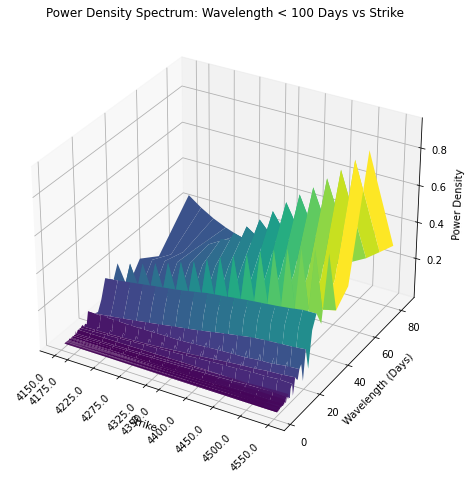

Max power density = 0.9388173134233417, occurs at strike = 4550.0 and wavelength ≃ 63.0 days.


In [37]:
#Fourier. I also have code for the historical data, but omitted here.

#create a pivot table

duplicates = iv_df[iv_df.duplicated(subset=["date","strike"], keep=False)]
iv_df = iv_df.groupby(["date","strike"], as_index=False)["implied_volatility"].mean()
iv_pivot = iv_df.pivot(index="date", columns="strike", values="implied_volatility")
iv_pivot_cleaned = iv_pivot.dropna(axis=1)

#filter the data

mask = (iv_pivot_cleaned.columns >= 4150*1000) & (iv_pivot_cleaned.columns <= 7000*1000)
iv_pivot_cleaned = iv_pivot_cleaned.loc[:, mask]

#FFT
strike_list = iv_pivot_cleaned.columns
iv_matrix = iv_pivot_cleaned.to_numpy()   
n_samples = iv_matrix.shape[0]

#Frequencies
freqs = fftfreq(n_samples, d=1)
pos_mask = freqs > 0
wavelengths = 1.0 / freqs[pos_mask]         
filter_mask = wavelengths < 100             

#Power spectra
power_list = []
for col_idx in range(iv_matrix.shape[1]):
    fft_vals   = fft(iv_matrix[:, col_idx])
    power_spec = np.abs(fft_vals)**2       
    power_list.append(power_spec[pos_mask])

power_densities = np.vstack(power_list)     

#Filter wavelengths & power array
filtered_wavelengths = wavelengths[filter_mask]
filtered_power_densities = power_densities[:, filter_mask]

#Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

X, Y = np.meshgrid(np.arange(len(strike_list)), filtered_wavelengths)
ax.plot_surface(X, Y, filtered_power_densities.T, cmap="viridis", edgecolor="none")

#Strikes
n_ticks = 10
tick_pos = np.linspace(0, len(strike_list)-1, n_ticks, dtype=int)
tick_labels = strike_list[tick_pos]/1000

ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")
ax.set_xlabel("Strike")
ax.set_ylabel("Wavelength (Days)")
ax.set_zlabel("Power Density")
ax.set_title("Power Density Spectrum: Wavelength < 100 Days vs Strike")

plt.tight_layout()
plt.show()

#Find highest energy wavelength
idx_strike, idx_wave = np.unravel_index(filtered_power_densities.argmax(),filtered_power_densities.shape)

max_strike = strike_list[idx_strike]
max_wavelength = filtered_wavelengths[idx_wave]
max_power = filtered_power_densities[idx_strike, idx_wave]

print(f"Max power density = {max_power}, occurs at strike = {max_strike/1000} and wavelength ≃ {max_wavelength} days.")

<ipython-input-39-2e3a48625d2c>:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


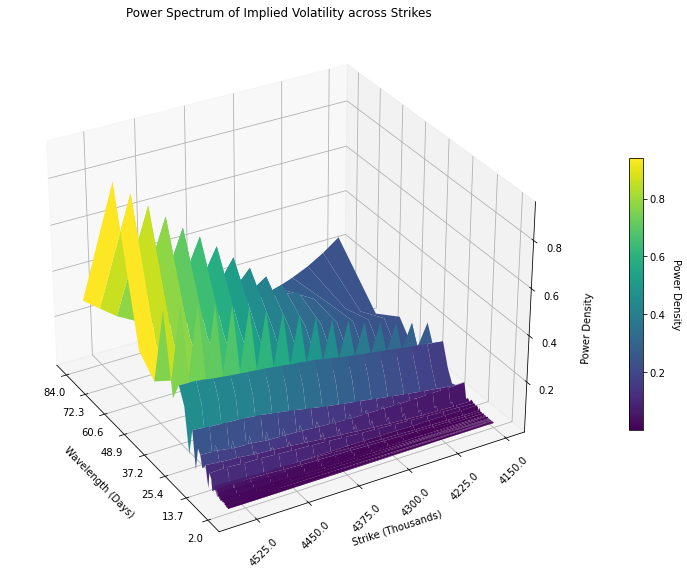

In [39]:
from matplotlib.ticker import MaxNLocator

# nicer plot

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot surface
surface = ax.plot_surface(X_grid, Y_grid, Z,
                          cmap="viridis",
                          edgecolor="none")

ax.view_init(elev=30, azim=150)

# X-axis (Wavelength)
n_wl_ticks = 8
wl_tick_pos = np.linspace(filtered_wavelengths.min(),
                          filtered_wavelengths.max(),
                          n_wl_ticks)
ax.set_xticks(wl_tick_pos)
ax.set_xticklabels([f"{wl:.1f}" for wl in wl_tick_pos], rotation=0)
ax.set_xlabel("Wavelength (Days)", labelpad=12)

# Y-axis (Strike in thousands) — use MaxNLocator for cleaner ticks
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))  # max 6 ticks, integers only

# Retrieve the tick positions from locator and set labels accordingly
y_tick_pos = ax.get_yticks()
# Filter tick positions to valid index range
y_tick_pos = y_tick_pos[(y_tick_pos >= 0) & (y_tick_pos < len(strike_list))].astype(int)

# Set y-tick labels with strike values (in thousands)
str_tick_labels = strike_list[y_tick_pos] / 1000
ax.set_yticks(y_tick_pos)
ax.set_yticklabels([f"{s:.1f}" for s in str_tick_labels], rotation=45)  # Rotate for readability
ax.set_ylabel("Strike (Thousands)", labelpad=12)

# Z-axis (Power Density)
ax.set_zlabel("Power Density", labelpad=12)
ax.set_title("Power Spectrum of Implied Volatility across Strikes")

# Add color bar
mappable = plt.cm.ScalarMappable(cmap="viridis")
mappable.set_array(Z)
cbar = fig.colorbar(mappable, shrink=0.5, pad=0.1)
cbar.set_label("Power Density", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [ ]:
#Wavelets
scales = np.arange(1, 100)        
wavelet = "cmor1.5-1.0"           
image_filenames = []

# list of strikes to iterate
strike_list = iv_pivot_cleaned.columns

all_power = [] 

# stack into a single 3D array: (n_strikes, n_scales, n_times)

for i, strike in enumerate(strike_list):
    vol_series = iv_pivot_cleaned[strike].dropna()
    if vol_series.empty:
        print(f"Skipping strike {strike} (no data)")
        continue

    time = mdates.date2num(vol_series.index)

    # CWT
    coeffs, freqs = pywt.cwt(
        data=vol_series.values,
        scales=scales,
        wavelet=wavelet,
        sampling_period=1
    )

    # power & normalize
    power = np.abs(coeffs) ** 2
    power /= np.max(power)  # Normalize by maximum power
    all_power.append(power)
    
    fig, ax = plt.subplots(figsize=(12, 5))

    extent = [time[0], time[-1], scales[-1], scales[0]]

    im = ax.imshow(
    power,
    extent=extent,
    aspect="auto",
    cmap="jet"
    )

    ax.invert_yaxis()  # small scales at top
    ax.set_yscale("log")
    ax.set_ylabel("Scale (log)")
    ax.axhline(y=63, color="white", linestyle="--", linewidth=1.5, label="y = 63")
    ax.legend()
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=30)
    ax.set_title("Average Wavelet Power Spectrum")
    fig.colorbar(im, ax=ax, label="Mean Power")
    plt.tight_layout()
    plt.show()
    
all_power = np.stack(all_power, axis=0)
max_power = all_power.max(axis=0) 

fig, ax = plt.subplots(figsize=(12, 5))

extent = [time[0], time[-1], scales[-1], scales[0]]
im = ax.imshow(
    max_power,
    extent=extent,
    aspect="auto",
    cmap="jet"
)

ax.invert_yaxis()  # small scales at top
ax.set_yscale("log")
ax.set_ylabel("Scale (log)")
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=30)
ax.set_title("Average Wavelet Power Spectrum")
fig.colorbar(im, ax=ax, label="Mean Power")
plt.tight_layout()
plt.show()

In [ ]:
# Parameters
scales = np.arange(1, 100)
wavelet = "cmor1.5-1.0"

# Find strike closest to 4550.0
target_strike = min(iv_pivot_cleaned.columns, key=lambda x: abs(float(x) - 4550.0*1000))
vol_series = iv_pivot_cleaned[target_strike].dropna()

# Check if there's data
if vol_series.empty:
    print(f"No data for strike {target_strike}")
else:
    time = mdates.date2num(vol_series.index)

    # Continuous Wavelet Transform
    coeffs, freqs = pywt.cwt(
        data=vol_series.values,
        scales=scales,
        wavelet=wavelet,
        sampling_period=1
    )

    # Power spectrum
    power = np.abs(coeffs) ** 2
    power /= np.max(power)  # Normalize

    # Apply nonlinear scaling (e.g., square root) to power for color scaling
    power_scaled = np.sqrt(power)

    fig, ax = plt.subplots(figsize=(12, 5))
    extent = [time[0], time[-1], scales[-1], scales[0]]

    # Use perceptually uniform colormap and set vmin/vmax to enhance low power contrast
    im = ax.imshow(
        power_scaled,
        extent=extent,
        aspect="auto",
        cmap="plasma",   # 'viridis' or 'plasma' recommended
        vmin=0,           # minimum of scaled power (sqrt of 0)
        vmax=np.sqrt(1)   # maximum of scaled power (sqrt of 1)
    )

    ax.invert_yaxis()
    ax.set_ylabel("Wavelegnth(days)")
    ax.set_title(f"Wavelet Power Spectrum for Strike {target_strike/1000}")
    ax.axhline(y=63, color="white", linestyle="--", linewidth=1.5, label="y = 63")
    ax.legend()
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=30)

    fig.colorbar(im, ax=ax, label="Square Root of Normalized Power")

    plt.tight_layout()
    plt.show()

## Computing the Hurst exponent of volatility 

In [ ]:
def simulate_exponential_fbm_davies_harte(n, H):
    """
    Simulate fractional Brownian motion of length n with Hurst H
    via the Davies–Harte method.
    """
    if n < 2:
        raise ValueError("n must be at least 2")

    k     = np.arange(n)
    gamma = 0.5 * ((np.abs(k+1)**(2*H))
                   - 2*(np.abs(k)**(2*H))
                   + (np.abs(k-1)**(2*H)))

    r = np.concatenate([gamma, gamma[-2:0:-1]])

    # Eigenvalues of the circulant matrix
    lam = np.fft.fft(r).real

    lam[lam < 0] = 0.0

    M = len(r)
    W = np.zeros(M, dtype=complex)

    # DC component
    W[0] = np.sqrt(lam[0] / M) * np.random.randn()
    # Nyquist frequency if M even
    if M % 2 == 0:
        W[M//2] = np.sqrt(lam[M//2] / M) * np.random.randn()

    half = M // 2
    for i in range(1, half):
        std = np.sqrt(lam[i] / (2*M))
        a, b = np.random.randn(), np.random.randn()
        W[i]   = std * (a + 1j*b)
        W[-i]  = np.conj(W[i])

    fgn = np.fft.ifft(W).real[:n]

    fbm = np.cumsum(fgn)
    exp_fbm = np.exp(fbm)
    return exp_fbm

In [ ]:
def hurst_wavelet_analysis(data, wavelet="db4", max_level=5):
    """Compute Hurst exponent using wavelet method"""
    coeffs = pywt.wavedec(data, wavelet, level=max_level)
    variances = [np.var(c) for c in coeffs[1:]]  # Skip approximation coefficients
    scales = [2**i for i in range(1, len(variances)+1)]
    
    log_scales = np.log(scales)
    log_vars = np.log(variances)
    
    slope, _ = np.polyfit(log_scales, log_vars, 1)
    return -(slope)/2

#Linear regressions RS analysis -> basically same as RS
def hurst_interaction_est(time_series, lags = None, plot = False):
    
    # Use default lags if none are provided
    if lags is None:
       lags = np.arange(1, 20)
    #print(time_series)
    # Compute log-volatility
    log_sigma = np.log(np.array(time_series))
    #print(log_sigma)
    log_m_values = []
    log_lag_values = []
    q_values = [] # to make a design matrix
    
    qs = np.array([.5, 1, 1.5, 2, 3])

    # For each lag d, and for each q compute the q-th moment of log-volatility increments
    for d in lags:
        for q in qs:
            
            # Compute increments over lag d
            increments = np.abs(log_sigma[d:] - log_sigma[:-d])
            #print(increments)
            m_q = np.mean(increments ** q)
            log_m_values.append(np.log(m_q))
            log_lag_values.append(np.log(d))
            q_values.append(q)

    # Put data from all lags and q values into a single data frame. Fit a model and use the interaction term as H
    hurst_df = pd.DataFrame({"log_m": log_m_values, "log_lag": log_lag_values, "q": q_values})
    #print(hurst_df)
    model = smf.ols("log_m ~ log_lag * q", data = hurst_df).fit()


    if plot:
        for q in qs:
            # Subset the data by q value
            subset = hurst_df[hurst_df["q"] == q]
            
            # Scatter the data
            plt.scatter(subset["log_lag"], subset["log_m"], label=f"q = {q}")
            
            # Generate a range of x values to predict over
            x_range = np.linspace(subset["log_lag"].min(), subset["log_lag"].max(), 50)
            
            # Build a DataFrame for prediction 
            pred_df = pd.DataFrame({"log_lag": x_range, "q": q})
            y_pred = model.predict(pred_df)
            
            # Plot the fitted line
            plt.plot(x_range, y_pred)
    
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Hurst estimate from interaction model")
        plt.legend(fontsize = 8)
        plt.show()

    return model.params["log_lag:q"]

# plot
H_list = [0.1, 0.25, 0.5, 0.75, 0.9]
n = len(iv_pivot_cleaned) * 100
window_size = 63

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 columns, large figure

for idx, hurst in enumerate(H_list):
    print(hurst)
    series = simulate_exponential_fbm_davies_harte(n, hurst)

    # --- Wavelet Method ---
    computed_wavelet = []
    for i in range(window_size, n):
        window_data = np.array(series[i-window_size:i])
        hurst_computed = hurst_wavelet_analysis(window_data)
        computed_wavelet.append(hurst_computed)
    computed_wavelet = np.array(computed_wavelet)

    ax = axes[0, idx]
    ax.hist(computed_wavelet, bins=50, density=True, alpha=0.6, edgecolor="black", label="Estimated Hurst values")
    ax.axvline(x=hurst, color="red", linestyle="--", label=f"True H: {hurst:.2f}")
    ax.axvline(x=np.mean(computed_wavelet), color="blue", linestyle="--", label=f"Mean: {np.mean(computed_wavelet):.2f}")
    ax.set_title(f"Wavelet Method (H={hurst})", fontsize=12)
    ax.set_xlabel("Hurst Exponent")
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

    # --- RS Method ---
    computed_rs = []
    for i in range(window_size, n):
        window_data = np.array(series[i-window_size:i])
        hurst_computed = hurst_interaction_est(window_data)
        computed_rs.append(hurst_computed)
    computed_rs = np.array(computed_rs)

    ax = axes[1, idx]
    ax.hist(computed_rs, bins=50, density=True, alpha=0.6, edgecolor="black", label="Estimated Hurst values")
    ax.axvline(x=hurst, color="red", linestyle="--", label=f"True H: {hurst:.2f}")
    ax.axvline(x=np.mean(computed_rs), color="blue", linestyle="--", label=f"Mean: {np.mean(computed_rs):.2f}")
    ax.set_title(f"RS Method (H={hurst})", fontsize=12)
    ax.set_xlabel("Hurst Exponent")
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()
    

In [ ]:
#Simulate data
n = len(iv_pivot_cleaned)*100 #100 times more
window_size = 63 # same window size ie same number of data points
H_list = [0.1, 0.25, 0.5, 0.75, 0.9]
for hurst in H_list:
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    computed = []
    for i in range(window_size, n):
        window_data = np.array(series[i-window_size:i])
        hurst_computed = hurst_wavelet_analysis(window_data)
        computed.append(hurst_computed)
    computed = np.array(computed)
    plt.figure(figsize=(10, 6))  # Larger figure size
    plt.hist(computed, bins=50, density=True, alpha=0.6, edgecolor="black", label="Estimated Hurst values")
    plt.axvline(x=hurst, color="red", linestyle="--", label=f"True Hurst value: {hurst:.4f}")
    plt.axvline(x=np.mean(computed), color="blue", linestyle="--", label=f"Mean estimated value: {np.mean(computed):.4f}")

    plt.title("Histogram of Estimated Hurst Exponents via Wavelets", fontsize=14)
    plt.xlabel("Hurst Exponent", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Move legend to the right
    plt.tight_layout()  # Adjust layout to fit everything

    plt.show()

#Simulate data
n = len(iv_pivot_cleaned)*100 #100 times more
window_size = 63 # same window size ie same number of data points
H_list = [0.1, 0.25, 0.5, 0.75, 0.9]
for hurst in H_list:
    print(hurst)
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    computed = []
    for i in range(window_size, n):
        window_data = np.array(series[i-window_size:i])
        hurst_computed = hurst_interaction_est(window_data)
        computed.append(hurst_computed)
    computed = np.array(computed)
    plt.figure(figsize=(10, 6))  # Larger figure size
    plt.hist(computed, bins=50, density=True, alpha=0.6, edgecolor="black", label="Estimated Hurst values")
    plt.axvline(x=hurst, color="red", linestyle="--", label=f"True Hurst value: {hurst:.4f}")
    plt.axvline(x=np.mean(computed), color="blue", linestyle="--", label=f"Mean estimated value: {np.mean(computed):.4f}")

    plt.title("Histogram of Estimated Hurst Exponents via RS method", fontsize=14)
    plt.xlabel("Hurst Exponent", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Move legend to the right
    plt.tight_layout()  # Adjust layout to fit everything

    plt.show()
    

In [ ]:
H_list = [0.1, 0.25, 0.5, 0.75, 0.9]
window_sizes = [10, 50, 100, 500, 1000]

fig, axes = plt.subplots(len(H_list), len(window_sizes), 
                         figsize=(4 * len(window_sizes), 3 * len(H_list)), 
                         sharex=False, sharey=False, constrained_layout=True)

for j, hurst in enumerate(H_list):
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    for k, window_size in enumerate(window_sizes):
        computed = []
        for i in range(window_size, n):
            window_data = np.array(series[i - window_size:i])
            hurst_computed = hurst_wavelet_analysis(window_data)
            computed.append(hurst_computed)
        computed = np.array(computed)
        
        ax = axes[j, k]
        ax.hist(computed, bins=50, density=True, alpha=0.6, edgecolor="black")
        ax.axvline(x=hurst, color="red", linestyle="--", label=f"True: {hurst:.2f}")
        ax.axvline(x=np.mean(computed), color="blue", linestyle="--", 
                   label=f"Mean: {np.mean(computed):.2f}")
        ax.set_title(f"Window size: {window_size}", fontsize=10)
        
        if k == 0:
            ax.set_ylabel(f"H = {hurst:.2f}", fontsize=10)
        if j == len(H_list) - 1:
            ax.set_xlabel("Estimated Hurst", fontsize=10)
        
        ax.tick_params(axis="both", labelsize=8)
        ax.legend(fontsize=7, loc="upper right")

fig.suptitle("Histogram of Estimated Hurst Exponents\nAcross True H Values and Window Sizes using Wavelet Analysis", fontsize=16)
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")
H_list = [0.1, 0.25, 0.5, 0.75, 0.9]
window_sizes = [10, 50, 100, 500, 1000]

fig, axes = plt.subplots(len(H_list), len(window_sizes), 
                         figsize=(4 * len(window_sizes), 3 * len(H_list)), 
                         sharex=False, sharey=False, constrained_layout=True)

for j, hurst in enumerate(H_list):
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    for k, window_size in enumerate(window_sizes):
        computed = []
        for i in range(window_size, n):
            window_data = np.array(series[i - window_size:i])
            hurst_computed = hurst_interaction_est(window_data)
            computed.append(hurst_computed)
        computed = np.array(computed)
        
        ax = axes[j, k]
        ax.hist(computed, bins=50, density=True, alpha=0.6, edgecolor="black")
        ax.axvline(x=hurst, color="red", linestyle="--", label=f"True: {hurst:.2f}")
        ax.axvline(x=np.mean(computed), color="blue", linestyle="--", 
                   label=f"Mean: {np.mean(computed):.2f}")
        ax.set_title(f"Window size: {window_size}", fontsize=10)
        
        if k == 0:
            ax.set_ylabel(f"H = {hurst:.2f}", fontsize=10)
        if j == len(H_list) - 1:
            ax.set_xlabel("Estimated Hurst", fontsize=10)
        
        ax.tick_params(axis="both", labelsize=8)
        ax.legend(fontsize=7, loc="upper right")

fig.suptitle("Histogram of Estimated Hurst Exponents\nAcross True H Values and Window Sizes using Multi-Moment R/S", fontsize=16)
plt.show()


In [ ]:
hursts = [(5 + 10 *i) / 100 for i in range(9)]  # H from 0.05 to 0.95
computed_hursts = []

n = len(iv_pivot_cleaned) * 100  

for hurst in hursts:
    print(hurst)
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    computed = [
        hurst_wavelet_analysis(series[i - window_size:i])
        for i in range(window_size, n)
    ]
    computed_hursts.append(np.mean(computed))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hursts, computed_hursts, label="Mean Estimated Hurst from Wavelet Analysis", color="blue", lw=2)
plt.plot(hursts, hursts, label="True Hurst (identity)", color="red", linestyle="--")
plt.xlabel("True Hurst", fontsize=12)
plt.ylabel("Estimated Hurst", fontsize=12)
plt.title("True vs Estimated Hurst Exponents", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
hursts = [(5 + i) / 100 for i in range(91)]  # H from 0.05 to 0.95
computed_hursts = []

n = len(iv_pivot_cleaned) * 100  

for hurst in hursts:
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    computed = [
        hurst_interaction_est(series[i - window_size:i])
        for i in range(window_size, n)
    ]
    computed_hursts.append(np.mean(computed))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hursts, computed_hursts, label="Mean Estimated Hurst from the RS method", color="blue", lw=2)
plt.plot(hursts, hursts, label="True Hurst (identity)", color="red", linestyle="--")
plt.xlabel("True Hurst", fontsize=12)
plt.ylabel("Estimated Hurst", fontsize=12)
plt.title("True vs Estimated Hurst Exponents", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
hursts_wavelet = [(5 + i) / 200 for i in range(191)]  
hursts_rs = [(5 + i) / 200 for i in range(191)]   
window_size = 63
n = len(iv_pivot_cleaned) * 200 
computed_hursts_wavelet = []
computed_hursts_rs = []

# Wavelet method
for hurst in hursts_wavelet:
    print(f"Wavelet H: {hurst}")
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    computed = [
        hurst_wavelet_analysis(series[i - window_size:i])
        for i in range(window_size, n)
    ]
    computed_hursts_wavelet.append(np.mean(computed))

# RS method
for hurst in hursts_rs:
    print(f"RS H: {hurst}")
    series = simulate_exponential_fbm_davies_harte(n, hurst)
    computed = [
        hurst_interaction_est(series[i - window_size:i])
        for i in range(window_size, n)
    ]
    computed_hursts_rs.append(np.mean(computed))

In [ ]:
# Plotting both on the same figure
plt.figure(figsize=(12, 6))
plt.plot(hursts_wavelet, computed_hursts_wavelet, label="Wavelet Method", color="blue", lw=2, marker='o')
plt.plot(hursts_rs, computed_hursts_rs, label="Rescaled Range Method", color="green", lw=2, marker='x')
plt.plot([0, 1], [0, 1], label="True Hurst (identity)", color="red", linestyle="--")

# Aesthetics
plt.xlabel("True Hurst", fontsize=12)
plt.ylabel("Estimated Hurst", fontsize=12)
plt.title("True vs Estimated Hurst Exponents", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
window_size = 63
hurst_df = pd.DataFrame(index=iv_pivot_cleaned.index[window_size:], 
                        columns=iv_pivot_cleaned.columns)

for selected_strike in iv_pivot_cleaned.columns:
    series = iv_pivot_cleaned[selected_strike].dropna()
    hurst_values = []
    for i in range(window_size, len(series)):
        window_data = series.iloc[i-window_size:i]
        hurst= hurst_interaction_est(window_data)
        hurst_values.append(hurst)
    
    hurst_df[selected_strike].loc[series.index[window_size:]] = hurst_values

mean_hurst = hurst_df.mean(axis=1)
std_hurst = hurst_df.std(axis=1)
count_hurst = hurst_df.count(axis=1)

z_score = 1.96  # For 95% CI
ci = z_score * std_hurst / np.sqrt(count_hurst)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(mean_hurst.index, mean_hurst, label="Mean Hurst Exponent", color="navy")
plt.fill_between(mean_hurst.index,
                 mean_hurst - ci,
                 mean_hurst + ci,
                 color="steelblue", alpha=0.3, label="95% CI")

plt.title(f"Mean Hurst Exponent with Confidence Intervals ({window_size}-day Window)")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mean_hurst

In [ ]:
window_size =50
hurst_df = pd.DataFrame(index=iv_pivot_cleaned.index[window_size:], 
                        columns=iv_pivot_cleaned.columns)

for selected_strike in iv_pivot_cleaned.columns:
    series = iv_pivot_cleaned[selected_strike].dropna()
    hurst_values = []
    for i in range(window_size, len(series)):
        window_data = series.iloc[i-window_size:i]
        hurst = hurst_interaction_est(window_data)
        hurst_values.append(hurst)
    
    hurst_df[selected_strike].loc[series.index[window_size:]] = hurst_values

mean_hurst = hurst_df.mean(axis=1)
std_hurst = hurst_df.std(axis=1)
count_hurst = hurst_df.count(axis=1)

z_score = 1.96  # For 95% CI
ci = z_score * std_hurst / np.sqrt(count_hurst)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(mean_hurst.index, mean_hurst, label="Mean Hurst Exponent", color="navy")
plt.fill_between(mean_hurst.index,
                 mean_hurst - ci,
                 mean_hurst + ci,
                 color="steelblue", alpha=0.3, label="95% CI")

plt.title(f"Mean Hurst Exponent with Confidence Intervals ({window_size}-day Window)")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Strengths of linear regressions -> take a look into it

In [ ]:
#Hurst against time

## Confidence

In [ ]:
#Is it worth using bootstrap and computing bootstrap on mean 

# Chapter 3: Heston and Rough Heston

## Simulating and Pricing using Heston

In [ ]:
from datetime import datetime, timedelta

# Market parameters
spot_price = 4000.0
risk_free_rate = 0.04
dividend_rate = 0
calculation_date = ql.Date(15, 7, 2023)
ql.Settings.instance().evaluationDate = calculation_date

# Heston parameters
v0 = 0.1       # Initial variance
kappa = 0.01      # Mean reversion speed
theta = 0.01     # Long-term variance
sigma = 2     # Vol of vol
rho = -0.2     # Correlatio

# Define strikes and maturities
strikes = np.linspace(500, 8000, 20)  # 9 strikes from 80 to 120
maturities_months = [3, 6, 12, 18] # Different maturities in months

# Set up handles
risk_free_handle = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, ql.Actual365Fixed()))
dividend_handle = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, ql.Actual365Fixed()))
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))

# Create Heston model
heston_process = ql.HestonProcess(
    risk_free_handle,
    dividend_handle,
    spot_handle,
    v0, kappa, theta, sigma, rho
)
heston_model = ql.HestonModel(heston_process)
engine = ql.AnalyticHestonEngine(heston_model)

# Storage for results
results = {}
day_counter = ql.Actual365Fixed()

for months in maturities_months:
    maturity_date = calculation_date + ql.Period(months, ql.Months)
    t = day_counter.yearFraction(calculation_date, maturity_date)
    results[months] = {'strikes': [], 'ivs': []}
    
    for strike in strikes:
        # Price with Heston model
        payoff = ql.PlainVanillaPayoff(ql.Option.Put, strike)
        exercise = ql.EuropeanExercise(maturity_date)
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(engine)
        heston_price = option.NPV()
        print(heston_price)
        
        # Calculate implied volatility
        try:
            # Create BS volatility structure
            vol_guess = 0.2
            flat_vol = ql.BlackConstantVol(
                calculation_date,
                ql.TARGET(),
                vol_guess,
                day_counter
            )
            vol_handle = ql.BlackVolTermStructureHandle(flat_vol)
            
            # Create BS process
            bsm_process = ql.BlackScholesMertonProcess(
                spot_handle,
                dividend_handle,
                risk_free_handle,
                vol_handle
            )
            
            # Compute implied vol
            bs_option = ql.VanillaOption(payoff, exercise)
            bs_engine = ql.AnalyticEuropeanEngine(bsm_process)
            bs_option.setPricingEngine(bs_engine)
            
            implied_vol = bs_option.impliedVolatility(
                heston_price, bsm_process, 1e-6, 100, 0.01, 2.0
            )
            
            results[months]['strikes'].append(strike)
            results[months]['ivs'].append(implied_vol)
            
        except Exception as e:
            print(f"Failed for {months}m, K={strike}: {str(e)}")
            continue

# Precompute time to maturity (in years) for each maturity using actual days
calculation_date = datetime(2023, 7, 15)
maturity_dates = {
    3: datetime(2023, 10, 15),
    6: datetime(2024, 1, 15),
    12: datetime(2024, 7, 15),
    18: datetime(2025, 1, 15)
}
Ts = {
    months: (maturity_date - calculation_date).days / 365.0
    for months, maturity_date in maturity_dates.items()
}

def heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    i = complex(0, 1)
    ln_S0 = np.log(S0)
    a = kappa * theta
    b = kappa
    sigma_sq = sigma_val ** 2

    d = np.sqrt((rho_val * sigma_val * i * u - b) ** 2 + sigma_sq * (i * u + u ** 2))
    g = (b - rho_val * sigma_val * i * u - d) / (b - rho_val * sigma_val * i * u + d)
    exp_dT = np.exp(-d * T)

    # Avoid division by zero in logarithm
    denominator = 1 - g * exp_dT
    if np.abs(denominator) < 1e-10:
        log_term = np.log(1e-10)
    else:
        log_term = np.log((1 - g * exp_dT) / (1 - g))

    C = (r - q) * i * u * T + (a / sigma_sq) * ((b - rho_val * sigma_val * i * u - d) * T - 2 * log_term)
    D = ((b - rho_val * sigma_val * i * u - d) / sigma_sq) * ((1 - exp_dT) / denominator)
    return np.exp(C + D * v0 + i * u * (ln_S0 + (r - q) * T))

def integrand(u, *args):  # Use *args to capture all parameters
    K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i = args
    i = complex(0, 1)
    if j == 1:
        cf = heston_characteristic(u - i, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        numerator = np.exp(-i * u * np.log(K)) * cf
        denominator = i * u * phi_minus_i
    else:
        cf = heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        numerator = np.exp(-i * u * np.log(K)) * cf
        denominator = i * u
    return np.real(numerator / denominator) if denominator != 0 else 0.0

def compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j):
    if j == 1:
        phi_minus_i = heston_characteristic(-complex(0, 1), T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
    else:
        phi_minus_i = None
    args = (K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i)
    integral, _ = quad(integrand, 0, np.inf, args=args, epsabs=1e-6, epsrel=1e-6, limit=1000)
    return 0.5 + (1 / np.pi) * integral

def heston_put_price(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    P1 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 1)
    P2 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 2)
    put_price = K * np.exp(-r * T) * (1 - P2) - S0 * np.exp(-q * T) * (1 - P1)
    return max(put_price, 0.0)

def black_scholes_put(S, K, T, r, q, sigma_val):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma_val**2) * T) / (sigma_val * np.sqrt(T))
    d2 = d1 - sigma_val * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def implied_volatility(target_price, S, K, T, r, q):
    def f(sigma): return black_scholes_put(S, K, T, r, q, sigma) - target_price
    try:
        return brentq(f, 0.001, 4.0, xtol=1e-6, maxiter=100)
    except:
        return np.nan

results1 = {}
for months in maturities_months:
    T_val = Ts[months]
    results1[months] = {'strikes': [], 'ivs': []}
    for strike in strikes:
        price = heston_put_price(strike, T_val, spot_price, risk_free_rate, dividend_rate, v0, kappa, theta, sigma, rho)
        #print(price)
        if price <= 0:
            continue
        iv = implied_volatility(price, spot_price, strike, T_val, risk_free_rate, dividend_rate)
        if not np.isnan(iv):
            results1[months]['strikes'].append(strike)
            results1[months]['ivs'].append(iv)

# Define plot settings
plt.figure(figsize=(10, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot QuantLib IVs
for idx, (months, data) in enumerate(results.items()):
    if data['strikes']:
        plt.plot(data['strikes'], data['ivs'], 
                 marker='o', linestyle='--', 
                 color=colors[idx % len(colors)], 
                 label=f'QuantLib ({months}M)')

# Plot Paper's Heston Model IVs
for idx, (months, data) in enumerate(results1.items()):
    if data['ivs']:
        plt.plot(data['strikes'], data['ivs'], 
                 marker='o', linestyle='-', 
                 color=colors[idx % len(colors)], 
                 label=f'Heston Model ({months}M)')

# Annotate the spot price
plt.axvline(spot_price, color='k', linestyle='--', label='Spot Price')

# Final plot adjustments
plt.title("Implied Volatility Comparison: QuantLib vs. Paper's Heston Model")
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calibration Section (Added Code)
from scipy.optimize import minimize

# Collect target implied volatilities and corresponding strikes/maturities
target_data = []
errors = []
for months in maturities_months:
    T_val = Ts[months]
    for strike, iv in zip(results[months]["strikes"], results[months]["ivs"]):
        target_data.append((strike, T_val, iv))

# Define the objective function to minimize
def objective(params):
    v0_fit, sigma_fit, rho_fit = params
    total_error = 0.0
    for strike, T, iv_target in target_data:
        # Compute put price with current parameters
        price = heston_put_price(
            strike, T, spot_price, risk_free_rate, dividend_rate,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            return 1e10  # Penalize invalid prices
        
        # Compute implied volatility
        iv_fit = implied_volatility(price, spot_price, strike, T, risk_free_rate, dividend_rate)
        if np.isnan(iv_fit):
            return 1e10
        
        total_error += (iv_fit - iv_target)**2
    print(total_error)
    errors.append(np.log(total_error))
    return total_error

# Initial guess (perturbed from true parameters for demonstration)
initial_params = [
    v0 * 1.5,   # Initial v0
    sigma * 0.7, # Initial sigma
    rho * 0.8    # Initial rho (-0.75 * 0.8 = -0.6)
]

# Parameter bounds (v0>0, kappa>0, theta>0, sigma>0, -1<=rho<=1)
bounds = [
    (1e-6, None), (1e-6, None), (-1, 1)
]

# Perform optimization
opt_result = minimize(
    objective, initial_params, method="L-BFGS-B",
    bounds=bounds, options={"maxiter": 50, "disp": True}
)

# Extract fitted parameters
v0_fit, sigma_fit, rho_fit = opt_result.x
print("\nTrue Parameters:")
print(f"v0={v0:.4f}, sigma={sigma:.4f}, rho={rho:.4f}")
print("Fitted Parameters:")
print(f"v0={v0_fit:.4f}, sigma={sigma_fit:.4f}, rho={rho_fit:.4f}")

# Generate IVs with fitted parameters for comparison
fitted_results = {}
for months in maturities_months:
    T_val = Ts[months]
    fitted_results[months] = {"strikes": [], "ivs": []}
    for strike in strikes:
        price = heston_put_price(
            strike, T_val, spot_price, risk_free_rate, dividend_rate,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            continue
        iv = implied_volatility(price, spot_price, strike, T_val, risk_free_rate, dividend_rate)
        if not np.isnan(iv):
            fitted_results[months]["strikes"].append(strike)
            fitted_results[months]["ivs"].append(iv)

plt.plot(errors)
plt.show()
            
# Plot comparison
plt.figure(figsize=(10, 6))
for idx, (months, data) in enumerate(results.items()):
    if data["strikes"]:
        plt.plot(data["strikes"], data["ivs"], marker="o", linestyle="-", 
                 color=plt.cm.tab10(idx), label=f"True {months}m")
for idx, (months, data) in enumerate(fitted_results.items()):
    if data["strikes"]:
        plt.plot(data["strikes"], data["ivs"], marker="x", linestyle="--", 
                 color=plt.cm.tab10(idx), label=f"Fitted {months}m")
plt.axvline(spot_price, color="k", linestyle=":", label="Spot Price")
plt.title("True vs. Fitted Heston Implied Volatilities")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()

## Pricing using data

In [ ]:
options_data = pd.read_csv("de4q8nnuyeep20cm.csv")
options_data["date"] = pd.to_datetime(options_data["date"])
options_data["exdate"] = pd.to_datetime(options_data["exdate"])

underlying_data = pd.read_csv("eclqezarx3ry3dbg.csv")
underlying_data["date"] = pd.to_datetime(underlying_data["date"])

merged_data = pd.merge(options_data, underlying_data, on="date", how="inner")
merged_data["mid_price"] = (merged_data["best_bid"] + merged_data["best_offer"]) / 2

#Filter Data and compute cleaned maturity
filtered_data = merged_data[merged_data["exdate"].isin(["2023-09-15", "2022-12-16", "2023-02-17"])].copy()
filtered_data = filtered_data[filtered_data["date"] == "2022-08-31"]
nyse = tc.get_calendar("XNYS")

filtered_data["date"] = pd.to_datetime(filtered_data["date"]).dt.tz_localize("UTC")
filtered_data["exdate"] = pd.to_datetime(filtered_data["exdate"]).dt.tz_localize("UTC")
min_date = pd.to_datetime("2022-08-31").tz_localize("UTC")
max_date = filtered_data["exdate"].max()

sessions = nyse.sessions_in_range(min_date, max_date)

def count_trading_days(start, end):
    trading_days = [day for day in sessions if start <= day < end]
    return len(trading_days)/252

#Compute interest rates via box
def box_rate(df_subset, K1, K2, maturity):
    
    df = df_subset.copy()
    df["mid"] = (df["best_bid"] + df["best_offer"]) / 2

    try:
        C1 = df.loc[(df["strike_price"] == K1) & (df["cp_flag"] == "C"), "mid"].iat[0]
        C2 = df.loc[(df["strike_price"] == K2) & (df["cp_flag"] == "C"), "mid"].iat[0]
        P1 = df.loc[(df["strike_price"] == K1) & (df["cp_flag"] == "P"), "mid"].iat[0]
        P2 = df.loc[(df["strike_price"] == K2) & (df["cp_flag"] == "P"), "mid"].iat[0]
    
    except IndexError:
        # missing one of the four legs
        raise ValueError(f"Missing call/put at {K1} or {K2} on {date}")
    
    cost = (C1 - C2) + (P2 - P1)
    
    #Implied r (factor of 1000 due to data...)
    r = -np.log(cost / ((K2 - K1)/1000)) / maturity
    return r

df = pd.read_csv("io263x9neh8bbccn.csv", sep=",")

results = []

for exdate in ["2023-09-15", "2022-12-16", "2023-02-17"]:
    print(exdate)
    df_day = df[(df["date"] == "2022-08-31") & (df["exdate"]== exdate)]
    maturity = count_trading_days(pd.to_datetime("2022-08-31").tz_localize("UTC"), pd.to_datetime(exdate).tz_localize("UTC"))

    # find strikes with both C & P
    strike_counts = (df_day.groupby("strike_price")["cp_flag"].nunique().reset_index(name="n_types"))

    eligible = strike_counts.query("n_types == 2")["strike_price"].sort_values()

    if len(eligible) < 2:
        results.append({"exdate": exdate, "r": r_val, "maturity": maturity})
        continue

    # choose strikes: lowest & highest available
    K1, K2 = eligible.iloc[0], eligible.iloc[-1]

    try:
        r_val = box_rate(df_day, K1, K2, maturity)

    except Exception as e:
        print(e)
        r_val = np.nan

    results.append({"exdate": exdate, "r": r_val, "maturity": maturity})

r_df = pd.DataFrame(results)

In [ ]:
#clean interest rates!!!!!!

def BSModel(underlying, maturity, strike, r, volatility, dividends = 0):
    d1 = (np.log(underlying / strike) + maturity * (r - dividends + (volatility ** 2) / 2)) / (volatility * np.sqrt(maturity))
    d2 = d1 - (volatility * np.sqrt(maturity))
    price = strike * np.exp( - r *maturity) * norm.cdf(-d2) - underlying * np.exp( - dividends * maturity) * norm.cdf( - d1)
    return price

def implied_volatility(mid_price, underlying, maturity, strike, r):
    # Define objective function as the difference between Black-Scholes price and market price
    objective = lambda vol: BSModel(underlying, maturity, strike, r, vol) - mid_price
    # Use Brent"s method to find volatility
    try:
        return brentq(objective, 0.0000001, 5)
    except Exception as e:
        print(e)
        # If root finding fails, return a small volatility estimate
        return 0.0000001

results = {}
for exdate in ["2022-12-16", "2023-02-17", "2023-09-15"]:
    truefilter = filtered_data[filtered_data["exdate"] == pd.to_datetime(exdate).tz_localize("UTC")]
    results[exdate] = {"strikes": [], "ivs": []}
    
    strikes = np.array(truefilter["strike_price"].astype(float)/1000)
    order = np.argsort(strikes)
    strikes = strikes[order]
    mid_price = np.array(truefilter["mid_price"].astype(float))[order]
    
    underlying = list(truefilter["close"].astype(float))[0]
    maturity = r_df[r_df ["exdate"] == exdate]["maturity"].values
    r = r_df[r_df ["exdate"] == exdate]["r"].values
    

    for i,strike in enumerate(strikes):
        iv = implied_volatility(mid_price[i], underlying, maturity, strike, r)
        if not np.isnan(iv):
            results[exdate]["strikes"].append(strike)
            results[exdate]["ivs"].append(iv)

underlying = list(truefilter["close"].astype(float))[0]
 
# Plotting
plt.figure(figsize=(10, 6))
colors = ["b", "g", "r", "c", "m", "y"]
for idx, (months, data) in enumerate(results.items()):
    if data["strikes"]:
        plt.plot(data["strikes"], data["ivs"], marker="o", color=colors[idx], label=f"Expiry: {months}")
plt.axvline(underlying, color="k", linestyle="--", label="Spot Price")
plt.title("Implied Volatility Smile/Skew (true data)")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()   

In [ ]:
# Calibration Section (Added Code)
from scipy.optimize import minimize
def implied_volatility(target_price, S, K, T, r, q):
    def f(sigma): return black_scholes_put(S, K, T, r, q, sigma) - target_price
    try:
        return brentq(f, 0.001, 4.0, xtol=1e-6, maxiter=100)
    except:
        return np.nan

# Collect target implied volatilities and corresponding strikes/maturities
target_data = []
errors = []
for exdate in ["2022-12-16", "2023-02-17", "2023-09-15"]:
    T_val = r_df[r_df ["exdate"] == exdate]["maturity"].values
    for strike, iv in zip(results[exdate]["strikes"], results[exdate]["ivs"]):
        target_data.append((strike, T_val, iv))

# Define the objective function to minimize
def objective(params):
    
    v0_fit, sigma_fit, rho_fit = params
    print(v0_fit,sigma_fit,rho_fit)
    total_error = 0.0
    for strike, T, iv_target in target_data:
        # Compute put price with current parameters
        price = heston_put_price(
            strike, T, underlying, risk_free_rate, dividend_rate,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            return 1e10  # Penalize invalid prices
        
        # Compute implied volatility
        iv_fit = implied_volatility(price, underlying, strike, T, risk_free_rate, dividend_rate)
        if np.isnan(iv_fit):
            return 1e10
        
        total_error += (iv_fit - iv_target)**2
    print(total_error)
    errors.append(np.log(total_error))
    return total_error

# Initial guess (perturbed from true parameters for demonstration)
initial_params = [
    0.1, 2, -0.2    # Initial rho (-0.75 * 0.8 = -0.6)
]

# Parameter bounds (v0>0, kappa>0, theta>0, sigma>0, -1<=rho<=1)
bounds = [
    (1e-6, None), (1e-6, None), (-1, 1)
]

# Perform optimization
opt_result = minimize(
    objective, initial_params, method="Nelder-Mead",
    bounds=bounds, options={"maxiter":10, "disp":True}
)

# Extract fitted parameters
v0_fit, sigma_fit, rho_fit = opt_result.x
print("Fitted Parameters:")
print(f"v0={v0_fit:.4f}, sigma={sigma_fit:.4f}, rho={rho_fit:.4f}")

# Generate IVs with fitted parameters for comparison
fitted_results = {}

for exdate in ["2022-12-16", "2023-02-17", "2023-09-15"]:
    T_val = r_df[r_df ["exdate"] == exdate]["maturity"].values
    fitted_results[exdate] = {"strikes": [], "ivs": []}
    for strike in strikes:
        price = heston_put_price(
            strike, T_val, underlying, risk_free_rate, dividend_rate,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            continue
        iv = implied_volatility(price, underlying, strike, T_val, risk_free_rate, dividend_rate)
        if not np.isnan(iv):
            fitted_results[exdate]["strikes"].append(strike)
            fitted_results[exdate]["ivs"].append(iv)

plt.plot(errors)
plt.show()
            
# Plot comparison
plt.figure(figsize=(10, 6))
for idx, (months, data) in enumerate(results.items()):
    if data["strikes"]:
        plt.scatter(data["strikes"], data["ivs"], marker="o", linestyle="-", 
                 color=plt.cm.tab10(idx), label=f"True {months}m")
for idx, (months, data) in enumerate(fitted_results.items()):
    if data["strikes"]:
        plt.scatter(data["strikes"], data["ivs"], marker="x", linestyle="--", 
                 color=plt.cm.tab10(idx), label=f"Fitted {months}m")
plt.axvline(underlying, color="k", linestyle=":", label="Spot Price")
plt.title("True vs. Fitted Heston Implied Volatilities")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#POOR MAN"S ROUGH HESTON

# Calibration Section (Added Code)
from scipy.optimize import minimize

from scipy.special import gamma
def implied_volatility(target_price, S, K, T, r, q):
    def f(sigma): return black_scholes_put(S, K, T, r, q, sigma) - target_price
    try:
        return brentq(f, 0.001, 4.0, xtol=1e-6, maxiter=100)
    except:
        return np.nan

# Collect target implied volatilities and corresponding strikes/maturities
target_data = []
errors = []
for exdate in ["2022-12-16", "2023-02-17", "2023-09-15"]:
    T_val = r_df[r_df ["exdate"] == exdate]["maturity"].values
    for strike, iv in zip(results[exdate]["strikes"], results[exdate]["ivs"]):
        target_data.append((strike, T_val, iv))

# Define the objective function to minimize
def objective(params):
    
    v0_fit, v, H, rho_fit = params
    
    print(v0_fit,v,H,rho_fit)
    total_error = 0.0
    for strike, T, iv_target in target_data:
        sigma_fit = v * np.sqrt(3 / (2 * H + 2)) / gamma(H + 1.5) * T**(H - 0.5)
        # Compute put price with current parameters
        price = heston_put_price(
            strike, T, underlying, risk_free_rate, dividend_rate,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        #print(price,sigma_fit)
        if price <= 0:
            return 1e10  # Penalize invalid prices
        
        # Compute implied volatility
        iv_fit = implied_volatility(price, underlying, strike, T, risk_free_rate, dividend_rate)
        if np.isnan(iv_fit):
            return 1e10
        
        total_error += (iv_fit - iv_target)**2
    print(total_error)
    errors.append(np.log(total_error))
    return total_error

# Initial guess (perturbed from true parameters for demonstration)
initial_params = [
    0.1, 1.5, 0.4, -0.2    # Initial rho (-0.75 * 0.8 = -0.6)
]

# Parameter bounds (v0>0, kappa>0, theta>0, sigma>0, -1<=rho<=1)
bounds = [
    (1e-6, None), (1e-6, None),(1e-6, None), (-1, 1)
]

# Perform optimization
opt_result = minimize(
    objective, initial_params, method="Nelder-Mead",
    bounds=bounds, options={"maxiter":100, "disp":True}
)

# Extract fitted parameters
v0_fit, sigma_fit, rho_fit = opt_result.x
print("Fitted Parameters:")
print(f"v0={v0_fit:.4f}, sigma={sigma_fit:.4f}, rho={rho_fit:.4f}")

# Generate IVs with fitted parameters for comparison
fitted_results = {}

for exdate in ["2022-12-16", "2023-02-17", "2023-09-15"]:
    T_val = r_df[r_df ["exdate"] == exdate]["maturity"].values
    fitted_results[exdate] = {"strikes": [], "ivs": []}
    for strike in strikes:
        price = heston_put_price(
            strike, T_val, underlying, risk_free_rate, dividend_rate,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            continue
        iv = implied_volatility(price, underlying, strike, T_val, risk_free_rate, dividend_rate)
        if not np.isnan(iv):
            fitted_results[exdate]["strikes"].append(strike)
            fitted_results[exdate]["ivs"].append(iv)

plt.plot(errors)
plt.show()
            
# Plot comparison
plt.figure(figsize=(10, 6))
for idx, (months, data) in enumerate(results.items()):
    if data["strikes"]:
        plt.scatter(data["strikes"], data["ivs"], marker="o", linestyle="-", 
                 color=plt.cm.tab10(idx), label=f"True {months}m")
for idx, (months, data) in enumerate(fitted_results.items()):
    if data["strikes"]:
        plt.scatter(data["strikes"], data["ivs"], marker="x", linestyle="--", 
                 color=plt.cm.tab10(idx), label=f"Fitted {months}m")
plt.axvline(underlying, color="k", linestyle=":", label="Spot Price")
plt.title("True vs. Fitted Heston Implied Volatilities")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid(True)
plt.show()

# Chapter 4: Calibrating Heston On Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load options data
df = pd.read_csv("h2cysi0h1exq2scy.csv")
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Load underlying data
underlying_data = pd.read_csv("eclqezarx3ry3dbg.csv")
underlying_data["date"] = pd.to_datetime(underlying_data["date"])

# Target trade date and expiries
trade_date = pd.Timestamp("2022-08-31")
target_exdates = [
    pd.Timestamp("2022-12-16"),
    pd.Timestamp("2023-02-17"),
    pd.Timestamp("2023-09-15")
]

# Get underlying price on trade_date
underlying_price = underlying_data.loc[underlying_data["date"] == trade_date, "close"].iloc[0]

# Filter options data
filtered_df = df[
    (df["date"] == trade_date) &
    (df["exdate"].isin(target_exdates)) &
    (~df["symbol"].str.contains("SPXW", na=False))
]

# Initialize results dictionary
results = {
    "2022-12-16": {"strikes": [], "ivs": []},
    "2023-02-17": {"strikes": [], "ivs": []},
    "2023-09-15": {"strikes": [], "ivs": []}
}

# Loop over selected expirations
for exdate in target_exdates:
    group = filtered_df[filtered_df["exdate"] == exdate].copy()

    # Filter for strike < 200 + underlying
    group = group[group["strike_price"] / 1000 < 200 + underlying_price]

    exdate_str = exdate.strftime("%Y-%m-%d")
    results[exdate_str]["strikes"] = group["strike_price"] / 1000
    results[exdate_str]["ivs"] = group["impl_volatility"]

# Plot
plt.figure(figsize=(10, 6))
for exdate_str, data in results.items():
    if len(data["strikes"]) == 0:
        continue
    plt.plot(data["strikes"], data["ivs"], label=f"Exp: {exdate_str}", marker='x', linestyle='None')

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("IV Curves on 2022-08-31 for Selected Expirations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
exdates = ['2022-12-16', '2023-02-17', '2023-09-15']
nyse = tc.get_calendar("XNYS")

def weighted_maturity(start, end, sessions):
    all_days = pd.date_range(start=start, end=end - pd.Timedelta(days=1), freq="D", tz="UTC")
    trading_days = [day for day in sessions if start <= day < end]
    n_trading_days = len(trading_days)
    n_non_trading_days = len(all_days) - len(trading_days)
    return (n_trading_days + 0.25 * n_non_trading_days) / ((3 * 252 + 365) / 4)

maturity_dict = {}

for exdate in exdates:
    sub = merged_data[merged_data["exdate"] == exdate].copy()
    sub["date"] = pd.to_datetime(sub["date"]).dt.tz_localize("UTC")
    sub["exdate"] = pd.to_datetime(sub["exdate"]).dt.tz_localize("UTC")

    start = sub["date"].min()
    end = sub["exdate"].max()
    sessions = nyse.sessions_in_range(start, end)

    maturity = weighted_maturity(start, end, sessions)
    maturity_dict[exdate] = maturity

target_date = pd.Timestamp("2022-08-31", tz="UTC")
filtered_df = r_only_df[r_only_df["date"].dt.normalize() == target_date]
r = filtered_df["median_r"].values[0]
q = filtered_df["estimated_q"].values[0]


In [ ]:
from scipy.integrate import fixed_quad
from scipy.optimize import brentq, minimize

phi_cache = {}  # key: T, value: φ(−i; T)


def heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    i = complex(0, 1)
    ln_S0 = np.log(S0)
    a = kappa * theta
    b = kappa
    sigma_sq = sigma_val ** 2

    d = np.sqrt((rho_val * sigma_val * i * u - b) ** 2 + sigma_sq * (i * u + u ** 2))
    g = (b - rho_val * sigma_val * i * u - d) / (b - rho_val * sigma_val * i * u + d)
    exp_dT = np.exp(-d * T)

    denom = 1 - g * exp_dT
    small = np.abs(denom) < 1e-10
    log_term = np.where(
        small,
        np.log(1e-10),
        np.log((1 - g * exp_dT) / (1 - g))
    )

    C = (r - q) * i * u * T + (a / sigma_sq) * ((b - rho_val * sigma_val * i * u - d) * T - 2 * log_term)
    D = ((b - rho_val * sigma_val * i * u - d) / sigma_sq) * ((1 - exp_dT) / denom)
    return np.exp(C + D * v0 + i * u * (ln_S0 + (r - q) * T))

# -------------------
# Integrand function
# -------------------
def integrand(u, *args):
    K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i = args
    i = complex(0, 1)

    if j == 1:
        cf = heston_characteristic(u - i, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        numerator = np.exp(-i * u * np.log(K)) * cf
        denominator = i * u * phi_minus_i
    else:
        cf = heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        numerator = np.exp(-i * u * np.log(K)) * cf
        denominator = i * u

    return np.real(numerator / denominator)

# ----------------------------------
# Compute P₁ or P₂ with caching
# ----------------------------------
def compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j):
    # Cache φ(−i; T) for j == 1
    if j == 1:
        if T not in phi_cache:
            phi_cache[T] = heston_characteristic(
                -complex(0, 1), T, S0, r, q, v0, kappa, theta, sigma_val, rho_val
            )
        phi_minus_i = phi_cache[T]
    else:
        phi_minus_i = None

    args = (K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i)

    # Integrate from 0 to U_max via fixed_quad
    U_max = 1000.0
    n_points = 1000
    integral, _ = fixed_quad(integrand, 0.0, U_max, args=args, n=n_points)
    return 0.5 + (1 / np.pi) * integral

def heston_put_price(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    P1 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 1)
    P2 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 2)
    put_price = K * np.exp(-r * T) * (1 - P2) - S0 * np.exp(-q * T) * (1 - P1)
    return max(put_price, 0.0)

# ----------------------------
# Black-Scholes put & IV
# ----------------------------
def black_scholes_put(S, K, T, r, q, sigma_val):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma_val**2) * T) / (sigma_val * np.sqrt(T))
    d2 = d1 - sigma_val * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def implied_volatility(target_price, S, K, T, r, q):
    def f(sigma_val):
        return black_scholes_put(S, K, T, r, q, sigma_val) - target_price
    try:
        return brentq(f, 0, 5.0, xtol=1e-6, maxiter=200)
    except Exception as e:
        #print(e)
        return np.nan

target_data = []
errors = []

for exdate in ['2022-12-16', '2023-02-17', '2023-09-15']:
    T_val = maturity_dict[exdate]
    for strike, iv in zip(results[exdate]['strikes'], results[exdate]['ivs']):
        target_data.append((strike, T_val, iv))

# Define the objective to minimize (Nelder-Mead)
def objective(params):
    v0_fit, sigma_fit, rho_fit = params
    n = 0
    missed = 0
    total_error = 0.0

    for strike, T, iv_target in target_data:
        price = heston_put_price(
            strike, T, underlying, r, q,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            continue  # penalize invalid price

        iv_fit = implied_volatility(price, underlying, strike, T, r, q)
        if np.isnan(iv_fit):
            missed = missed + 1
            continue
        n = n+1

        total_error += (iv_fit - iv_target) ** 2

    errors.append(np.log(total_error * ((n+missed)/n)))
    print(np.log(total_error * ((n+missed)/n)))
    return total_error

# Initial guess (v0, sigma, rho)
initial_params = [0.1, 3.0, -0.3]

bounds = [(1e-6, None), (1e-6, None), (-1, 1)]

opt_result = minimize(
    objective,
    initial_params,
    method='SLSQP',
    bounds=bounds,
    options={'maxiter': 5, 'disp': True}
)

v0_fit, sigma_fit, rho_fit = opt_result.x
print("Fitted Parameters:")
print(f"v0={v0_fit:.4f}, sigma={sigma_fit:.4f}, rho={rho_fit:.4f}")


In [ ]:
plt.figure(figsize=(16, 10))

# Use a color-blind-friendly colormap with enough distinct colors
cmap = plt.get_cmap("tab20")  # softer, more accessible palette
colors = cmap(np.linspace(0, 1, len(maturity_dict)))

for (exdate, color) in zip(maturity_dict.keys(), colors):
    T = maturity_dict[exdate]
    strikes = np.array(results[exdate]['strikes'])
    iv_market = np.array(results[exdate]['ivs'])

    # Plot observed market implied volatilities as large circles
    plt.scatter(
        strikes,
        iv_market,
        color=color,
        marker='o',
        s=100,
        edgecolor='black',
        label=f"Market IV ({exdate})"
    )

    # Compute model-implied volatilities on the same strikes
    iv_model = np.array([
        implied_volatility(
            heston_put_price(K, T, underlying, r, q, v0_fit, 0.0, 0.0, sigma_fit, rho_fit),
            underlying, K, T, r, q
        )
        for K in strikes
    ])

    # Plot model implied volatilities as 'X' markers, smaller and semi-transparent
    plt.scatter(
        strikes,
        iv_model,
        color=color,
        marker='x',
        s=70,
        alpha=0.8,
        label=f"Model IV ({exdate})"
    )

# Add title and axis labels with improved readability
plt.title("Heston Model: Market vs. Model-Implied Implied Volatility", fontsize=18, pad=15)
plt.xlabel("Strike Price", fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)

# Grid with light dashed lines for better visual guidance
plt.grid(True, linestyle='--', alpha=0.3)

# Place the legend outside the plot area for clarity
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,
    frameon=True,
    shadow=True
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.tight_layout()
plt.show()


In [ ]:
from scipy.integrate import fixed_quad
from scipy.optimize import brentq, minimize
from scipy.special import gamma

phi_cache = {}  # key: T, value: φ(−i; T)

def heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    i = complex(0, 1)
    ln_S0 = np.log(S0)
    a = kappa * theta
    b = kappa
    sigma_sq = sigma_val ** 2

    d = np.sqrt((rho_val * sigma_val * i * u - b) ** 2 + sigma_sq * (i * u + u ** 2))
    g = (b - rho_val * sigma_val * i * u - d) / (b - rho_val * sigma_val * i * u + d)
    exp_dT = np.exp(-d * T)

    denom = 1 - g * exp_dT
    small = np.abs(denom) < 1e-10
    log_term = np.where(
        small,
        np.log(1e-10),
        np.log((1 - g * exp_dT) / (1 - g))
    )

    C = (r - q) * i * u * T + (a / sigma_sq) * ((b - rho_val * sigma_val * i * u - d) * T - 2 * log_term)
    D = ((b - rho_val * sigma_val * i * u - d) / sigma_sq) * ((1 - exp_dT) / denom)
    return np.exp(C + D * v0 + i * u * (ln_S0 + (r - q) * T))


def integrand(u, *args):
    K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i = args
    i = complex(0, 1)

    if j == 1:
        cf = heston_characteristic(u - i, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        numerator = np.exp(-i * u * np.log(K)) * cf
        denominator = i * u * phi_minus_i
    else:
        cf = heston_characteristic(u, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val)
        numerator = np.exp(-i * u * np.log(K)) * cf
        denominator = i * u

    return np.real(numerator / denominator)

def compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j):
    # Cache φ(−i; T) for j == 1
    if j == 1:
        if T not in phi_cache:
            phi_cache[T] = heston_characteristic(
                -complex(0, 1), T, S0, r, q, v0, kappa, theta, sigma_val, rho_val
            )
        phi_minus_i = phi_cache[T]
    else:
        phi_minus_i = None

    args = (K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, j, phi_minus_i)

    # Integrate from 0 to U_max via fixed_quad
    U_max = 1000.0
    n_points = 1000
    integral, _ = fixed_quad(integrand, 0.0, U_max, args=args, n=n_points)
    return 0.5 + (1 / np.pi) * integral

def heston_put_price(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val):
    P1 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 1)
    P2 = compute_probability(K, T, S0, r, q, v0, kappa, theta, sigma_val, rho_val, 2)
    put_price = K * np.exp(-r * T) * (1 - P2) - S0 * np.exp(-q * T) * (1 - P1)
    return max(put_price, 0.0)

def black_scholes_put(S, K, T, r, q, sigma_val):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma_val**2) * T) / (sigma_val * np.sqrt(T))
    d2 = d1 - sigma_val * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def implied_volatility(target_price, S, K, T, r, q):
    def f(sigma_val):
        return black_scholes_put(S, K, T, r, q, sigma_val) - target_price
    try:
        return brentq(f, 0, 5.0, xtol=1e-6, maxiter=200)
    except Exception as e:
        #print(e)
        return np.nan

target_data = []
errors = []

for exdate in ['2022-12-16', '2023-02-17', '2023-09-15']:
    T_val = maturity_dict[exdate]
    for strike, iv in zip(results[exdate]['strikes'], results[exdate]['ivs']):
        target_data.append((strike, T_val, iv))

# Define the objective to minimize (Nelder-Mead)
def objective(params):
    v0_fit, v, H, rho_fit = params
    n = 0
    missed = 0
    total_error = 0.0

    for strike, T, iv_target in target_data:
        sigma_fit = v * np.sqrt(3 / (2 * H + 2)) / gamma(H + 1.5) * T**(H - 0.5)
        price = heston_put_price(
            strike, T, underlying, r, q,
            v0_fit, 0, 0, sigma_fit, rho_fit
        )
        if price <= 0:
            continue  # penalize invalid price

        iv_fit = implied_volatility(price, underlying, strike, T, r, q)
        if np.isnan(iv_fit):
            missed = missed + 1
            continue
        n = n+1

        total_error += (iv_fit - iv_target) ** 2

    errors.append(np.log(total_error * ((n+missed)/n)))
    print(np.log(total_error * ((n+missed)/n)))
    return total_error

# Initial guess (perturbed from true parameters for demonstration)
initial_params = [
    0.1, 2.3, 0.4, -0.2    
]

bounds = [
    (1e-6, None), (1e-6, None),(1e-6, 1), (-1, 1)
]

opt_result = minimize(
    objective,
    initial_params,
    method='SLSQP',
    bounds=bounds,
    options={'maxiter': 5, 'disp': True}
)

v0_fit, v, H, rho_fit = opt_result.x
print("Fitted Parameters:")
print(f"v0={v0_fit:.4f}, H={H:.4f}, rho={rho_fit:.4f}")


In [ ]:
plt.figure(figsize=(16, 10))

# Use a color-blind-friendly colormap with enough distinct colors
cmap = plt.get_cmap("tab20")  # softer, more accessible palette
colors = cmap(np.linspace(0, 1, len(maturity_dict)))

for (exdate, color) in zip(maturity_dict.keys(), colors):
    T = maturity_dict[exdate]
    strikes = np.array(results[exdate]['strikes'])
    iv_market = np.array(results[exdate]['ivs'])

    # Plot observed market implied volatilities as large circles
    plt.scatter(
        strikes,
        iv_market,
        color=color,
        marker='o',
        s=100,
        edgecolor='black',
        label=f"Market IV ({exdate})"
    )

    # Compute model-implied volatilities on the same strikes
    iv_model = np.array([
        implied_volatility(
            heston_put_price(K, T, underlying, r, q, v0_fit, 0.0, 0.0, sigma_fit, rho_fit),
            underlying, K, T, r, q
        )
        for K in strikes
    ])

    # Plot model implied volatilities as 'X' markers, smaller and semi-transparent
    plt.scatter(
        strikes,
        iv_model,
        color=color,
        marker='x',
        s=70,
        alpha=0.8,
        label=f"Model IV ({exdate})"
    )

# Add title and axis labels with improved readability
plt.title("Poor Man's Rough Heston Model: Market vs. Model-Implied Implied Volatility", fontsize=18, pad=15)
plt.xlabel("Strike Price", fontsize=14)
plt.ylabel("Implied Volatility", fontsize=14)

# Grid with light dashed lines for better visual guidance
plt.grid(True, linestyle='--', alpha=0.3)

# Place the legend outside the plot area for clarity
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,
    frameon=True,
    shadow=True
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.tight_layout()
plt.show()


In [ ]:
# Load options data
im_hurst = []
hi_hurst = []
df = pd.read_csv("h2cysi0h1exq2scy.csv")
df["date"] = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])

# Load underlying data
underlying_data = pd.read_csv("eclqezarx3ry3dbg.csv")
underlying_data["date"] = pd.to_datetime(underlying_data["date"])

target_exdates = [
    pd.Timestamp("2023-04-21"),
    pd.Timestamp("2023-09-15"),
    pd.Timestamp("2023-12-15")
]

start_trade_date = pd.Timestamp("2022-11-30")
end_trade_date = pd.Timestamp("2023-04-20")

date_range = pd.date_range(start=start_trade_date, end=end_trade_date)
hurst_iterable = {ts.date(): val for ts, val in mean_hurst.items()}
median_r_dict = {}
estimated_q_dict = {}

for row in r_only_df.itertuples(index=False):
    trade_date = row.date.date()  # datetime.date
    median_r_dict[trade_date] = row.median_r
    estimated_q_dict[trade_date] = row.estimated_q

for trade_date in date_range:
    if trade_date not in underlying_data["date"].values:
        print(f"Skipping {trade_date.date()} — not a trade day")
        continue
    
    # Get underlying price on trade_date
    underlying_price = underlying_data.loc[underlying_data["date"] == trade_date, "close"].iloc[0]
    d = trade_date.date() 
    hist_hurst = hurst_iterable.get(d, 0.5)
    r = median_r_dict.get(d, None)
    q = estimated_q_dict.get(d, None)
    print(r,q)
    # Filter options data
    filtered_df = df[
        (df["date"] == trade_date) &
        (df["exdate"].isin(target_exdates)) &
        (~df["symbol"].str.contains("SPXW", na=False))
    ]

    # Initialize results dictionary
    results = {
        "2023-04-21": {"strikes": [], "ivs": []},
        "2023-09-15": {"strikes": [], "ivs": []},
        "2023-12-15": {"strikes": [], "ivs": []}
    }
    
    exdates = ['2023-04-21', '2023-09-15', '2023-12-15']
    nyse = tc.get_calendar("XNYS")

    def weighted_maturity(start, end, sessions):
        all_days = pd.date_range(start=start, end=end - pd.Timedelta(days=1), freq="D", tz="UTC")
        trading_days = [day for day in sessions if start <= day < end]
        n_trading_days = len(trading_days)
        n_non_trading_days = len(all_days) - len(trading_days)
        return (n_trading_days + 0.25 * n_non_trading_days) / ((3 * 252 + 365) / 4)

    maturity_dict = {}

    for exdate in exdates:
        sub = merged_data[merged_data["exdate"] == exdate].copy()
        sub["date"] = pd.to_datetime(sub["date"]).dt.tz_localize("UTC")
        sub["exdate"] = pd.to_datetime(sub["exdate"]).dt.tz_localize("UTC")

        start = sub["date"].min()
        end = sub["exdate"].max()
        sessions = nyse.sessions_in_range(start, end)

        maturity = weighted_maturity(start, end, sessions)
        maturity_dict[exdate] = maturity

    trade_date_utc = pd.Timestamp(trade_date.date(), tz="UTC")

    # Loop over selected expirations
    for exdate in target_exdates:
        group = filtered_df[filtered_df["exdate"] == exdate].copy()

        # Filter for strike < 200 + underlying
        group = group[group["strike_price"] / 1000 < 200 + underlying_price]

        exdate_str = exdate.strftime("%Y-%m-%d")
        results[exdate_str]["strikes"] = group["strike_price"] / 1000
        results[exdate_str]["ivs"] = group["impl_volatility"]

    target_data = []
    errors = []

    for exdate in ['2023-04-21', '2023-09-15', '2023-12-15']:
        T_val = maturity_dict[exdate]
        for strike, iv in zip(results[exdate]['strikes'], results[exdate]['ivs']):
            target_data.append((strike, T_val, iv))
            
    def objective(params):
        v0_fit, sigma_fit, rho_fit = params
        n = 0
        missed = 0
        total_error = 0.0

        for strike, T, iv_target in target_data:
            price = heston_put_price(
                strike, T, underlying, r, q,
                v0_fit, 0, 0, sigma_fit, rho_fit
            )
            if price <= 0:
                continue  # penalize invalid price

            iv_fit = implied_volatility(price, underlying, strike, T, r, q)
            if np.isnan(iv_fit):
                missed = missed + 1
                continue
            n = n+1

            total_error += (iv_fit - iv_target) ** 2

        errors.append(np.log(total_error * ((n+missed)/n))+1)
        #print(np.log(total_error * ((n+missed)/n)))
        return total_error

    # Initial guess (v0, sigma, rho)
    initial_params = [0.1, 3.0, -0.3]

    bounds = [(1e-6, None), (1e-6, None), (-1, 1)]

    opt_result = minimize(
        objective,
        initial_params,
        method='SLSQP',
        bounds=bounds,
        options={'maxiter': 5, 'disp': True}
    )

    v0_fit, sigma_fit, rho_fit = opt_result.x
    print("Fitted Parameters:")
    print(f"v0={v0_fit:.4f}, sigma={sigma_fit:.4f}, rho={rho_fit:.4f}")
    initial_params = [
        v0_fit, sigma_fit/(np.sqrt(3 / (2 * hist_hurst + 2)) / gamma(hist_hurst+ 1.5)), hist_hurst, rho_fit    # Initial rho (-0.75 * 0.8 = -0.6)
    ]

    # Define the objective to minimize (Nelder-Mead)
    def objective(params):
        v0_fit, v, H, rho_fit = params
        n = 0
        missed = 0
        total_error = 0.0

        for strike, T, iv_target in target_data:
            sigma_fit = v * np.sqrt(3 / (2 * H + 2)) / gamma(H + 1.5) * T**(H - 0.5)
            price = heston_put_price(
                strike, T, underlying, r, q,
                v0_fit, 0, 0, sigma_fit, rho_fit
            )
            if price <= 0:
                continue  # penalize invalid price

            iv_fit = implied_volatility(price, underlying, strike, T, r, q)
            if np.isnan(iv_fit):
                missed = missed + 1
                continue
            n = n+1

            total_error += (iv_fit - iv_target) ** 2

        try:
            errors.append(np.log(total_error * ((n+missed)/n) + 1))
        except:
            return -1
        return total_error

    # Initial guess (v0, sigma, rho)
    # Initial guess (perturbed from true parameters for demonstration)

    bounds = [
        (1e-6, None), (1e-6, None),(1e-6, 1), (-1, 1)
    ]

    opt_result = minimize(
        objective,
        initial_params,
        method='SLSQP',
        bounds=bounds,
        options={'maxiter': 5, 'disp': True}
    )

    v0_fit, v, H, rho_fit = opt_result.x
    
    print("Fitted Parameters:")
    print(f"v0={v0_fit:.4f}, H={H:.4f}, rho={rho_fit:.4f}")
    im_hurst.append(H)
    hi_hurst.append(hist_hurst)


In [ ]:
# Filter Hurst exponents > 0.1
hist_hurst_filtered = [h for h in hi_hurst if h > 0.1]
implied_hurst_filtered = [h for h in im_hurst if h > 0.1]

# Extract dates and corresponding historical Hurst values
hurst_iterable = {ts.date(): val for ts, val in mean_hurst.items()}
dates = list(hurst_iterable.keys())

# Ensure lengths match for plotting
hist_dates = dates[:len(hist_hurst_filtered)]
implied_dates = dates[:len(implied_hurst_filtered)]

# Color-blind friendly colors: blue and orange
color_hist = '#0072B2'   # blue
color_implied = '#E69F00'  # orange

plt.figure(figsize=(12, 6))

# Historical Hurst: triangles, blue
plt.scatter(hist_dates, hist_hurst_filtered, marker='^', color=color_hist, label='Historical Hurst')

# Implied Hurst: circles, orange
plt.scatter(implied_dates, implied_hurst_filtered, marker='o', color=color_implied, label='Implied Hurst')

# Formatting x-axis with dates
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xlabel('Time (Date)', fontsize=14)
plt.ylabel('Hurst Exponent', fontsize=14)
plt.title('Historical vs. Implied Hurst Exponents Over Time', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
